# Code of the final analyses performed for the paper: 
Date: 20 July 2022<br>
Author: Roshan Rane<br>

## Meeting notes
Date: 30 June 2022 <br>
Attended: Milena and Kerstin<br>
Meeting notes:<br>
1. Get other variables of interest from Milena and run the analysis on them -> July 1st week
2. ~Why didnt controlling for ESPAD-Alc reduce it so much -> use age 22 instead of 18~
3. ~Control for binge variable itself or a noisy variant of it?~
4. Should I instead try testing it on my new 3D tool by training a neural network on the data?
5. We could not even predict personality vars from sMRI? Add additional plot to show this vs binge drinking
6. color the variables by categories
7. check smoking var used in Whelan paper


@Milena:
* Analysis 0 is where I preprocess all the missing confounds. You should check the distribution of these variables to see that the median binary threshold makes sense for them
* Ensure that the table Confounds_list_Milena.xlsx has no '???' or empty cells in columns ['colname', 'questionnaire', 'impute_missing_with','binarizing_threshold','category'] --> DONE
* In Analysis 1 I prepare the h5files. I have shown an example for the Imaging-at-BL-onset0 h5file. It would be helpful if you take a look at all the output msgs and distributions once, just in case I missed something. 
* Thank you :)

In [1]:
# standard python packages
import os, sys
from glob import glob
from os.path import join 
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from scikits.bootstrap import ci

import seaborn as sns
sns.set(style="whitegrid", context='paper', color_codes=False)
sys.path.append("../MLpipelines")
from plotResults import *

import h5py
import random

In [2]:
H5_DIR = "/ritter/share/data/IMAGEN/h5files/"
CONF_DATA_DIR = "/ritter/share/data/IMAGEN/posthoc/"
RESULTS_DIR = "/ritter/roshan/workspace/ML_for_IMAGEN/MLpipelines/results/"

In [3]:
H5_FILES = {
    "h5causal0" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477.h5",
    "h5causal1" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newlbls-clean-fu3-espad-fu3-19a-binge-n650.h5",
    # "h5fu2" : "newlbls-clean-fu2-espad-fu3-19a-binge-n634.h5",
    # "h5bl" : "newlbls-clean-bl-espad-fu3-19a-binge-n620.h5",
}

## Useful helper functions

### H5 file inspection funcs

In [4]:
def plot_dists(h5, lbl, col_names, suptitle=''):
    
    df = pd.DataFrame({c:h5[c][()] for c in [lbl]+col_names})
    df.index = h5["i"][()]
    
    if len(df[lbl].unique())>2:
        print("lbl has more than 2 states and in range [{}, {}, {}] \n aborting distribution plots .....".format(
                df[lbl].min(), df[lbl].mean(), df[lbl].max())) 
    else:        
        f, axes = plt.subplots(1, len(col_names)+1, figsize=(4*(len(col_names)+1), 3))
        if suptitle: plt.suptitle(suptitle)

        val = dict(df[lbl].astype(int).astype('str').value_counts())
        axes[0].pie(list(val.values()), labels = list(val.keys()), autopct='%1.0f%%', shadow=True, startangle=90) 
        axes[0].axis('equal')

        for ax, c in zip(axes[1:], col_names):
            if len(df[c].unique())<=10: # then bar plot
                dfi = df[[c,lbl]].value_counts(dropna=False).unstack().sort_index()

                dfi.sort_index().plot.bar(
                    stacked=True, title=c, legend=True, 
                    alpha=0.5, sort_columns=True, 
                    grid=True, rot=90, ax=ax, width=0.9)
    #             for i, x in enumerate(dfi.values):
    #                 ax.text(i, x+(x/100)+1, str(x))

            else: # histogram
                for lbl_i, dfi in df.groupby(lbl):
                    lbl_i = int(lbl_i)
                    dfi[c].plot.hist(label="lbl="+str(lbl_i), title=c,
                                     grid=True, alpha=0.5, legend=True, bins=10, ax=ax)

        plt.legend()   
        plt.show()

def check_h5_contents(H5_FILES, ignore=''):
    
    if isinstance(H5_FILES, str): H5_FILES = [H5_FILES]
    
    for k, h5_files_glob in enumerate(H5_FILES):
        
        for h5_file in glob(h5_files_glob):
            print("______________________________________________________________________________________")
            if ignore and ignore in h5_file:
                print(f"ignoring '{h5_file}' because of the ignore str '{ignore}'")
            else:            
                with h5py.File(h5_file, 'r') as h5:
                    print("filename: {} \n h5.columns = {} \n h5.attrs = {}".format(
                        h5_file.split("/")[-1], list(h5.keys()), list(h5.attrs.keys())))

                    try:
                        n = len(h5["i"])
                        y = h5.attrs['labels'][0]
                        conf_names=h5.attrs["confs"].tolist()
                        print("n = {} \t label = {} \t X.shape = {}  \t confs = {}".format( 
                            n, y, h5["X"].shape, conf_names))

                        # plot the confs and label distributions in the data
                        print("label and conf with distributions:")
                        plot_dists(h5, y, conf_names)

                    except Exception as e:  print(e) 

                    # plot a random subject's brain image in the data 
                    random_i = random.randint(0, n-1)
                    img = h5["X"][random_i]
                    print("\nsubject: {} \t (min={:.2f}, mean={:.2f}, max={:.2f})".format(
                        h5["i"][random_i], img.min(), img.mean(), img.max()))
                    
                    for conf in  conf_names:
                        if conf not in ['sex','site']:
                            print(f"conf {conf} == label {y} ? \t True for n={np.sum(h5[conf][:]==h5[y][:])}/{n}")

In [103]:
def print_h5_for_MLpipeline(h5_dir=H5_DIR, filter_func=lambda filename: 'posthoc-cc-bl' in filename and 'causal' in filename):
    
    # print(f"  DATA_DIR + 'h5files/{ori_h5_file}',")
    for h5file in sorted(os.listdir(h5_dir)):
        if filter_func(h5file):
            print(f"  DATA_DIR + 'h5files/{h5file}',")

### attach conf to H5 files

In [208]:
# add binge itself as a conf
def attach_conf_fromseries(H5_DIR, to_h5, conf, prepend='h5causal1', print_all=True):
    
    # create a new h5 file name
    out_h5 = '-'.join(['posthoc-cc2',prepend,conf.name])+'.h5'
    if print_all: print("writing to ..", out_h5)
    assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    try:
        with h5py.File(H5_DIR+out_h5, 'w') as data_out:
            # first just copy all h5 file data to new h5 file    
            with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
                for dataset in data_dest:
                    data_out.create_dataset(dataset, data=data_dest[dataset]) 
                for attr in data_dest.attrs:
                    data_out.attrs[attr]=data_dest.attrs[attr]

            # now add the confound
            if conf.name not in data_out.attrs['confs']:

                if print_all: print(f"attaching conf {conf.name}")
                data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf.name]
                # align the subject IDs to fill the right conf value for each subject in the h5
                h5_sub_ids = data_out['i'][:]
                # below script works only if the IDs in src data h5 are arranged in an ascending order
                assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                conf = conf.sort_index()
                h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                data_out.create_dataset(conf.name, data=conf.iloc[conf_sub_ids_in_h5]) 

                # check if the distribution of confound is acceptable
                for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                    assert counts>=0.15*len(conf_sub_ids_in_h5), f"\
the value {val} in {conf.name} has fewer than 15% instances (n={counts})\
\nThis is very small for counter balancing to work properly.."

                # remove subject IDs missing the conf info
                if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                    print(f"[WARN] n={len(h5_sub_ids)-len(h5_sub_ids_in_conf)} subs missing this conf information. \
Dropping sample size from {len(h5_sub_ids)} to {len(h5_sub_ids_in_conf)}")
                    existing_datasets = list(data_out.keys())
                    existing_datasets.remove(conf.name)
                    # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                    for existing_dataset in existing_datasets:
                        new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                        del data_out[existing_dataset] 
                        data_out.create_dataset(existing_dataset, data=new_data) 

    except Exception as e:
        if os.path.isfile(H5_DIR+out_h5): os.remove(H5_DIR+out_h5)
        raise e

In [7]:
def attach_conf_fromh5(H5_DIR, from_h5, to_h5, print_all=True):
    
    # create a new h5 file name
    out_h5 = "-".join(from_h5.split('-')[:-1])+"-"+ "-".join(to_h5.split('-')[-4:])
    if print_all: print("writing to ..", out_h5)
    
    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]
            
        # now add the confound
        with h5py.File(H5_DIR+from_h5, 'r') as data_src:
                for dataset in data_src:
                    if dataset not in data_out:
                        if print_all: print(f"attaching conf {dataset}")
                        data_out.attrs['confs'] = list(data_out.attrs['confs'])+[dataset]
                        # match subject IDs
                        src_sub_ids = data_src['i'][:]
                        out_sub_ids = data_out['i'][:]
                        # ASSUMPTION: the src_sub_ids is sorted in ascending order of IDs
                        valid_idx = np.argwhere(np.in1d(src_sub_ids, out_sub_ids)).squeeze()
                        data_out.create_dataset(dataset, data=data_src[dataset][valid_idx]) 
                        
                        if len(valid_idx)<len(out_sub_ids):
                            print(f"[WARN] only {len(valid_idx)} sub IDs were found for this conf data, out of {len(out_sub_ids)}")
                            existing_datasets = list(data_out.keys())
                            existing_datasets.remove(dataset)
                            # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                            for existing_dataset in existing_datasets:
                                valid_idx_2 =  np.argwhere(np.in1d(out_sub_ids, src_sub_ids)).squeeze()
                                new_data = data_out[existing_dataset][valid_idx_2] 
                                del data_out[existing_dataset] 
                                data_out.create_dataset(existing_dataset, data=new_data) 
                            

### Result helper funcs

In [8]:
def std_dev_diff(scores1, scores2):
    std_dev = ((scores1.values-scores2.values) - (scores1.mean() - scores2.mean())) / (((scores1.std()**2)/len(scores1) + (scores2.std()**2)/len(scores2))**(1/2))
    # print(std_dev)
    return std_dev.mean()

def create_accuracy_csv(fil_name='', save_df=False):
    
    map_fil_to_blh5 = {'h5causal1': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565/20220726-1119/run.csv",
                       'h5causal0': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477/20220414-1352/run.csv",
                       'h5fu3': RESULTS_DIR+"/newlbls-clean-fu3-espad-fu3-19a-binge-n650/20211026-1911/run.csv",
                       'h5fu2': RESULTS_DIR+"/newlbls-clean-fu2-espad-fu3-19a-binge-n634/20210618-1701/run.csv",
                       'h5bl': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-n620/20211026-1810/run.csv",
                      }
    
    df_out = pd.DataFrame()

    for resultfile in glob(f"../MLpipelines/results/posthoc-cc2*{fil_name}*/*/run.csv"):

        df = pd.read_csv(resultfile)    
        conf_name = list(df.o.unique())
        [conf_name.remove(remove) for remove in ['X','Binge', 'sex', 'site'] if remove in conf_name]
        assert len(conf_name)==1, conf_name+" list should have only the new confound"
        conf_name=conf_name[0]
        
        for model, dfi in df.groupby('model'):
            
            df_out_i = {'Confound':conf_name.title(), 
                        'TP':'BL', 
                        'Model':model,
                        'h5name':resultfile.split('/')[-3]}
            
            if 'baseline-cb' in dfi['technique'].unique():
                dfi_bl = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'baseline-cb')]
            else:
                dfi_bl = pd.read_csv(map_fil_to_blh5[fil_name]).groupby('model').get_group(model)
                baseline_cb = 'cb' if 'baseline-cb' not in dfi['technique'].unique() else 'baseline-cb'
                dfi_bl = dfi_bl.loc[(dfi_bl['io'] == 'X-Binge') & (dfi_bl['technique'] == baseline_cb)]                
                
            df_out_i.update({'Accuracy BL':  dfi_bl['test_score'].mean()})
            df_out_i.update({'Std-Dev BL':   dfi_bl['test_score'].std()})

            dfi_conf = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'cb')]
            df_out_i.update({'Accuracy CB':   dfi_conf['test_score'].mean()})
            df_out_i.update({'Std-Dev CB':    dfi_conf['test_score'].std()})
            
            df_out_i.update({'Accuracy Diff CB - BL':  (dfi_conf['test_score'].mean() - dfi_bl['test_score'].mean())})
            df_out_i.update({'Std-Dev Diff CB - BL':  std_dev_diff(dfi_conf['test_score'], dfi_bl['test_score'])})
            
            # display(df_out_i)
            df_out = df_out.append(df_out_i, ignore_index=True)
            
    if save_df: df_out.to_csv(f"results/accuracy{fil_name}.csv", index=False)
    return df_out

In [9]:
def plot_accuracy_csv(df):

    fig, axes = plt.subplots(1, 2, 
                             sharex=False, sharey=True, 
                             constrained_layout=True,
                             figsize=(4*len(df[['Confound','h5name']].nunique()), 16))   
    fs=12
    if isinstance(df,str): df = pd.read_csv(f'results/accuracy-{df}.csv')

    df = df.loc[(df['Model'].isin(['SVM-rbf','GB']))].sort_values(
        ['Accuracy Diff CB - BL','Confound'], ascending=False)
    # display(df)
    
    # multiply values by 100 for percent
    for col in df:
        if 'accuracy' in col.lower() or 'std' in col.lower(): 
            df[col] = df[col]*100
            
    # if there are more than 1 h5files in the accuracy df then mention the h5file name in the xticks
    # if 'h5name' in df and df.h5name.nunique()>1:        
    #     df['Confound'] = df['Confound'].str.cat(
    #             df['h5name'].apply(lambda x: '('+''.join(x.split('-')[-2:])+')'), sep='\n')
    
    # predetermine colors for each model
    colors = {m :plt.get_cmap('tab10')(i) for i,m in enumerate(df['Model'].unique())}
    # 1) plot absolute accuracies on X axis - baseline     
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy BL", x='Confound', 
            # xerr="Std-Dev BL",
            width=0.2, position=1.3*i, label=None, 
            ax=axes[0],
            **diff_style_args)
    # add patch lines
    for bar in axes[0].patches:
        bar.set_hatch('\\\\\\\\')
        
    # 2) plot absolute accuracies on X axis - corrected 
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        df_i.plot(kind='barh',
            y="Accuracy CB", x='Confound', 
            xerr="Std-Dev CB",
            width=0.2, position=1.3*i, label=model, 
            ax=axes[0],
            color=colors[model], alpha=1)
    
     # 3) plot decrease/difference in accuracy on X axis
    for i, (model, df_i) in enumerate(df.groupby('Model')):  
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy Diff CB - BL", x='Confound',  sort_columns=True,
            xerr="Std-Dev Diff CB - BL", 
            width=0.2, position=1.3*i, label=model, 
            ax=axes[1], 
            **diff_style_args)
        axes[1].axvline(0,color='k', ls='--')
        
    # add patch lines
    for bar in axes[1].patches:
        bar.set_hatch('\\\\\\\\')
                
    # adjust legend of axes[0]
    hdls, lbls = axes[0].get_legend_handles_labels()
    axes[0].get_legend().remove()
    axes[1].legend(hdls,
                   [lbls[2]+' (before \ncorrection)',
                    lbls[3]+'\n(before \ncorrection)', 
                    lbls[2]+' (after \ncorrection)',
                    lbls[3]+'\n(after \ncorrection)'],
                   fontsize=fs-1, loc=[1.1,0.9])
    
    
    plt.suptitle("Model accuracies before and after correction", fontsize=fs+2)
    axes[0].set_title(f'Absolute accuracy (%)', fontsize=fs)
    axes[0].set_xlabel(f'Absolute accuracy (%)', fontsize=fs)
    axes[0].set_xlim([50,75])
    axes[1].set_title(f'(%) reduction in accuracy', fontsize=fs)
    axes[1].set_xlabel(f'(%) reduction in accuracy', fontsize=fs)
    axes[1].set_xlim([-10,10])
    axes[0].grid(False)
    axes[1].grid(False)
    
    # plt.tight_layout()

In [11]:
# For preprocessing confounds from raw tables
RAW_Q_DIR = '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7'

def get_col_raw_df(loc, df_confs):
    row = df_confs.loc[loc]
    tp, quest, formula = row[['time_point','raw questionnaire','score computation']]
    sep='\t' if 'dawba' in quest.lower() else ','
    df_raw = pd.read_csv((RAW_Q_DIR+quest), sep=sep)
    # convert user code to subject ID 
    if ('User code' in df_raw):
        df_raw.index = df_raw['User code'].astype(str).apply(lambda x: int(x.replace("-C", "").replace("-I", "").replace("-P", "")))

    df_raw.index.name = 'ID'
    return df_raw, tp, quest, formula

## Analysis 0: prepare missing covariate data
Prepare `all_*.csv` files for confounds that are missing this info. <br>
Extract all_* tables from raw tables.  <br>
Some confound information need to be extracted from the tables provided by IMAGEN.

In [35]:
df_confs = pd.read_excel("Confounds_list_Milena.xlsx")
print("Rows that need to be preprocessed n =", len(df_confs.dropna(subset=['raw questionnaire'])))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

Rows that need to be preprocessed n = 45


In [36]:
# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.dropna(subset=['raw questionnaire']).iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv
31 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
32 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  """


33 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
34 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  """


48 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
54 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
68 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
71 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
84 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
86 FU3 /FU

##### all_PDS 
30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv

In [266]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(30)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 1274 to 99954902
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User code            2208 non-null   object 
 1   Iteration            2208 non-null   int64  
 2   Language             2206 non-null   object 
 3   Completed            2208 non-null   object 
 4   Completed Timestamp  2208 non-null   object 
 5   Processed Timestamp  2208 non-null   object 
 6   Valid                2208 non-null   object 
 7   a10_f                1129 non-null   float64
 8   a10_m                1079 non-null   float64
 9   a11_f                1129 non-null   float64
 10  a11_m                1079 non-null   float64
 11  a12_m                1079 non-null   float64
 12  a12a_f               1129 non-null   float64
 13  a12b_f               1007 non-null   float64
 14  a13_f                1129 non-null   float64
 15  a13_m                1079 non-n

In [267]:
columns = sorted('a8_f + a9_f + a10_f + a11_f + a12a_f + a13_f + a8_m + a9_m + a10_m + a11_m + a12_m + a13_m'.split(' + '))
columns
# @Milena some column names are like 'a12a_m' do not exist. I will sum all columns starting with 'a'
# --> right, there's no item a12a_m (m stands for for male). Corrected it in the line above. 

['a10_f',
 'a10_m',
 'a11_f',
 'a11_m',
 'a12a_f',
 'a12a_m',
 'a13_f',
 'a13_m',
 'a8_f',
 'a8_m',
 'a9_f',
 'a9_m']

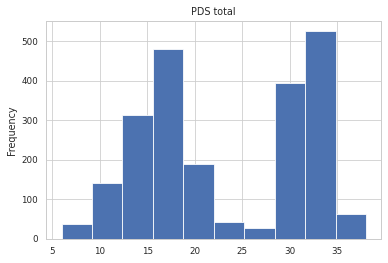

In [268]:
df_raw = df_raw.filter(regex='^a')
# correcting recode values a12a_f: 0 = 1, 1 = 4 @Milena what about a12b_f
# --> a12b_f is an age variable (and is not consodered in sum score computation), no need to recode 
df_raw.loc[:,'a12a_f'] = df_raw['a12a_f'].map({0:1,1:4})
# filling NaNs with 0 @Milena
df_raw = df_raw.fillna(0)
df_out = df_raw.sum(axis=1)
df_out.plot.hist(title='PDS total')
plt.show() #@Milena looks bimodal - might the total be different for differnt sex? Ex: Females have higher scores?
# --> yes, that's the most likely explanation as e.g. females start puberty earlier on average

In [269]:
# prepare the all_PDS.csv
df_out.name = 'PDS Sum'
df_out = df_out.to_frame()
df_out['Session']=tp
df_out

PDS Sum Session
ID                       
1274         16.0      BL
22453        14.0      BL
75717        18.0      BL
106601       15.0      BL
106871       31.0      BL
...           ...     ...
99873252     31.0      BL
99875982     32.0      BL
99888850     12.0      BL
99930021     34.0      BL
99954902     18.0      BL

[2208 rows x 2 columns]

In [270]:
# save as all_PDS.csv
df_out.to_csv(CONF_DATA_DIR + "all_PDS.csv")

##### all_ESPAD
* 31 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 34 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [549]:
df_raw, tp, quest, formula = get_col_raw_df(31)
quest, formula

('/BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv',
 "sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10")

In [550]:
_, tp2, quest2, formula2 = get_col_raw_df(34)
assert tp==tp2 and quest==quest2
formula2

"use item 6 as measure for smoking: 'On how many occasions during your lifetime have you smoked cigarettes?'"

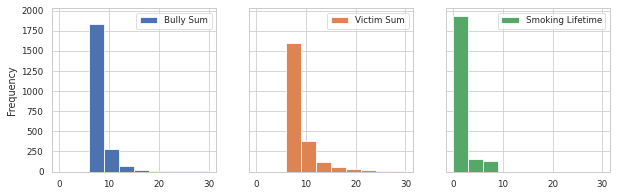

In [551]:
bully_cols = 'bully05 + bully06 + bully07 + bully08 + bully11 + bully12'.split(' + ')
victim_cols = 'bully01 + bully02 + bully03 + bully04 + bully09 + bully10'.split(' + ')

df_out = df_raw[bully_cols].sum(1)
df_out.name = 'Bully Sum'
df_out = df_out.to_frame()
df_out['Victim Sum'] = df_raw[victim_cols].sum(1)
df_out['Smoking Lifetime'] = df_raw['6']

df_out.plot.hist(subplots=True, sharey=True, layout=(1,3), figsize=(10,3))
plt.show() # @Milena 
# --> makes sense, as lowest score per bully item is 1

In [552]:
df_out['Session'] = tp
df_out

Bully Sum  Victim Sum  Smoking Lifetime Session
ID                                                       
1274              6          11                 0      BL
22453             7          10                 6      BL
75717             8           8                 6      BL
106601            6           8                 0      BL
106871            6           8                 0      BL
...             ...         ...               ...     ...
99873252          6           6                 2      BL
99875982          8           9                 0      BL
99888850          6           6                 0      BL
99930021          6           6                 0      BL
99954902          6           8                 0      BL

[2217 rows x 4 columns]

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  


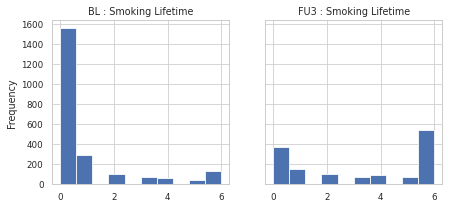

In [553]:
# add the FU3 smoking data
df_raw, tp, quest, formula = get_col_raw_df(47)
df_out2 = df_raw['6']
df_out2.name = 'Smoking Lifetime'
df_out2 = df_out2.to_frame()
df_out2['Session'] = tp
# print(len(df_out2))
df_out = df_out.append(df_out2)
# how did smoking behavior change from BL to FU3?
f, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(7,3))
for i, (session,g) in enumerate(df_out.groupby('Session')):
    g['Smoking Lifetime'].plot.hist(title=session+' : Smoking Lifetime', ax=axes[i])
plt.show()

In [554]:
df_out.to_csv(CONF_DATA_DIR+"all_ESPAD.csv")

##### all_ESPAD_Alc
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [354]:
#read the raw data
formulas=[]
for i, loc in enumerate([49,50,51,52,53]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


49 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq03, dmq05, dmq11, dmq14, dmq16
50 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq01, dmq04, dmq06, dmq15, dmq17
51 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq07, dmq09, dmq10, dmq13, dmq18
52 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq02, dmq08, dmq12, dmq19, dmq20
53 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + rapi07
+ rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23


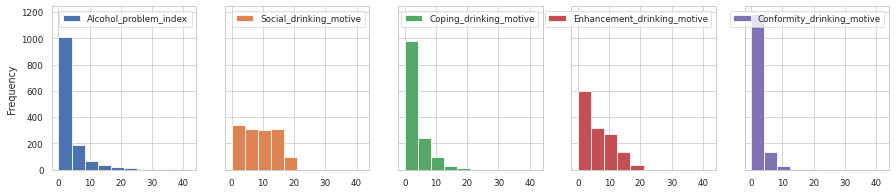

In [355]:
# prepare Alcohol_problem_index first
df_raw_rapi = df_raw["rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + \
rapi07 + rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + \
rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23".split(' + ')]
df_raw_rapi = df_raw_rapi.fillna(0) #@Milena --> correct
df_out = df_raw_rapi.sum(1)
df_out.name = 'Alcohol_problem_index'
df_out = df_out.to_frame()

# now the remaining 4
other_cols = [
("Social_drinking_motive", 'dmq03, dmq05, dmq11, dmq14, dmq16'.split(', ')),
("Coping_drinking_motive", 'dmq01, dmq04, dmq06, dmq15, dmq17'.split(', ')),
("Enhancement_drinking_motive", 'dmq07, dmq09, dmq10, dmq13, dmq18'.split(', ')),
("Conformity_drinking_motive", 'dmq02, dmq08, dmq12, dmq19, dmq20'.split(', ')), 
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.sum(1)
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,5), figsize=(15,3))
plt.show() # @Milena --> very skewed distributions, but makes sense as participants indicate mostly low alcohol problems (RAPI)
# and we see a plausible difference btw drinking motives (mostly social and enhancement, less coping and conformity, which might also be a social desirability effect)

In [356]:
df_out['Session'] = tp
df_out

Alcohol_problem_index  Social_drinking_motive  \
ID                                                        
112288                      3.0                     6.0   
215284                      1.0                     6.0   
240546                      1.0                    10.0   
297685                      4.0                     5.0   
308867                      0.0                    11.0   
...                         ...                     ...   
99677574                    0.0                     0.0   
99873252                    6.0                     9.0   
99875982                    3.0                     1.0   
99930021                    0.0                     0.0   
99954902                    4.0                     6.0   

          Coping_drinking_motive  Enhancement_drinking_motive  \
ID                                                              
112288                       0.0                          8.0   
215284                       1.0                          0.0   
240546                       1.0                          7.0   
297685                       1.0                          3.0   
308867                       1.0                          1.0   
...                          ...                          ...   
99677574                     0.0                          0.0   
99873252                     2.0                          7.0   
99875982                     0.0                          0.0   
99930021                     0.0                          0.0   
99954902                     1.0                          4.0   

          Conformity_drinking_motive Session  
ID                                            
112288                           0.0     FU3  
215284                           0.0     FU3  
240546                           1.0     FU3  
297685                           1.0     FU3  
308867                           0.0     FU3  
...                              ...     ...  
99677574                         0.0     FU3  
99873252                         0.0     FU3  
99875982                         0.0     FU3  
99930021                         0.0     FU3  
99954902                         2.0     FU3  

[1351 rows x 6 columns]

In [357]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')

##### all_Eating
* 58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv

In [400]:
#read the raw data of EDEQ first
formulas=[]
for i, loc in enumerate([58,59,60,61]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

58 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5)/5
59 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20)/5
60 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10,
EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11)/8
61 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12)/5


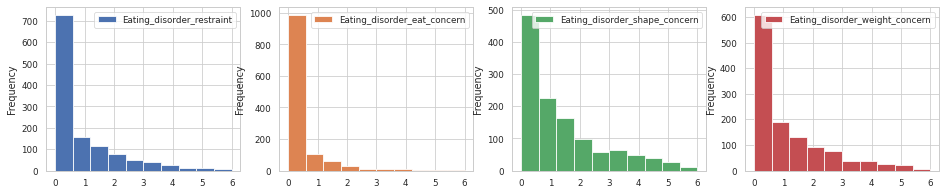

In [401]:
# prepare Eating_disorder_restraint first
df_raw_i = df_raw["EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5".split(', ')]
df_out = df_raw_i.mean(1)
df_out.name = 'Eating_disorder_restraint'
df_out = df_out.to_frame()
df_out

# now the remaining 3
other_cols = [
("Eating_disorder_eat_concern", 'EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20'.split(', ')),
("Eating_disorder_shape_concern", 'EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10, EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11'.split(', ')),
("Eating_disorder_weight_concern", 'EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12'.split(', '))
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.mean(1)
    
df_out.plot.hist(subplots=True,  layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as many people don't experience eating disorder related symptoms

In [402]:
#read the raw data of TFEQ first
formulas2=[]
for i, loc in enumerate([62,63,64]):
    df_raw2, tp, quest2, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old2==quest2
    formulas2.append(formula)
    tp_old=tp
    quest_old2=quest2
    print(loc, quest2, formula)

62 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15,
TFEQ_16,TFEQ_18) - 6] / 24 * 100
63 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7,
TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17) - 9] / 36 * 100
64 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_3, TFEQ_6, TFEQ_10) - 3] / 12 * 100


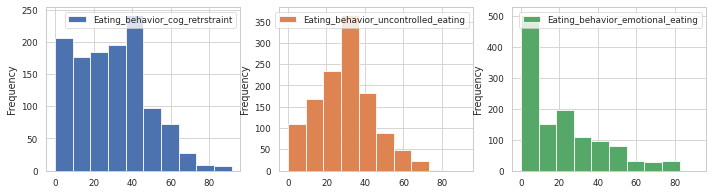

In [410]:
other_cols2 = [
("Eating_behavior_cog_retrstraint", 'TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15, TFEQ_16, TFEQ_18'.split(', ')),
("Eating_behavior_uncontrolled_eating", 'TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7, TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17'.split(', ')),
("Eating_behavior_emotional_eating", 'TFEQ_3, TFEQ_6, TFEQ_10'.split(', '))
]

for colname, cols in other_cols2:
    df_raw_i = df_raw2[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct; item 18 has to be recoded (from a scale of 8 to a scale of 4), I inserted the code below, is that correct?
    df_raw_i.loc[:,'TFEQ_18'] = df_raw_i['TFEQ_18'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:4,8:4})
    
    df_out[colname] = 100*(df_raw_i.sum(1)-len(cols))/(4*len(cols))
    
df_out[list(list(zip(*other_cols2))[0])].plot.hist(subplots=True, layout=(1,len(other_cols2)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as transformed to a scale from 0 - 100

In [411]:
df_out['Session'] = tp
df_out

Eating_disorder_restraint  Eating_disorder_eat_concern  \
ID                                                                 
112288                          0.0                          0.0   
215284                          1.6                          1.0   
240546                          0.4                          0.0   
297685                          1.8                          0.2   
308867                          0.0                          0.0   
...                             ...                          ...   
99616225                        2.8                          0.4   
99677574                        0.0                          0.0   
99873252                        1.6                          0.0   
99875982                        0.0                          0.0   
99954902                        0.0                          0.0   

          Eating_disorder_shape_concern  Eating_disorder_weight_concern  \
ID                                                                        
112288                            0.000                             0.8   
215284                            5.125                             4.0   
240546                            1.375                             0.8   
297685                            1.625                             0.4   
308867                            0.125                             0.2   
...                                 ...                             ...   
99616225                          3.625                             3.4   
99677574                          0.250                             0.0   
99873252                          1.500                             1.8   
99875982                          1.250                             1.0   
99954902                          0.625                             1.2   

          Eating_behavior_cog_retrstraint  \
ID                                          
112288                           0.000000   
215284                          50.000000   
240546                          37.500000   
297685                          29.166667   
308867                          41.666667   
...                                   ...   
99616225                        54.166667   
99677574                        12.500000   
99873252                        29.166667   
99875982                         8.333333   
99954902                        41.666667   

          Eating_behavior_uncontrolled_eating  \
ID                                              
112288                              55.555556   
215284                              27.777778   
240546                              36.111111   
297685                              30.555556   
308867                               8.333333   
...                                       ...   
99616225                             2.777778   
99677574                            22.222222   
99873252                            16.666667   
99875982                            11.111111   
99954902                            16.666667   

          Eating_behavior_emotional_eating Session  
ID                                                  
112288                            0.000000     FU3  
215284                           58.333333     FU3  
240546                           50.000000     FU3  
297685                           50.000000     FU3  
308867                            0.000000     FU3  
...                                    ...     ...  
99616225                          0.000000     FU3  
99677574                          8.333333     FU3  
99873252                          8.333333     FU3  
99875982                         16.666667     FU3  
99954902                          0.000000     FU3  

[1216 rows x 8 columns]

In [412]:
df_out.to_csv(CONF_DATA_DIR+'all_Eating.csv')

##### all_QOL
* 85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 86 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 87 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 88 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv

In [416]:
#read the raw data
formulas=[]
for i, loc in enumerate([85,86,87,88]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

85 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_1
86 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_2
87 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_3
88 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_4


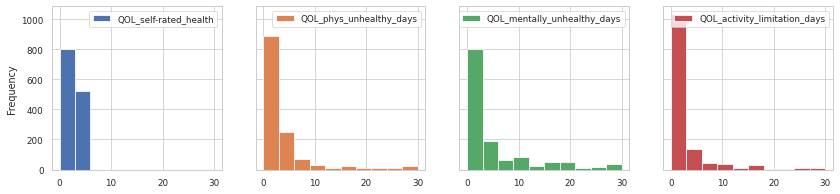

In [423]:
# prepare QOL_self-rated_health first
df_raw_i = df_raw["HRQOL_HDCM_1"]
df_raw_i.name = 'QOL_self-rated_health'
df_out = df_raw_i.to_frame()

# now the remaining 4
other_cols = [
("QOL_phys_unhealthy_days", 'HRQOL_HDCM_2'),
("QOL_mentally_unhealthy_days", 'HRQOL_HDCM_3'),
("QOL_activity_limitation_days", 'HRQOL_HDCM_4'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> the last three plots are plausible, as they refer to a max of 30 days per month. 
# The first variable is, however, measured on a scale from 1 (excellent health) to 5 (poor health). So the x-axis 
# limits should be chosen differently for the plot. But the values range itself looks plausible.

In [424]:
df_out['Session'] = tp
df_out

QOL_self-rated_health  QOL_phys_unhealthy_days  \
ID                                                         
112288                        1                        0   
215284                        5                       25   
240546                        1                        0   
297685                        2                        3   
308867                        2                        0   
...                         ...                      ...   
99677574                      2                        2   
99873252                      2                        1   
99875982                      2                        0   
99930021                      3                       15   
99954902                      2                       10   

          QOL_mentally_unhealthy_days  QOL_activity_limitation_days Session  
ID                                                                           
112288                              0                             0     FU3  
215284                              7                             4     FU3  
240546                              0                             0     FU3  
297685                              2                             2     FU3  
308867                              0                             0     FU3  
...                               ...                           ...     ...  
99677574                            0                             2     FU3  
99873252                            1                             0     FU3  
99875982                            0                             0     FU3  
99930021                            2                             8     FU3  
99954902                            6                             0     FU3  

[1324 rows x 5 columns]

In [425]:
df_out.to_csv(CONF_DATA_DIR+'all_QOL.csv')

##### all_CTS
* 111 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 112 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 113 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 114 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 115 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv

In [37]:
#read the raw data
formulas=[]
for i, loc in enumerate([111,112,113,114,115]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    print(loc, quest, formula)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest


111 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_assault
112 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_injury
113 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_negotiation
114 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_psychological_aggression
115 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_secual_coercion


In [38]:
df_raw_i = df_raw["cts_assault"]
df_raw_i.name = 'Parent Assault Mean'
df_out = df_raw_i.to_frame()
# df_out.info()

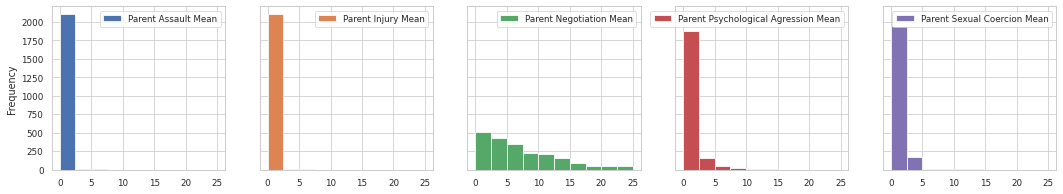

In [39]:
# now the remaining 4
other_cols = [
('Parent Injury Mean', 'cts_injury'),
('Parent Negotiation Mean', 'cts_negotiation'),
('Parent Psychological Agression Mean', 'cts_psychological_aggression'),
('Parent Sexual Coercion Mean', 'cts_sexual_coercion'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, sharex=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> plausible, as values represent means on a scale from 0 - 25 and certain types of behavior are very rare

In [40]:
df_out['Session'] = tp
df_out

Parent Assault Mean  Parent Injury Mean  Parent Negotiation Mean  \
ID                                                                           
1274                      0.0                 0.0                 4.500000   
22453                     0.0                 0.0                22.166667   
75717                     0.6                 0.0                 9.416667   
106601                    0.0                 0.0                 0.583333   
106871                    0.0                 0.0                 1.500000   
...                       ...                 ...                      ...   
99873252                  0.0                 0.0                 8.333333   
99875982                  0.0                 0.0                 4.916667   
99888850                  0.0                 0.0                 1.500000   
99930021                  0.0                 0.0                 3.833333   
99954902                  0.0                 0.0                10.583333   

          Parent Psychological Agression Mean  Parent Sexual Coercion Mean  \
ID                                                                           
1274                                    0.875                     0.000000   
22453                                   3.625                     4.166667   
75717                                  10.000                     0.000000   
106601                                  0.125                     0.000000   
106871                                  0.500                     0.000000   
...                                       ...                          ...   
99873252                                0.250                     0.000000   
99875982                                0.250                     0.000000   
99888850                                0.000                     0.000000   
99930021                                0.250                     0.000000   
99954902                                0.625                     2.083333   

         Session  
ID                
1274          BL  
22453         BL  
75717         BL  
106601        BL  
106871        BL  
...          ...  
99873252      BL  
99875982      BL  
99888850      BL  
99930021      BL  
99954902      BL  

[2114 rows x 6 columns]

In [54]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_CTS.csv')
df_old = df_old.drop(columns= [c for c in list(df_out.columns)+['Parent Psychological Agreesion Mean'] if c in df_old.columns and c not in ['ID','Session']])
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_CTS.csv')

##### all_GEN
* 117 BL /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv

In [453]:
#read the raw data
formulas=[]
for i, loc in enumerate([117]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

117 /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv Psych_History (recode yes = 1, no = 0)


In [454]:
df_raw_i = df_raw["Psych_History"].map({'YES':1, 'NO':0, 'DK':np.nan, 'RF':np.nan}) #@Milena is it ok that I can map DK and RF as nans? --> yes, good point!
df_raw_i.name = 'Parent Psychiatric Disorders History'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.value_counts(dropna=False)

Parent Psychiatric Disorders History  Session
1.0                                   BL         1104
0.0                                   BL         1032
NaN                                   BL           55
dtype: int64

In [455]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_GEN.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_GEN.csv')

## Analysis 0: prepare missing covariates (iter 2)
Check which covariates are still pending preprocessing

In [110]:
df_confs = pd.read_excel("Confounds_list_Milena_v2.xlsx")
df_confs = df_confs.loc[df_confs['questionnaire'].str.contains('\?\?\?') | df_confs['colname'].str.contains('\?\?\?')]
print("Rows that need to be preprocessed n =", len(df_confs))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i, df_confs)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

Rows that need to be preprocessed n = 19
33 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv
111 BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv
118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv


##### all_SDQ
* 33 BL /BL/dawba/IMAGEN_dawba_BL.tsv
* 108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv

In [176]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(33, df_confs)
print(quest, formula)
# df_raw

/BL/dawba/IMAGEN_dawba_BL.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [177]:
df_raw = df_raw.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [179]:
df_raw_i = df_raw["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out = df_raw_i.to_frame()

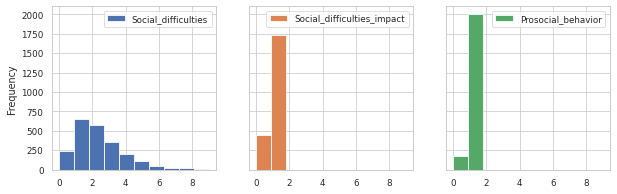

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 1274 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         2195 non-null   float64
 1   Social_difficulties_impact  2175 non-null   float64
 2   Prosocial_behavior          2175 non-null   float64
 3   Session                     2223 non-null   object 
dtypes: float64(3), object(1)
memory usage: 86.8+ KB


In [180]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]
for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
# @milena --> I adapted score calculation as I saw that the necessary variables are already included in the raw data file. Can you check if correct?
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out['Session'] = tp 
df_out.info() 

In [181]:
#read the raw data
df_raw2, tp, quest, formula = get_col_raw_df(108, df_confs)
print(quest, formula)
# df_raw2.columns

/FU3/dawba/IMAGEN_dawba_FU3.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


In [182]:
df_raw2 = df_raw2.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [183]:
df_raw_i = df_raw2["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out2 = df_raw_i.to_frame()
df_out2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Social_difficulties  1312 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


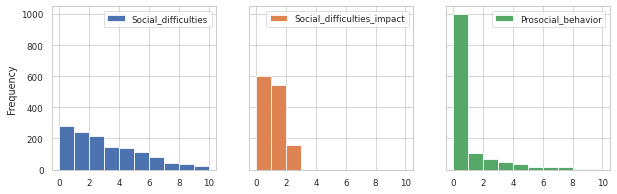

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         1312 non-null   float64
 1   Social_difficulties_impact  1305 non-null   float64
 2   Prosocial_behavior          1312 non-null   float64
 3   Session                     1315 non-null   object 
dtypes: float64(3), object(1)
memory usage: 51.4+ KB


In [184]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols]
df_out2['Session'] = tp 

df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out2.info()

In [185]:
df_out = df_out.append(df_out2)

In [186]:
df_out.to_csv(CONF_DATA_DIR+'all_SDQ.csv')

##### all_TLFB
* 34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv

In [570]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(34)
print(loc, quest, formula)

49 /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [579]:
# display(df_raw)
df_raw_i = df_raw["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw_i.name = 'Drugs Last Month'
df_out = df_raw_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out['Session'] = tp
# df_out.info()

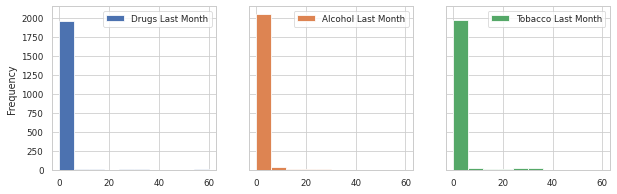

In [580]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [583]:
df_raw2, tp, quest, formula = get_col_raw_df(49)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [585]:
# display(df_raw)
df_raw2_i = df_raw2["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw2_i.name = 'Drugs Last Month'
df_out2 = df_raw2_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out2['Session'] = tp
# df_out2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 215284 to 99954902
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Drugs Last Month  1177 non-null   float64
 1   Session           1177 non-null   object 
dtypes: float64(1), object(1)
memory usage: 27.6+ KB


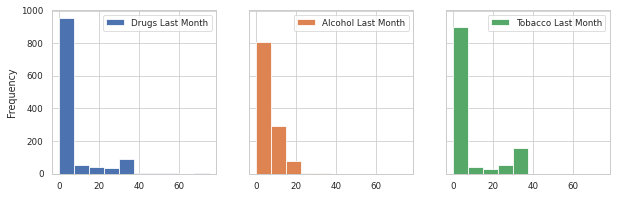

In [586]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [591]:
df_out = df_out.append(df_out2)
df_out.to_csv(CONF_DATA_DIR+'all_TLFB.csv')

##### all_CSI
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv

In [592]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(55)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv csi_sum


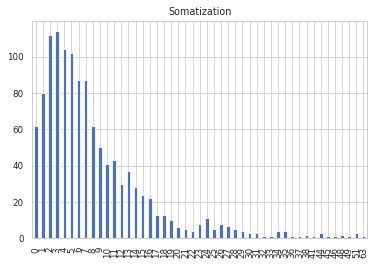

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Somatization  1217 non-null   int64 
 1   Session       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [594]:
df_raw_i = df_raw['csi_sum']
df_raw_i.name = 'Somatization'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena binarizing at median? --> lets try median first for consistency
df_out['Session'] = tp
df_out.info() 

In [595]:
df_out.to_csv(CONF_DATA_DIR+'all_CSI.csv')

##### all_IRI
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv

In [31]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(56, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv sum score = IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal


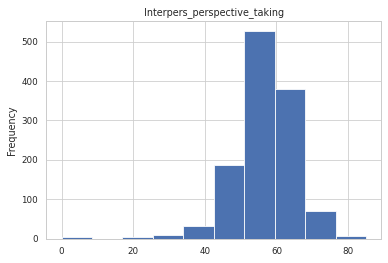

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Interpers_perspective_taking  1217 non-null   int64 
 1   Session                       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [32]:
df_raw_i = df_raw['IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal'.split(' + ')].sum(1)
df_raw_i.name = 'Interpers_perspective_taking'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena there are some outliers near 0 --> I would leave them in and try, as it's not unplausible that some people have very low scores.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [33]:
df_out.to_csv(CONF_DATA_DIR+'all_IRI.csv')

##### all_RRS
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv

In [25]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(57, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv sum score = sum(RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7,
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17,
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22


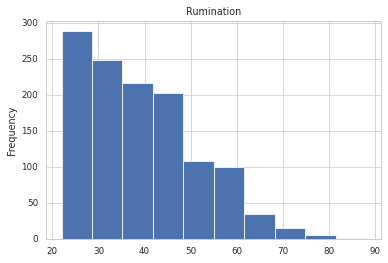

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rumination  1217 non-null   int64 
 1   Session     1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [26]:
df_raw_i = df_raw['RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7, \
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17, \
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22'.split(', ')].sum(1)
df_raw_i.name = 'Rumination'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena binary threshold median may not make sense?! --> I think it's the same as with all skewed distributions. Would stick with the median for consistency. 
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [27]:
df_out.to_csv(CONF_DATA_DIR+'all_RRS.csv')

##### all_VGS
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv

In [605]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(58, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv only consider item VideoGame_2_1d: In the PAST 12 MONTHS On how many days per
week did you play?


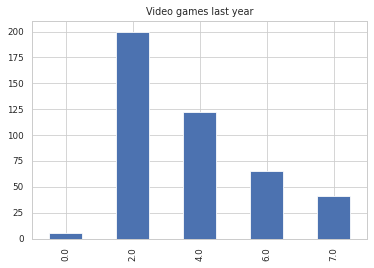

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Video games last year  433 non-null    float64
 1   Session                1214 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.5+ KB


In [608]:
df_raw_i = df_raw['VideoGame_2_1d']
df_raw_i.name = 'Video games last year'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> it would only make sense if values <= 2 are 0 and > 2 are 1.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [609]:
df_out.to_csv(CONF_DATA_DIR+'all_VGS.csv')

##### all_Urbanicity
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv

In [187]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(69, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv weighted sum score = sum((URBANICITY_city*3), (URBANICITY_town*2),(URBANICITY_rural*1))


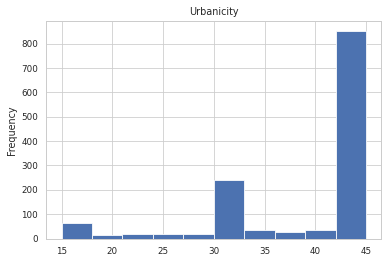

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Urbanicity  1327 non-null   float64
 1   Session     1327 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.1+ KB


In [191]:
df_raw_i = (df_raw['URBANICITY_city']*3 +  df_raw['URBANICITY_town']*2 +  df_raw['URBANICITY_rural']) 

df_raw_i.name = 'Urbanicity'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> there was a bug in sum score calculation, corrected it above :)
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [192]:
df_out.to_csv(CONF_DATA_DIR+'all_Urbanicity.csv')

##### all_WHO
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv

In [626]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(72, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv transformed sum score = sum(WHO5_1 to WHO5_5) * 4


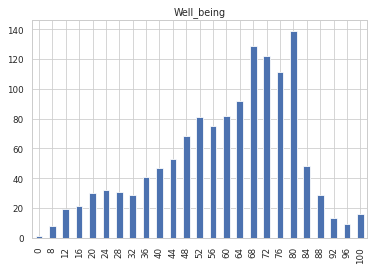

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Well_being  1326 non-null   int64 
 1   Session     1326 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [627]:
df_raw_i = df_raw.filter(regex='WHO').sum(1)*4 # @Milena is it x4 or x5? --> x4 is correct. This is done to bring it to a percentage scale (4 x max score of 25 is = 100).
df_raw_i.name = 'Well_being'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena should the binary threshold be greater than median or lower than median ? --> could again try the median first and then if it doesn't work well take the mean instead (which will be lower than median).
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [628]:
df_out.to_csv(CONF_DATA_DIR+'all_WHO.csv')

##### all_HF
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv

In [193]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(85, df_confs)
print(loc, quest, formula)
# df_raw.columns

122 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv sum score any physical condition = sum(HF_08 to HF_18)


In [195]:
# recode items
for col in ['HF_08', 'HF_09', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18']:
    df_raw[col] = df_raw[col].map({1:1,2:0,7: np.nan,9: np.nan})

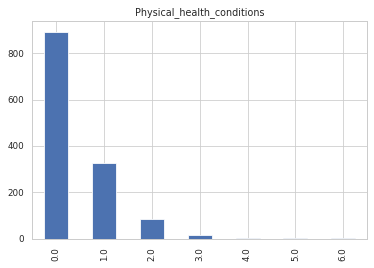

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Physical_health_conditions  1322 non-null   float64
 1   Session                     1322 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.0+ KB


In [196]:
df_raw_i = df_raw["'HF_08', 'HF_09', 'HF_10', 'HF_11', \
'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18'".replace("'","").split(", ")].sum(1)
df_raw_i.name = 'Physical_health_conditions'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena --> items have to be recoded so that 1 = 1, 2 = 0, 7 = NaN, 9 = NaN; inserted this in the cell above - can you check if correct?
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [197]:
df_out.to_csv(CONF_DATA_DIR+'all_HF.csv')

##### all_Par_ESPAD
111 https://matt.might.net/articles/phd-school-in-pictures/BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv

In [ ]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(111, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv sum of all dast items as global measure for drug abuse


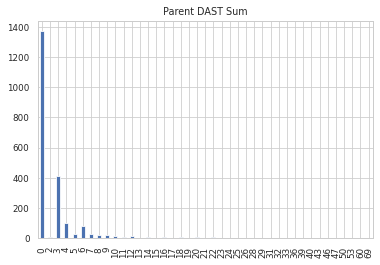

Parent DAST Sum Session
ID                               
1274                    0      BL
22453                   0      BL
75717                   0      BL
106601                  0      BL
106871                  0      BL
...                   ...     ...
99826568                0      BL
99873252                0      BL
99888850                0      BL
99930021                0      BL
99954902                3      BL

[2182 rows x 2 columns]

In [ ]:
df_raw_i = df_raw.filter(regex='dast_.*_sum').sum(1)
df_raw_i.name = 'Parent DAST Sum'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [ ]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_ESPADall_Par_ESPAD.csv')

##### all_PBQ
* 118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv

In [171]:
#read the raw data
formulas=[]
for i, loc in enumerate([118,119,120,121,122]):
    df_raw, tp, quest, formula = get_col_raw_df(loc, df_confs)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

118 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv sum(pbq_05a, pbq_05b, pbq_05c)
119 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_06a
120 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_10
121 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_11
122 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_12


In [172]:
df_raw_i = df_raw["pbq_05a, pbq_05b, pbq_05c".split(', ')].sum(1)
df_raw_i.name = 'Parent cigerattes during pregnancy'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
# df_out.info()

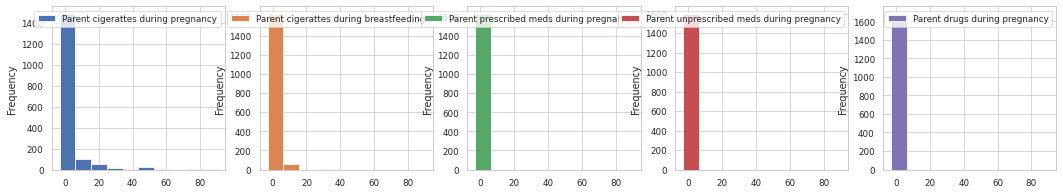

In [173]:
# now the remaining 4
other_cols = [
('Parent cigerattes during breastfeeding', 'pbq_06a'),
('Parent prescribed meds during pregnancy', 'pbq_10'),
('Parent unprescribed meds during pregnancy', 'pbq_11'),
('Parent drugs during pregnancy', 'pbq_12'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    if cols in ['pbq_10', 'pbq_11', 'pbq_12']: #@Milena for pbq_10, pbq_11 and pbq_12, negative values have to be coded as missing
        # display(df_out[colname].value_counts())
        df_out[colname] = df_out[colname].map({0:0, 1:1, -1:np.NaN,-2:np.NaN})
    else:   #@Milena missing as 0 --> correct; for all others
        df_out[colname] = df_out[colname].fillna(0)
        
df_out.plot.hist(subplots=True, sharey=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> low values are plausible

In [174]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 1274 to 99954902
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Parent cigerattes during pregnancy         1688 non-null   float64
 1   Session                                    1688 non-null   object 
 2   Parent cigerattes during breastfeeding     1688 non-null   float64
 3   Parent prescribed meds during pregnancy    1627 non-null   float64
 4   Parent unprescribed meds during pregnancy  1594 non-null   float64
 5   Parent drugs during pregnancy              1677 non-null   float64
dtypes: float64(5), object(1)
memory usage: 92.3+ KB


In [175]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_PBQ.csv').set_index(['ID','Session'])
df_out = df_out.reset_index().set_index(['ID','Session'])
df_old[df_out.columns] = df_out
df_old.reset_index().set_index('ID').to_csv(CONF_DATA_DIR+'all_PBQ.csv')

##### all_Par_AUDIT
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv

In [509]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(123, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv audit_total


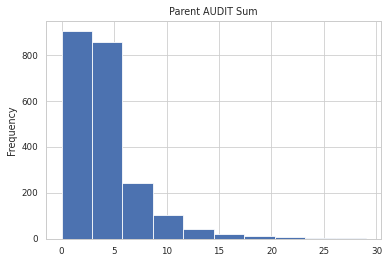

Parent AUDIT Sum Session
ID                                
1274                     3      BL
22453                    4      BL
75717                    2      BL
106601                   2      BL
106871                   2      BL
...                    ...     ...
99826568                 0      BL
99873252                 2      BL
99888850                 4      BL
99930021                 3      BL
99954902                 7      BL

[2182 rows x 2 columns]

In [510]:
df_raw_i = df_raw["audit_total"]
df_raw_i.name = 'Parent AUDIT Sum'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [511]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_AUDIT.csv')

##### all_ESPAD (bully)
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv

In [565]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(109, df_confs)
print(loc, quest, formula)

111 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10


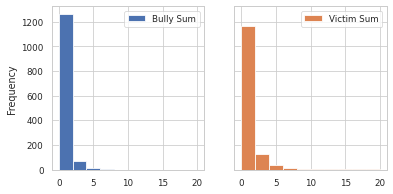

Bully Sum  Victim Sum Session
ID                                     
112288            0           0     FU3
215284            0           4     FU3
240546            0           2     FU3
297685            0           0     FU3
308867            0           0     FU3
...             ...         ...     ...
99677574          0           1     FU3
99873252          0           0     FU3
99875982          0           8     FU3
99930021          0           0     FU3
99954902          0           0     FU3

[1350 rows x 3 columns]

In [566]:
df_raw_i = df_raw["bully05 + bully06 + bully07 + bully08 + bully11 + bully12".split(' + ')].sum(1)
df_raw_i.name = 'Bully Sum'
df_out = df_raw_i.to_frame()

df_out['Victim Sum'] = df_raw["bully01 + bully02 + bully03 + bully04 + bully09 + bully10".split(' + ')].sum(1)

df_out['Session'] = tp

df_out.plot.hist(subplots=True, sharey=True, layout=(1,2), figsize=(4+2,3))
plt.show() # @Milena - is this the same as the 'all_ESPAD' file creation in analysis 0 iteration 1? And could you add 'df_out['Smoking Lifetime'] = df_raw['6']' for FU3 as well? (either here or in iteration 1?)

df_out

In [567]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD.csv').set_index('ID')
# df_old.loc[:,["Bully Sum","Victim Sum"]] = df_out.reset_index().set_index(['ID','Session'])
df_old.loc[df_old['Session']==tp, ["Bully Sum","Victim Sum"]] = df_out[["Bully Sum","Victim Sum"]]
df_old.to_csv(CONF_DATA_DIR+'all_ESPAD.csv')

## Main Analysis
Prepare all H5files and run the MLpipelines on 3 h5files:
1) fMRI FU3 --> FU3 binge drinking with confounds from FU3
2) fMRI BL 1 binge experience --> FU3 binge drinking with confounds from FU3 and BL
3) fMRI BL 0 binge experience --> FU3 binge drinking with confounds from FU3 and BL


### Load confounds and create h5files

In [198]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import KNNImputer

In [237]:
plot_dist = True
print_all = True
h5_name = 'h5causal1' # 'h5causal0' 'h5causal1', 'h5fu3'
h5_src = H5_FILES[h5_name] 

In [238]:
# ! rm -rvf $H5_DIR/posthoc-cc2*$h5_name*

In [239]:
# ! rm -rf ../MLpipelines/results/posthoc-cc2-*$h5_name*

-------------------  (0) Alc-lastmnt   ----------------------
Using Q collected at session-BL
imputing 752/2217 missing values with 0
range (min, mean, median, max) = (0.00, 0.60, 0.00, 6.00)


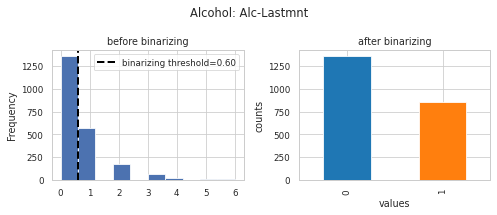

writing to .. posthoc-cc2-h5causal1-Alc-lastmnt.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (1) Alc-last12mnt   ----------------------
Using Q collected at session-BL
imputing 521/2217 missing values with 0
range (min, mean, median, max) = (0.00, 1.41, 1.00, 6.00)


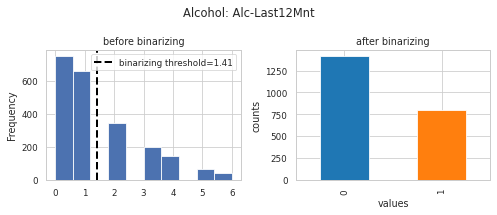

writing to .. posthoc-cc2-h5causal1-Alc-last12mnt.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (2) Neuroticism   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.33, 1.93, 1.92, 3.92)


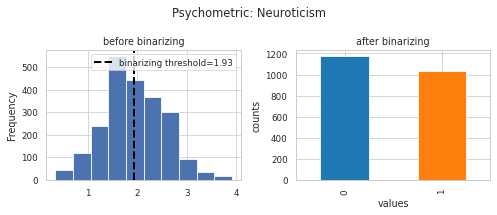

writing to .. posthoc-cc2-h5causal1-Neuroticism.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (3) Extroversion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.25, 2.50, 2.50, 3.92)


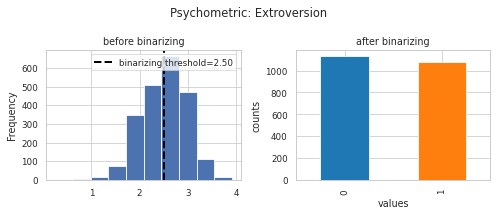

writing to .. posthoc-cc2-h5causal1-Extroversion.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (4) Conscientiousness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.30, 2.33, 4.00)


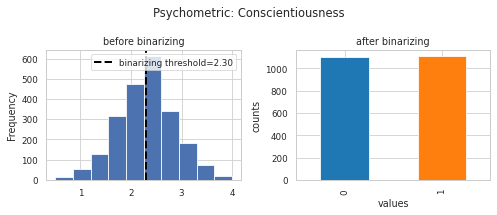

writing to .. posthoc-cc2-h5causal1-Conscientiousness.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (5) Family_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.26, 0.20, 1.00)


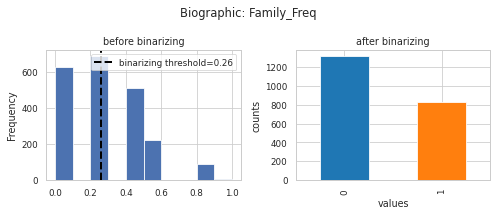

writing to .. posthoc-cc2-h5causal1-Family_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (6) Family_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.20, 1.60)


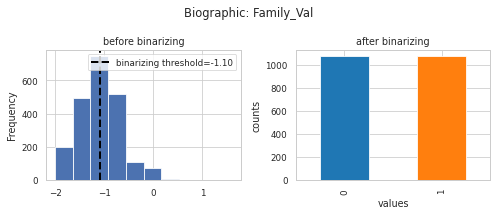

writing to .. posthoc-cc2-h5causal1-Family_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (7) Accident_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.52, 0.50, 1.00)


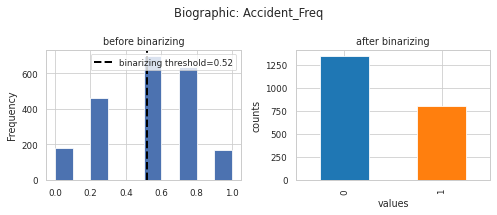

writing to .. posthoc-cc2-h5causal1-Accident_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (8) Accident_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.21, -1.25, 2.00)


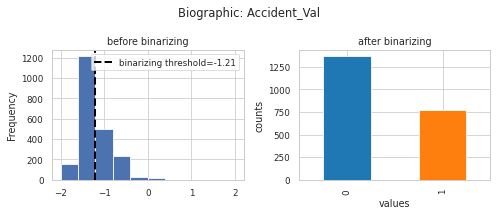

writing to .. posthoc-cc2-h5causal1-Accident_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (9) Sexuality_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.29, 0.29, 1.00)


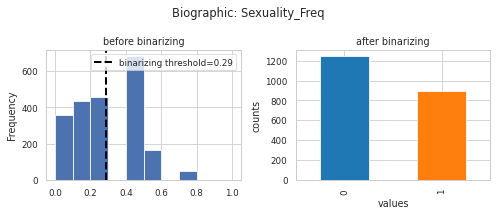

writing to .. posthoc-cc2-h5causal1-Sexuality_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (10) Sexuality_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.43, -0.04, 0.00, 1.71)


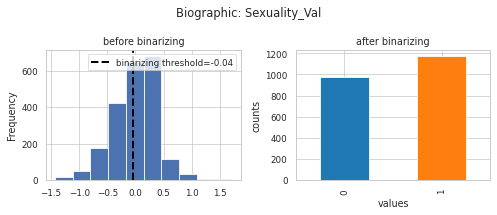

writing to .. posthoc-cc2-h5causal1-Sexuality_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (11) Autonomy_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.53, 0.50, 1.00)


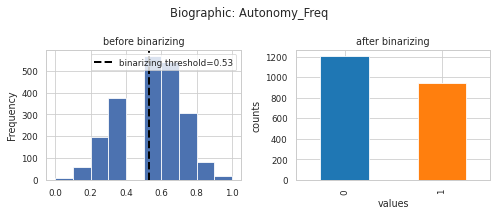

writing to .. posthoc-cc2-h5causal1-Autonomy_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (12) Autonomy_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.00, 1.00, 1.00, 2.00)


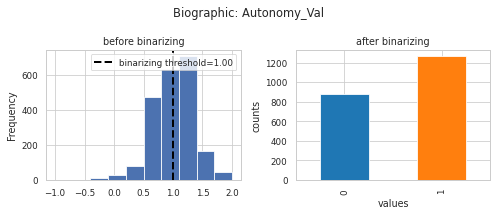

writing to .. posthoc-cc2-h5causal1-Autonomy_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (13) Deviance_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.27, 0.33, 1.00)


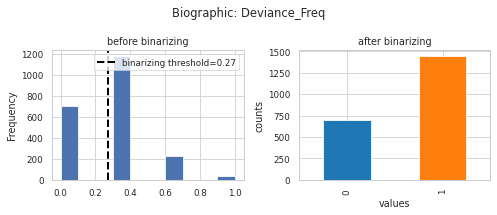

writing to .. posthoc-cc2-h5causal1-Deviance_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (14) Deviance_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.00, -1.00, 2.00)


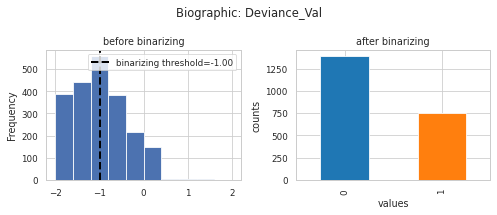

writing to .. posthoc-cc2-h5causal1-Deviance_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (15) Relocation_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.44, 0.33, 1.00)


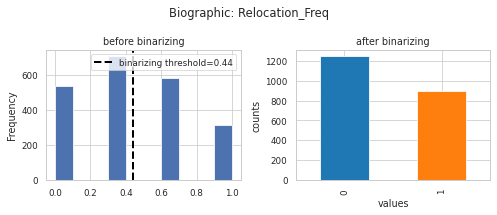

writing to .. posthoc-cc2-h5causal1-Relocation_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (16) Relocation_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -0.38, -0.33, 2.00)


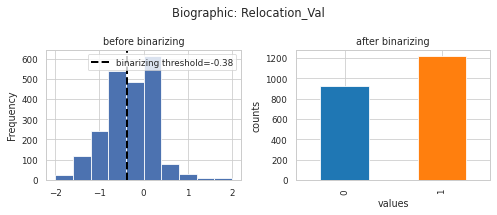

writing to .. posthoc-cc2-h5causal1-Relocation_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (17) Distress_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.28, 0.33, 1.00)


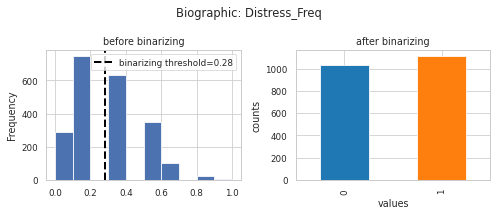

writing to .. posthoc-cc2-h5causal1-Distress_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (18) Distress_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.17, 2.00)


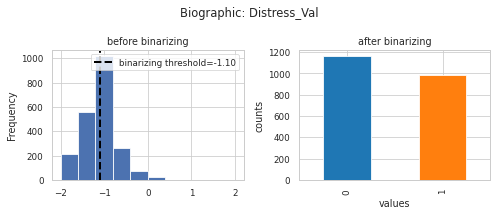

writing to .. posthoc-cc2-h5causal1-Distress_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (19) Total_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.03, 0.37, 0.36, 0.79)


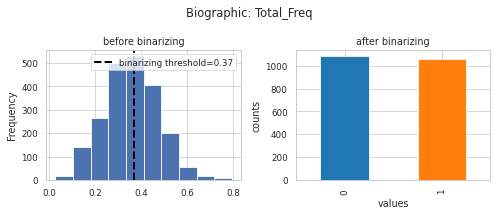

writing to .. posthoc-cc2-h5causal1-Total_freq.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (20) Total_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.10, -0.33, -0.33, 1.59)


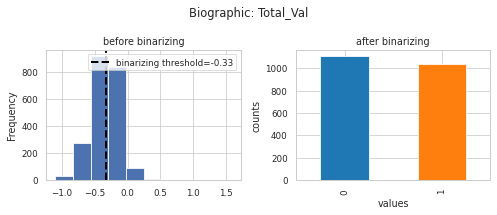

writing to .. posthoc-cc2-h5causal1-Total_val.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (21) Age_first_drunk   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (11.00, 15.42, 15.00, 21.00)


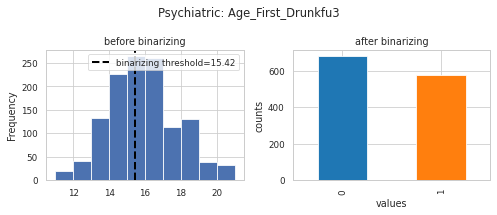

writing to .. posthoc-cc2-h5causal1-Age_first_drunkFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (22) Drug_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.00, 0.00, 0.00)


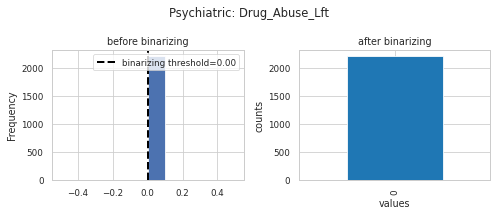

writing to .. posthoc-cc2-h5causal1-Drug_abuse_lft.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (23) Nicotine_dependence   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.08, 0.00, 10.00)


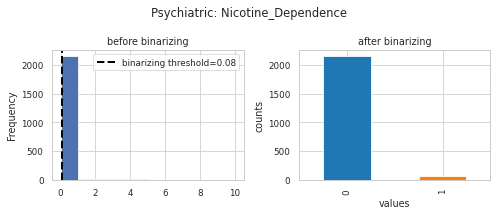

writing to .. posthoc-cc2-h5causal1-Nicotine_dependence.h5
attaching conf Nicotine_dependence
[ERROR] Failed to create h5: the value 1 in Nicotine_dependence has fewer than 15% instances (n=4)
This is very small for counter balancing to work properly..
-------------------  (24) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.03, 0.00, 1.00)


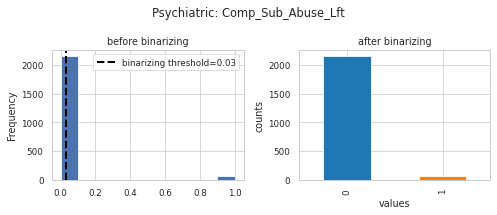

writing to .. posthoc-cc2-h5causal1-Comp_sub_abuse_lft.h5
attaching conf Comp_sub_abuse_lft
[ERROR] Failed to create h5: the value 1 in Comp_sub_abuse_lft has fewer than 15% instances (n=4)
This is very small for counter balancing to work properly..
-------------------  (25) Novelty_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (75.00, 111.47, 111.00, 152.00)


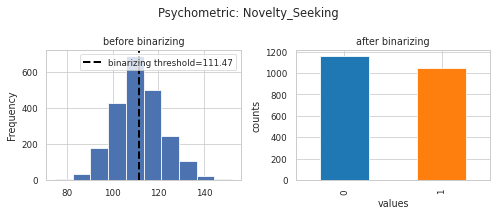

writing to .. posthoc-cc2-h5causal1-Novelty_seeking.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (26) Anxiety_sensitivity   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.26, 2.20, 4.00)


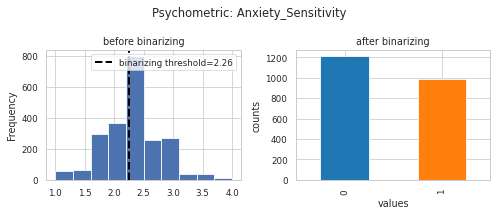

writing to .. posthoc-cc2-h5causal1-Anxiety_sensitivity.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (27) Hopelessness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 1.87, 1.86, 4.00)


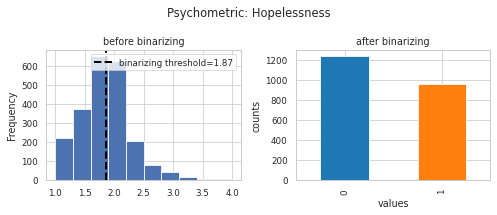

writing to .. posthoc-cc2-h5causal1-Hopelessness.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (28) Impulsivity_SURPS   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.45, 2.40, 4.00)


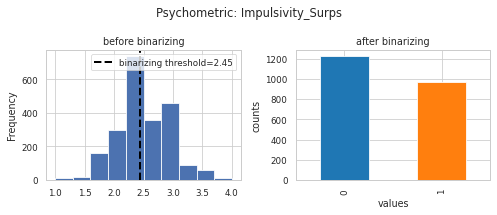

writing to .. posthoc-cc2-h5causal1-Impulsivity_SURPS.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (29) Sensation_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.70, 2.67, 4.00)


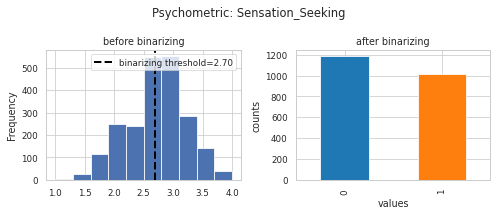

writing to .. posthoc-cc2-h5causal1-Sensation_seeking.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (30) Physical_developmet   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 23.17, 20.00, 38.00)


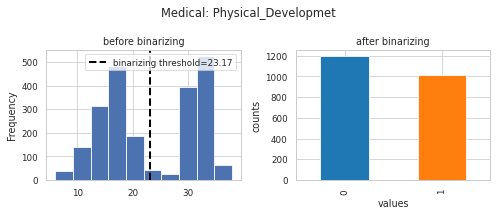

writing to .. posthoc-cc2-h5causal1-Physical_developmet.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (31) Bullying   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 7.30, 6.00, 30.00)


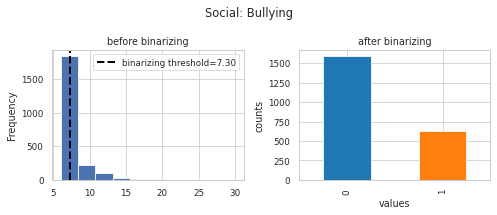

writing to .. posthoc-cc2-h5causal1-Bullying.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (32) Bullying_victim   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 8.16, 7.00, 30.00)


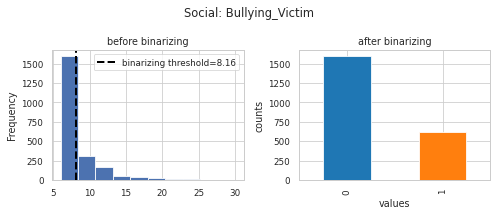

writing to .. posthoc-cc2-h5causal1-Bullying_victim.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (33) Social_difficulties   ----------------------
Using Q collected at session-BL
imputing 28/2223 missing values with 0
range (min, mean, median, max) = (0.00, 2.10, 2.00, 9.00)


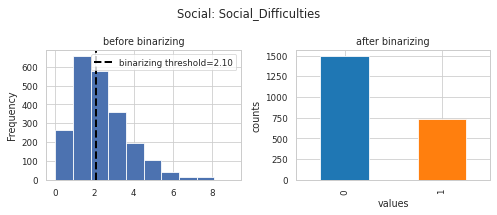

writing to .. posthoc-cc2-h5causal1-Social_difficulties.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (34) Social_difficulties_impact   ----------------------
Using Q collected at session-BL
imputing 48/2223 missing values with 0
range (min, mean, median, max) = (0.00, 0.78, 1.00, 1.00)


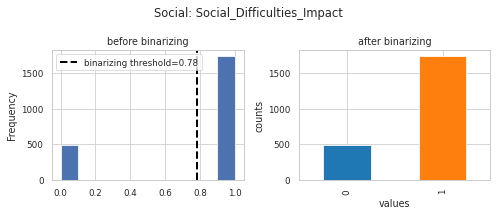

writing to .. posthoc-cc2-h5causal1-Social_difficulties_impact.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (35) Prosocial_behavior   ----------------------
Using Q collected at session-BL
imputing 48/2223 missing values with 0
range (min, mean, median, max) = (0.00, 0.90, 1.00, 1.00)


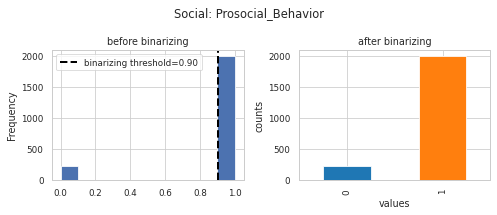

writing to .. posthoc-cc2-h5causal1-Prosocial_behavior.h5
attaching conf Prosocial_behavior
[ERROR] Failed to create h5: the value 0 in Prosocial_behavior has fewer than 15% instances (n=47)
This is very small for counter balancing to work properly..
-------------------  (36) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 36/2132 missing values with 0
range (min, mean, median, max) = (0.00, 0.69, 0.00, 26.00)


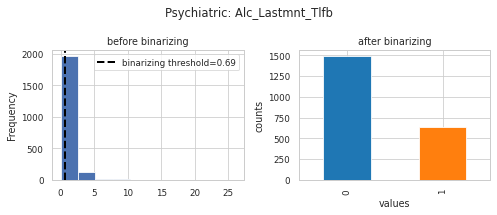

writing to .. posthoc-cc2-h5causal1-Alc_lastmnt_TLFB.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (37) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 69/2132 missing values with 0
range (min, mean, median, max) = (0.00, 0.95, 0.00, 30.00)


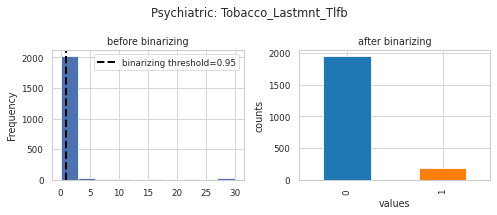

writing to .. posthoc-cc2-h5causal1-Tobacco_lastmnt_TLFB.h5
attaching conf Tobacco_lastmnt_TLFB
[ERROR] Failed to create h5: the value 1 in Tobacco_lastmnt_TLFB has fewer than 15% instances (n=23)
This is very small for counter balancing to work properly..
-------------------  (38) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 146/2132 missing values with 0
range (min, mean, median, max) = (0.00, 0.25, 0.00, 60.00)


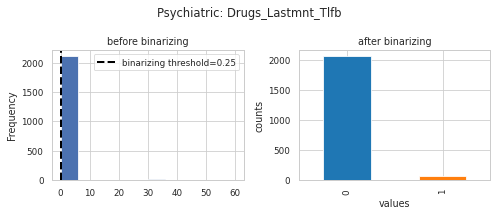

writing to .. posthoc-cc2-h5causal1-Drugs_lastmnt_TLFB.h5
attaching conf Drugs_lastmnt_TLFB
[ERROR] Failed to create h5: the value 1 in Drugs_lastmnt_TLFB has fewer than 15% instances (n=11)
This is very small for counter balancing to work properly..
-------------------  (39) Smoking_lifetime   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.83, 0.00, 6.00)


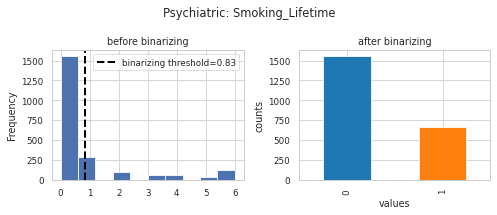

writing to .. posthoc-cc2-h5causal1-Smoking_lifetime.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (40) Smoking_lifetime   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.27, 4.00, 6.00)


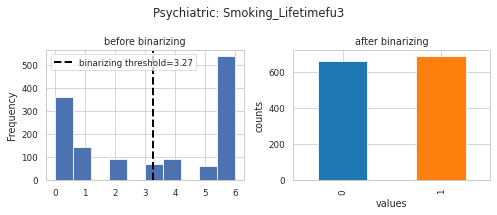

writing to .. posthoc-cc2-h5causal1-Smoking_lifetimeFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (41) Alc-lastmnt   ----------------------
Using Q collected at session-FU3
imputing 59/1351 missing values with 0
range (min, mean, median, max) = (0.00, 2.31, 2.00, 6.00)


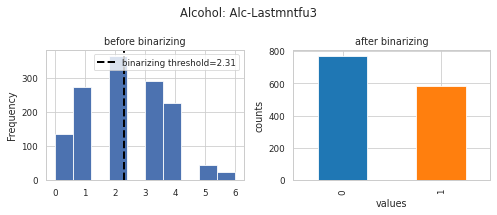

writing to .. posthoc-cc2-h5causal1-Alc-lastmntFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (42) Alc-last12mnt   ----------------------
Using Q collected at session-FU3
imputing 25/1351 missing values with 0
range (min, mean, median, max) = (0.00, 4.48, 5.00, 6.00)


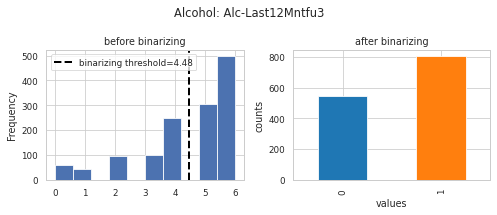

writing to .. posthoc-cc2-h5causal1-Alc-last12mntFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (43) Neuroticism   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.77, 1.75, 4.00)


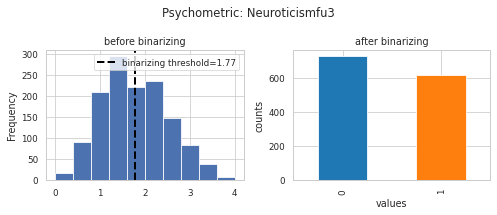

writing to .. posthoc-cc2-h5causal1-NeuroticismFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (44) Extroversion   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.67, 2.40, 2.42, 3.75)


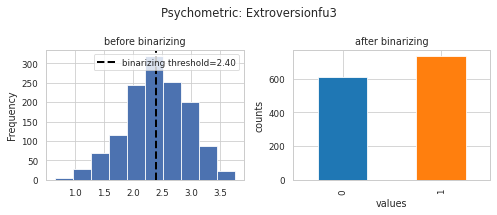

writing to .. posthoc-cc2-h5causal1-ExtroversionFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (45) Conscientiousness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.50, 2.62, 2.67, 3.92)


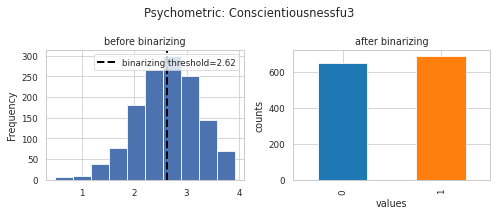

writing to .. posthoc-cc2-h5causal1-ConscientiousnessFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (46) Anxiety_sensitivity   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.34, 2.40, 4.00)


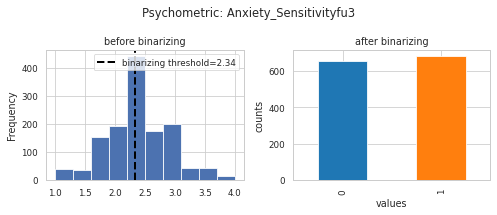

writing to .. posthoc-cc2-h5causal1-Anxiety_sensitivityFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (47) Hopelessness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.43, 2.93, 2.86, 3.71)


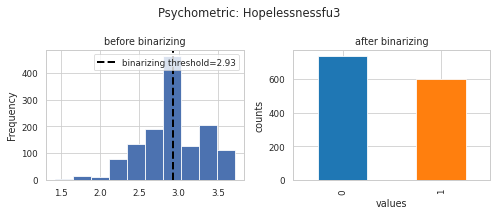

writing to .. posthoc-cc2-h5causal1-HopelessnessFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (48) Impulsivity_SURPS   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.13, 2.20, 4.00)


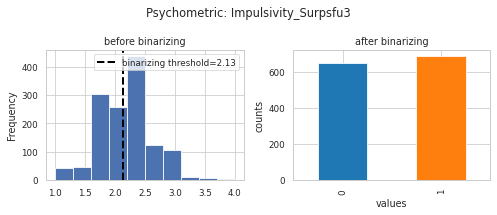

writing to .. posthoc-cc2-h5causal1-Impulsivity_SURPSFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (49) Sensation_seeking   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.74, 2.83, 4.00)


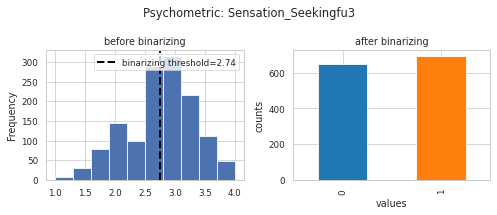

writing to .. posthoc-cc2-h5causal1-Sensation_seekingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (50) Drug_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.03, 0.00, 3.00)


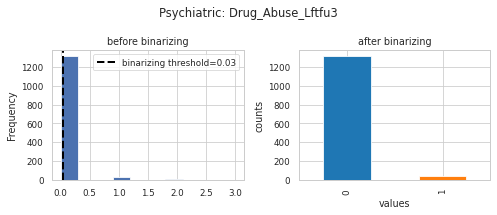

writing to .. posthoc-cc2-h5causal1-Drug_abuse_lftFU3.h5
attaching conf Drug_abuse_lftFU3
[ERROR] Failed to create h5: the value 1 in Drug_abuse_lftFU3 has fewer than 15% instances (n=11)
This is very small for counter balancing to work properly..
-------------------  (51) Nicotine_dependence   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.39, 0.00, 7.00)


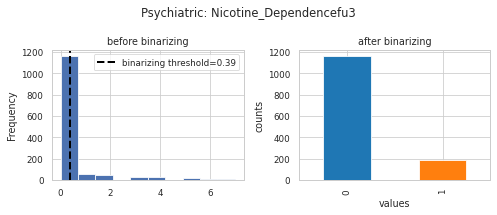

writing to .. posthoc-cc2-h5causal1-Nicotine_dependenceFU3.h5
attaching conf Nicotine_dependenceFU3
[ERROR] Failed to create h5: the value 1 in Nicotine_dependenceFU3 has fewer than 15% instances (n=73)
This is very small for counter balancing to work properly..
-------------------  (52) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.23, 0.00, 1.00)


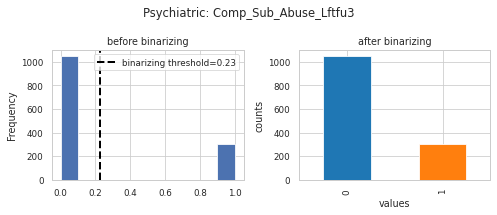

writing to .. posthoc-cc2-h5causal1-Comp_sub_abuse_lftFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (53) Smoking_lifetime   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.27, 4.00, 6.00)


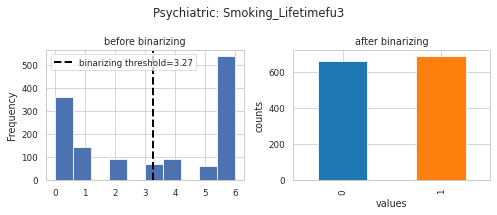

writing to .. posthoc-cc2-h5causal1-Smoking_lifetimeFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (54) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.03, 5.00, 30.00)


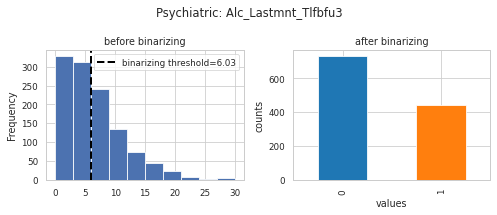

writing to .. posthoc-cc2-h5causal1-Alc_lastmnt_TLFBFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (55) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.46, 0.00, 30.00)


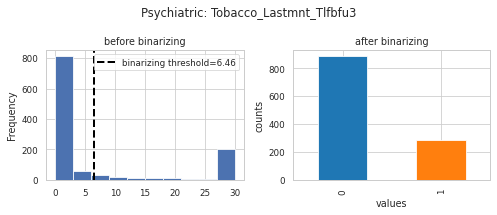

writing to .. posthoc-cc2-h5causal1-Tobacco_lastmnt_TLFBFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (56) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 5.32, 0.00, 75.00)


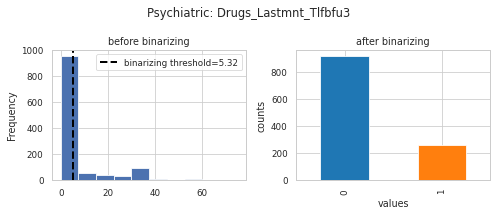

writing to .. posthoc-cc2-h5causal1-Drugs_lastmnt_TLFBFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (57) Social_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.80, 9.00, 20.00)


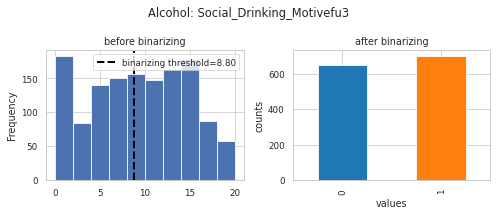

writing to .. posthoc-cc2-h5causal1-Social_drinking_motiveFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (58) Coping_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.15, 2.00, 20.00)


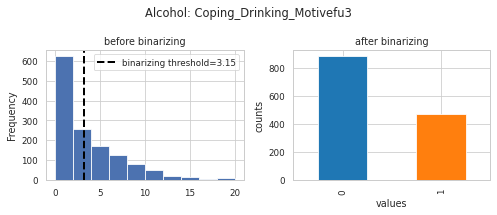

writing to .. posthoc-cc2-h5causal1-Coping_drinking_motiveFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (59) Enhancement_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.12, 5.00, 20.00)


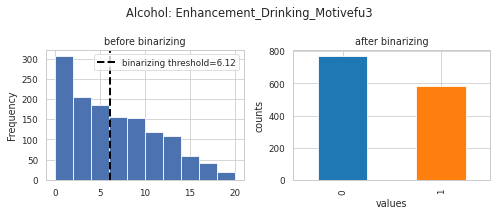

writing to .. posthoc-cc2-h5causal1-Enhancement_drinking_motiveFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (60) Conformity_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.53, 0.00, 18.00)


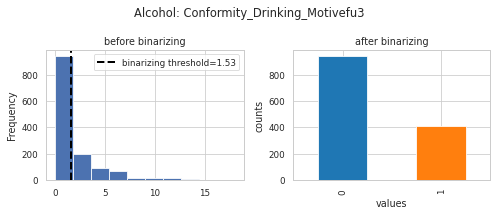

writing to .. posthoc-cc2-h5causal1-Conformity_drinking_motiveFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (61) Alcohol_problem_index   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.51, 1.00, 42.00)


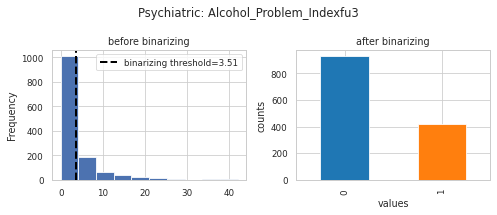

writing to .. posthoc-cc2-h5causal1-Alcohol_problem_indexFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (62) Somatization   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.18, 6.00, 63.00)


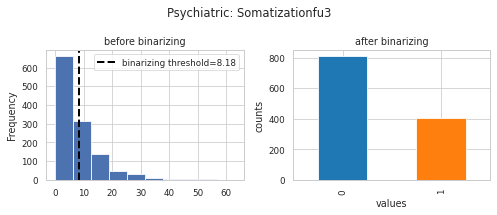

writing to .. posthoc-cc2-h5causal1-SomatizationFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (63) Interpers_perspective_taking   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 56.61, 57.00, 85.00)


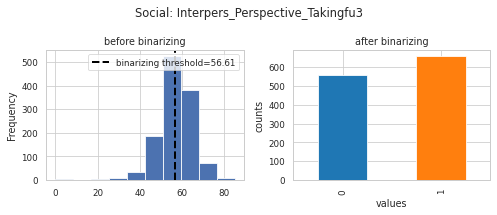

writing to .. posthoc-cc2-h5causal1-Interpers_perspective_takingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (64) Rumination   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (22.00, 39.01, 37.00, 88.00)


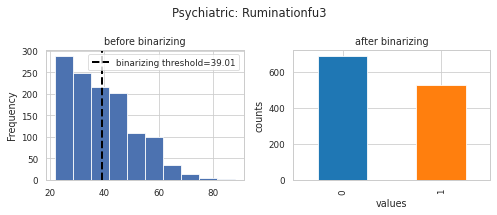

writing to .. posthoc-cc2-h5causal1-RuminationFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (65) Video_gaming_addiction   ----------------------
Using Q collected at session-FU3
imputing 781/1214 missing values with 0
range (min, mean, median, max) = (0.00, 1.29, 0.00, 7.00)


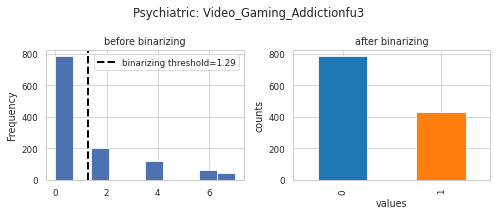

writing to .. posthoc-cc2-h5causal1-Video_gaming_addictionFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (66) Eating_disorder_restraint   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.79, 0.20, 6.00)


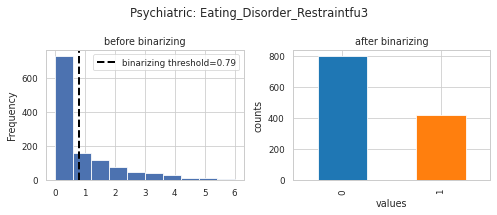

writing to .. posthoc-cc2-h5causal1-Eating_disorder_restraintFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (67) Eating_disorder_eat_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.35, 0.00, 5.60)


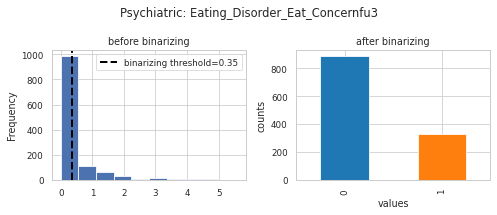

writing to .. posthoc-cc2-h5causal1-Eating_disorder_eat_concernFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (68) Eating_disorder_shape_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.34, 0.88, 6.00)


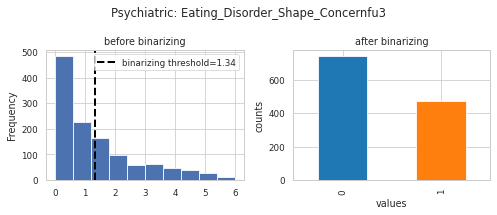

writing to .. posthoc-cc2-h5causal1-Eating_disorder_shape_concernFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (69) Eating_disorder_weight_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.03, 0.60, 6.00)


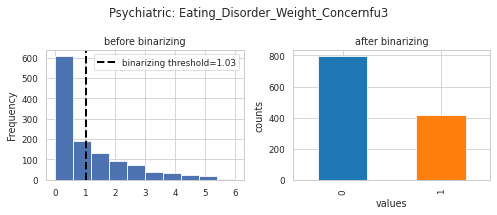

writing to .. posthoc-cc2-h5causal1-Eating_disorder_weight_concernFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (70) Eating_behavior_cog_retrstraint   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 29.91, 29.17, 91.67)


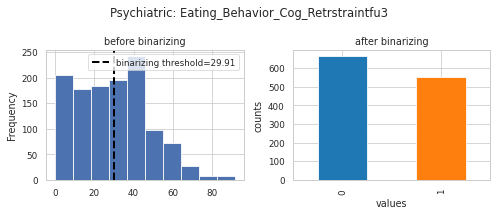

writing to .. posthoc-cc2-h5causal1-Eating_behavior_cog_retrstraintFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (71) Eating_behavior_uncontrolled_eating   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 29.71, 27.78, 75.00)


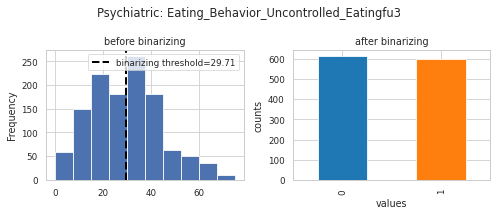

writing to .. posthoc-cc2-h5causal1-Eating_behavior_uncontrolled_eatingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (72) Eating_behavior_emotional_eating   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 21.29, 16.67, 75.00)


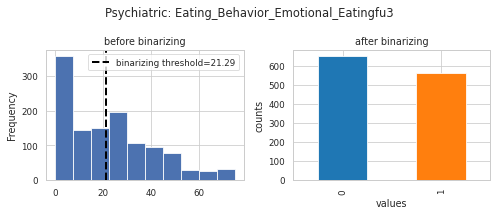

writing to .. posthoc-cc2-h5causal1-Eating_behavior_emotional_eatingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (73) Psychotic_experience   ----------------------
Using Q collected at session-FU3
imputing 1/1333 missing values with 0
range (min, mean, median, max) = (0.00, 60.21, 58.00, 112.00)


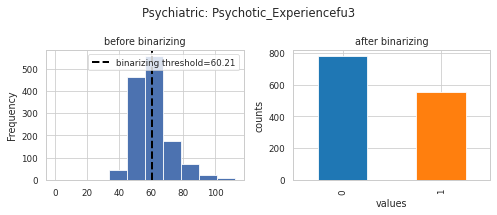

writing to .. posthoc-cc2-h5causal1-Psychotic_experienceFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (74) Impulsivity_BIS   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (39.00, 61.95, 61.50, 102.00)


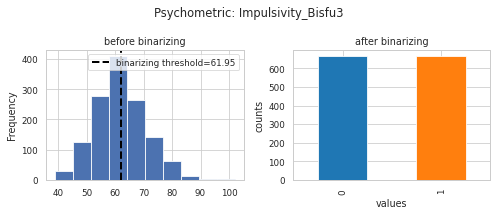

writing to .. posthoc-cc2-h5causal1-Impulsivity_BISFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (75) Anxiety   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 7.33, 5.00, 48.00)


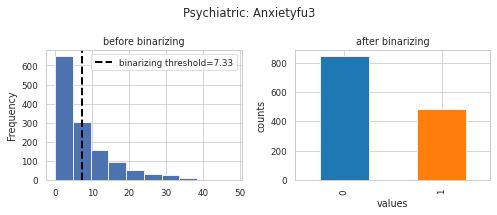

writing to .. posthoc-cc2-h5causal1-AnxietyFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (76) Urbanicity   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (15.00, 39.05, 45.00, 45.00)


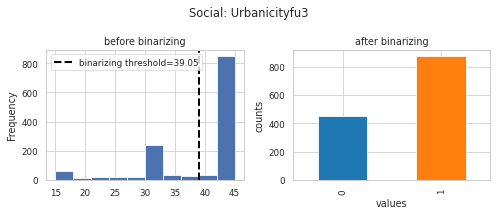

writing to .. posthoc-cc2-h5causal1-UrbanicityFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (77) Depression_CESD   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (22.00, 36.43, 35.00, 72.00)


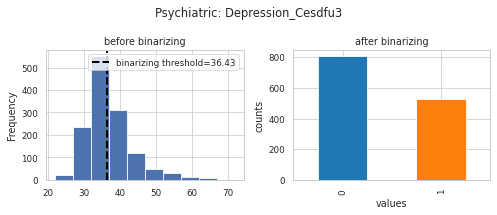

writing to .. posthoc-cc2-h5causal1-Depression_CESDFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (78) Stress   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 12.63, 12.00, 34.00)


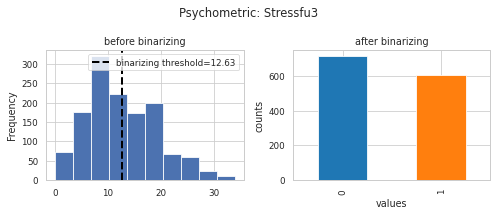

writing to .. posthoc-cc2-h5causal1-StressFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (79) Well_being   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 59.82, 64.00, 100.00)


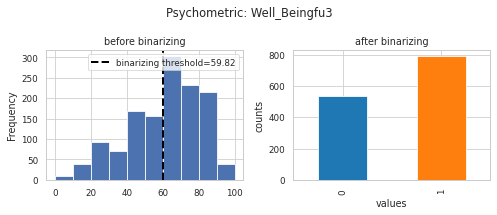

writing to .. posthoc-cc2-h5causal1-Well_beingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (80) Somatization_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.25, 0.14, 3.71)


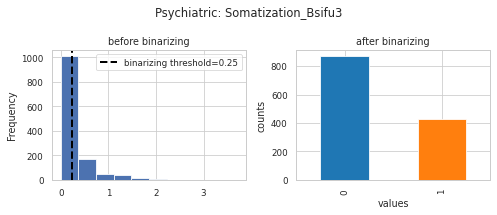

writing to .. posthoc-cc2-h5causal1-Somatization_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (81) Obsession_compulsion_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.59, 0.33, 3.50)


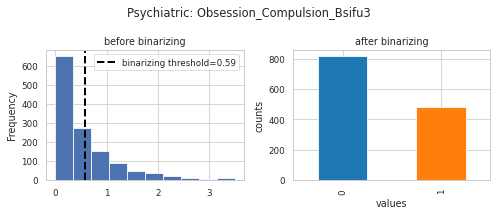

writing to .. posthoc-cc2-h5causal1-Obsession_compulsion_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (82) Interpers_sensitivity_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.46, 0.25, 4.00)


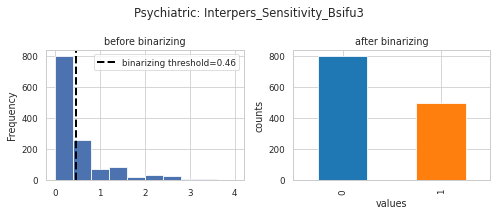

writing to .. posthoc-cc2-h5causal1-Interpers_sensitivity_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (83) Depression_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.44, 0.17, 4.00)


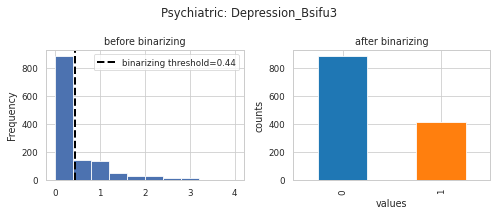

writing to .. posthoc-cc2-h5causal1-Depression_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (84) Anxiety_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.34, 0.17, 3.50)


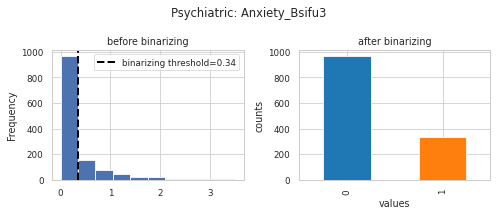

writing to .. posthoc-cc2-h5causal1-Anxiety_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (85) Hostility_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.37, 0.20, 3.00)


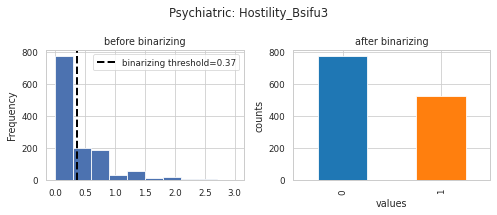

writing to .. posthoc-cc2-h5causal1-Hostility_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (86) Phobic_anxiety_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.17, 0.00, 3.40)


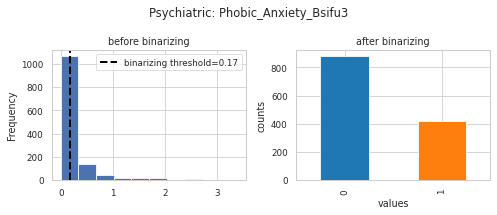

writing to .. posthoc-cc2-h5causal1-Phobic_anxiety_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (87) Paranoid_ideation_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.33, 0.20, 4.00)


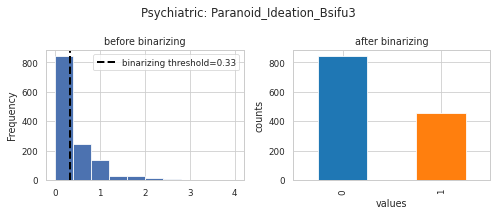

writing to .. posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (88) Psychoticism_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.27, 0.00, 3.00)


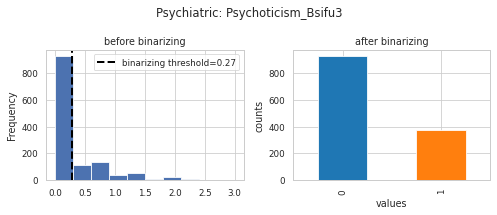

writing to .. posthoc-cc2-h5causal1-Psychoticism_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (89) GSI_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.36, 0.20, 2.82)


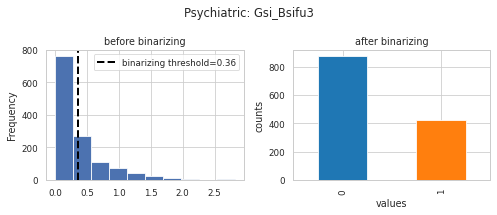

writing to .. posthoc-cc2-h5causal1-GSI_BSIFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (90) Positive_affect   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (10.00, 26.66, 25.00, 50.00)


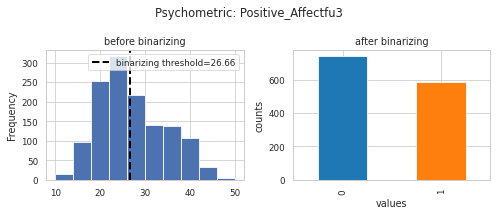

writing to .. posthoc-cc2-h5causal1-Positive_affectFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (91) Negative_affect   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (10.00, 20.80, 21.00, 41.00)


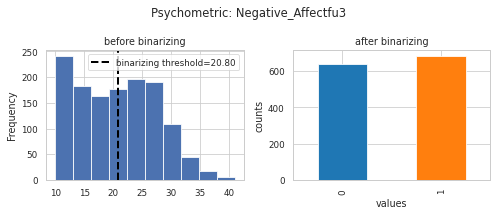

writing to .. posthoc-cc2-h5causal1-Negative_affectFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (92) Physical_health_conditions   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.42, 0.00, 6.00)


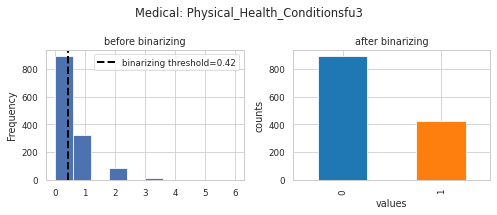

writing to .. posthoc-cc2-h5causal1-Physical_health_conditionsFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (93) QOL_self-rated_health   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.35, 2.00, 5.00)


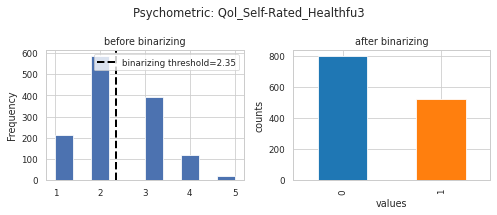

writing to .. posthoc-cc2-h5causal1-QOL_self-rated_healthFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (94) QOL_phys_unhealthy_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 2.94, 1.00, 30.00)


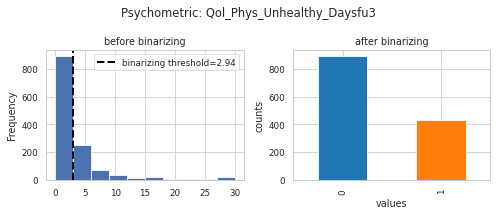

writing to .. posthoc-cc2-h5causal1-QOL_phys_unhealthy_daysFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (95) QOL_mentally_unhealthy_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 4.61, 1.00, 30.00)


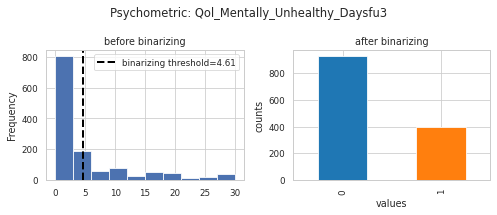

writing to .. posthoc-cc2-h5causal1-QOL_mentally_unhealthy_daysFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (96) QOL_activity_limitation_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 2.19, 0.00, 30.00)


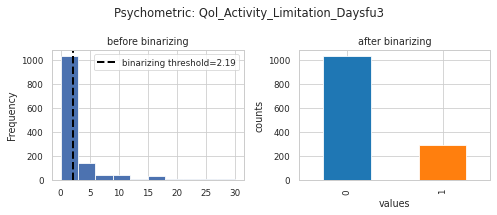

writing to .. posthoc-cc2-h5causal1-QOL_activity_limitation_daysFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (97) Depression_K6+   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (6.00, 25.36, 27.00, 30.00)


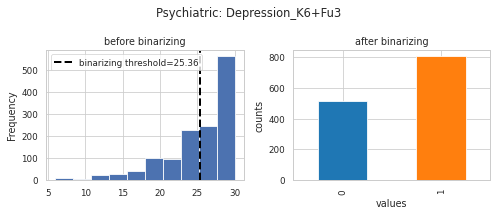

writing to .. posthoc-cc2-h5causal1-Depression_K6+FU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (98) Family_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.17, 0.20, 0.80)


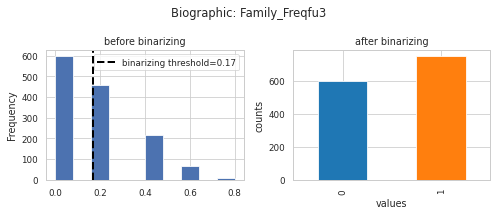

writing to .. posthoc-cc2-h5causal1-Family_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (99) Family_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-2.00, -0.39, -0.40, 2.00)


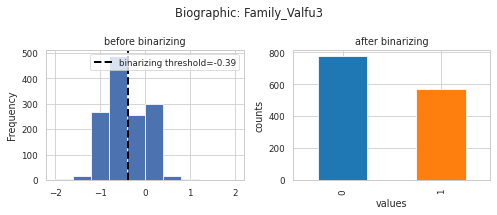

writing to .. posthoc-cc2-h5causal1-Family_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (100) Accident_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.24, 0.25, 0.75)


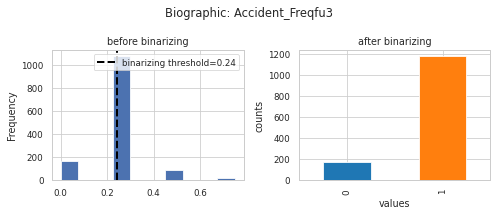

writing to .. posthoc-cc2-h5causal1-Accident_freqFU3.h5
attaching conf Accident_freqFU3
[ERROR] Failed to create h5: the value 0 in Accident_freqFU3 has fewer than 15% instances (n=74)
This is very small for counter balancing to work properly..
-------------------  (101) Accident_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-2.00, 0.54, 0.50, 1.50)


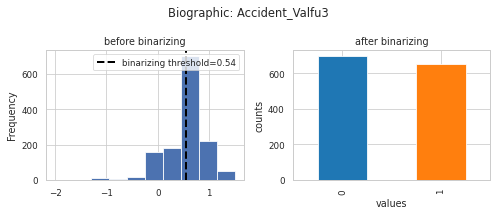

writing to .. posthoc-cc2-h5causal1-Accident_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (102) Sexuality_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.26, 0.29, 0.86)


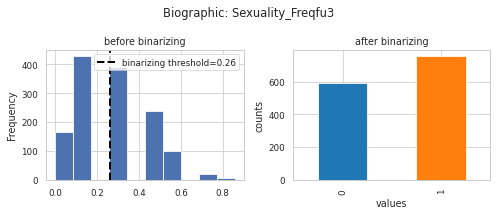

writing to .. posthoc-cc2-h5causal1-Sexuality_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (103) Sexuality_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-1.57, -0.24, -0.21, 1.86)


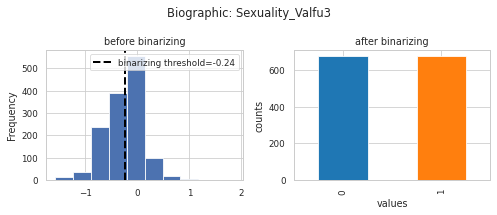

writing to .. posthoc-cc2-h5causal1-Sexuality_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (104) Autonomy_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.21, 0.25, 0.75)


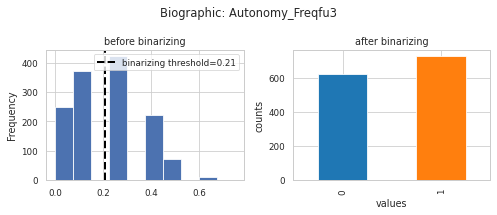

writing to .. posthoc-cc2-h5causal1-Autonomy_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (105) Autonomy_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-2.00, -0.23, -0.25, 1.75)


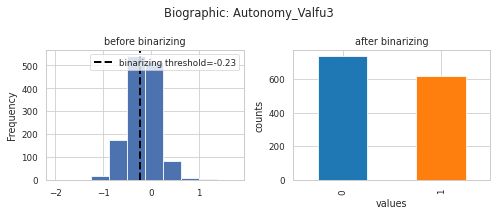

writing to .. posthoc-cc2-h5causal1-Autonomy_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (106) Deviance_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.28, 0.33, 1.00)


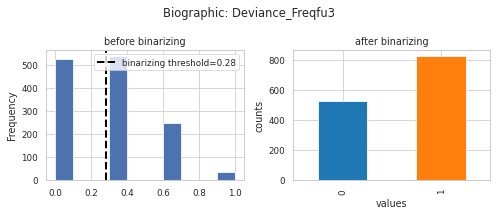

writing to .. posthoc-cc2-h5causal1-Deviance_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (107) Deviance_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-2.00, -0.81, -1.00, 1.33)


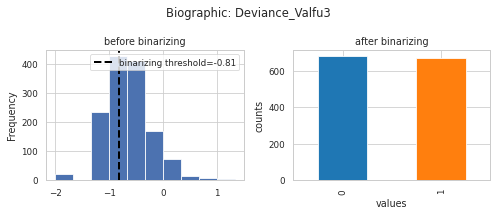

writing to .. posthoc-cc2-h5causal1-Deviance_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (108) Relocation_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.10, 0.00, 1.00)


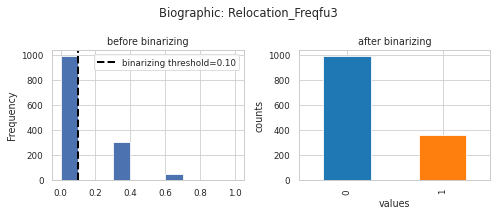

writing to .. posthoc-cc2-h5causal1-Relocation_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (109) Relocation_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-2.00, -0.03, 0.00, 1.67)


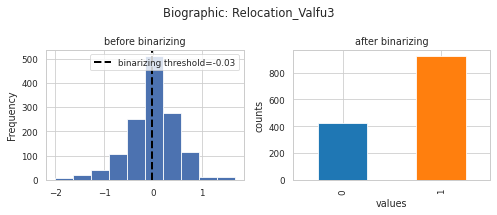

writing to .. posthoc-cc2-h5causal1-Relocation_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (110) Distress_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.29, 0.33, 1.00)


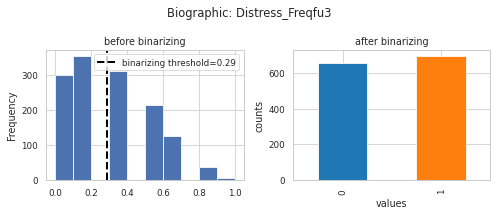

writing to .. posthoc-cc2-h5causal1-Distress_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (111) Distress_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-1.83, -0.23, -0.17, 2.00)


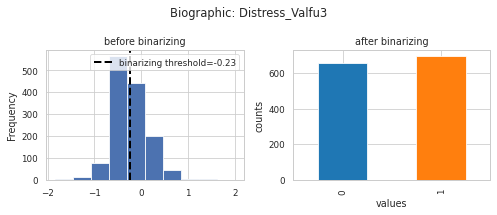

writing to .. posthoc-cc2-h5causal1-Distress_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (112) Total_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (0.00, 0.23, 0.23, 0.67)


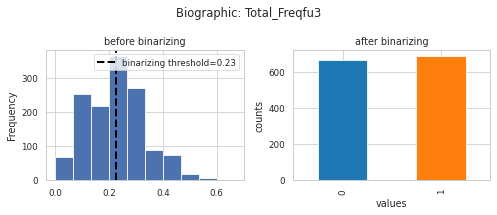

writing to .. posthoc-cc2-h5causal1-Total_freqFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (113) Total_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0
range (min, mean, median, max) = (-1.87, -0.13, -0.13, 1.64)


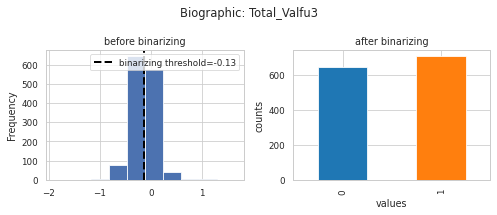

writing to .. posthoc-cc2-h5causal1-Total_valFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (114) Psychiatric_symptoms_PHQ   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 5.56, 4.00, 24.00)


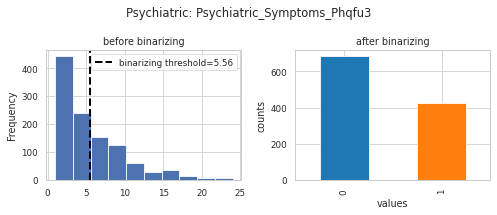

writing to .. posthoc-cc2-h5causal1-Psychiatric_symptoms_PHQFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (115) Social_difficulties   ----------------------
Using Q collected at session-FU3
imputing 3/1315 missing values with 0
range (min, mean, median, max) = (0.00, 2.65, 2.00, 10.00)


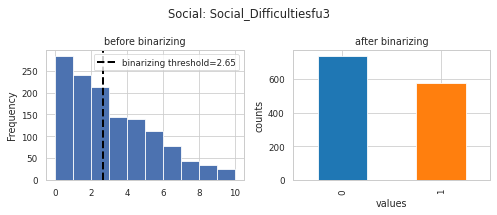

writing to .. posthoc-cc2-h5causal1-Social_difficultiesFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (116) Social_difficulties_impact   ----------------------
Using Q collected at session-FU3
imputing 10/1315 missing values with 0
range (min, mean, median, max) = (0.00, 0.65, 1.00, 2.00)


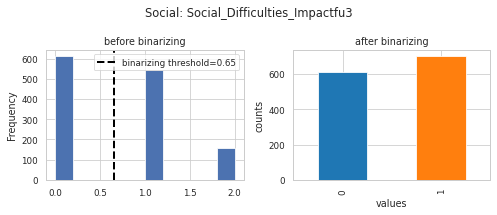

writing to .. posthoc-cc2-h5causal1-Social_difficulties_impactFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (117) Prosocial_behavior   ----------------------
Using Q collected at session-FU3
imputing 3/1315 missing values with 0
range (min, mean, median, max) = (0.00, 0.67, 0.00, 10.00)


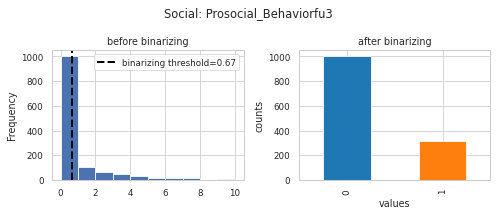

writing to .. posthoc-cc2-h5causal1-Prosocial_behaviorFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (118) Bullying   ----------------------
Using Q collected at session-FU3
imputing 1/1351 missing values with 0
range (min, mean, median, max) = (0.00, 0.28, 0.00, 6.00)


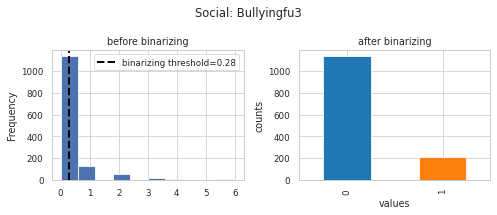

writing to .. posthoc-cc2-h5causal1-BullyingFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (119) Bullying_victim   ----------------------
Using Q collected at session-FU3
imputing 1/1351 missing values with 0
range (min, mean, median, max) = (0.00, 0.66, 0.00, 20.00)


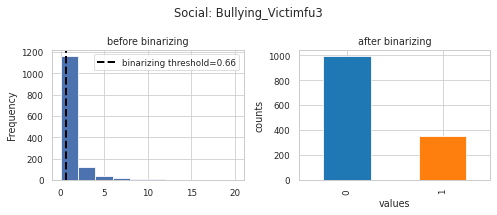

writing to .. posthoc-cc2-h5causal1-Bullying_victimFU3.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (120) Alcoholism_screening_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 1.50, 0.00, 50.00)


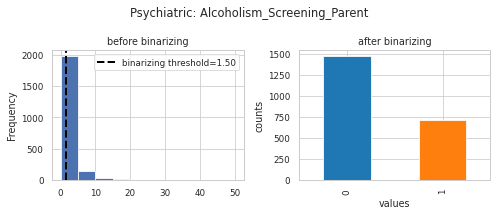

writing to .. posthoc-cc2-h5causal1-Alcoholism_screening_parent.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (121) Drug_abuse_screening_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 2.29, 0.00, 69.00)


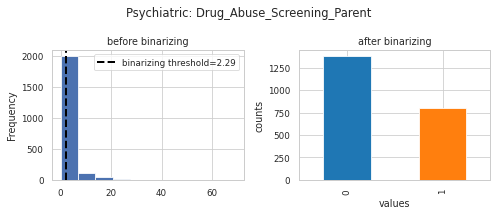

writing to .. posthoc-cc2-h5causal1-Drug_abuse_screening_parent.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (122) Conflict_tactics_parent_mean_assault   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.04, 0.00, 5.29)


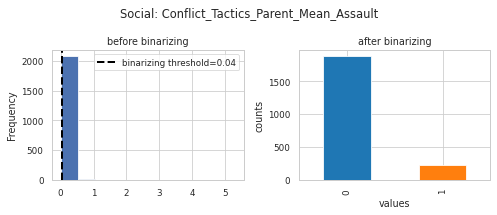

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_assault.h5
attaching conf Conflict_tactics_parent_mean_assault
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_mean_assault has fewer than 15% instances (n=58)
This is very small for counter balancing to work properly..
-------------------  (123) Conflict_tactics_parent_mean_injury   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.04, 0.00, 6.25)


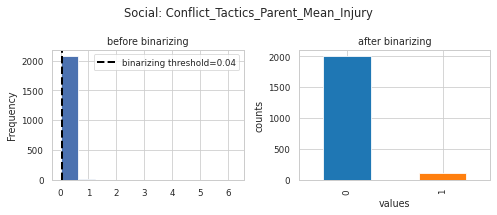

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_injury.h5
attaching conf Conflict_tactics_parent_mean_injury
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_mean_injury has fewer than 15% instances (n=27)
This is very small for counter balancing to work properly..
-------------------  (124) Conflict_tactics_parent_mean_negotiation   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 7.12, 5.83, 25.00)


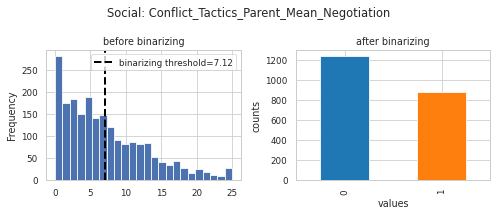

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_negotiation.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (125) Conflict_tactics_parent_mean_psych_aggr   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.96, 0.31, 13.88)


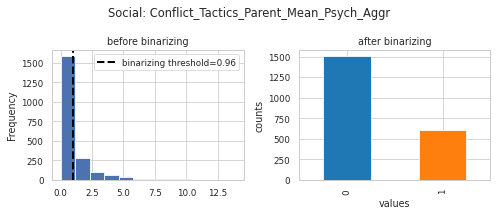

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_psych_aggr.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (126) Conflict_tactics_parent_sexual_coercion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.41, 0.00, 12.50)


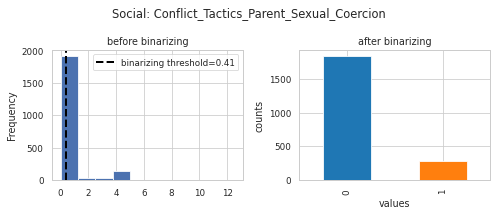

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_sexual_coercion.h5
attaching conf Conflict_tactics_parent_sexual_coercion
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_sexual_coercion has fewer than 15% instances (n=74)
This is very small for counter balancing to work properly..
-------------------  (127) Fam_hist_psych_disorders_parent   ----------------------
Using Q collected at session-BL
imputing 55/2191 missing values with 0
range (min, mean, median, max) = (0.00, 0.50, 1.00, 1.00)


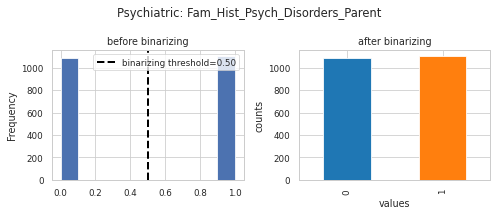

writing to .. posthoc-cc2-h5causal1-Fam_hist_psych_disorders_parent.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (128) PBQ_cigarettes_pregnancy   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-3.00, 2.74, 0.00, 90.00)


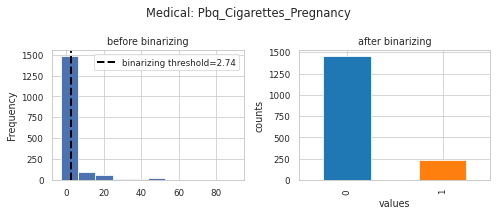

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_pregnancy.h5
attaching conf PBQ_cigarettes_pregnancy
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_pregnancy has fewer than 15% instances (n=54)
This is very small for counter balancing to work properly..
-------------------  (129) PBQ_cigarettes_breastfeeding   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, 0.57, 0.00, 30.00)


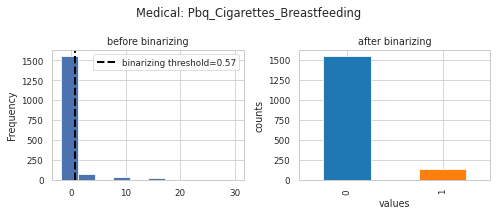

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_breastfeeding.h5
attaching conf PBQ_cigarettes_breastfeeding
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_breastfeeding has fewer than 15% instances (n=32)
This is very small for counter balancing to work properly..
-------------------  (130) PBQ_cigarettes_pres_meds   ----------------------
Using Q collected at session-BL
imputing 61/1688 missing values with 0
range (min, mean, median, max) = (0.00, 0.13, 0.00, 1.00)


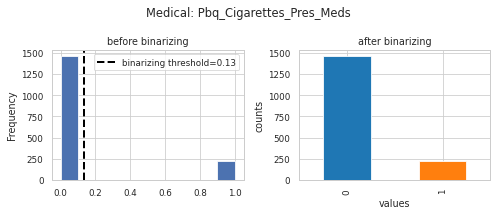

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_pres_meds.h5
attaching conf PBQ_cigarettes_pres_meds
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_pres_meds has fewer than 15% instances (n=64)
This is very small for counter balancing to work properly..
-------------------  (131) PBQ_cigarettes_unpres_meds   ----------------------
Using Q collected at session-BL
imputing 94/1688 missing values with 0
range (min, mean, median, max) = (0.00, 0.21, 0.00, 1.00)


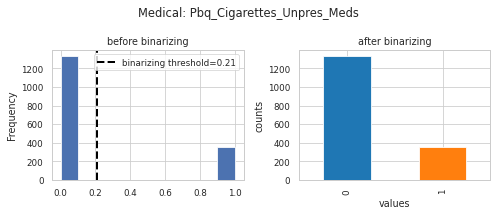

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_unpres_meds.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first
-------------------  (132) PBQ_cigarettes_drugs   ----------------------
Using Q collected at session-BL
imputing 11/1688 missing values with 0
range (min, mean, median, max) = (0.00, 0.01, 0.00, 1.00)


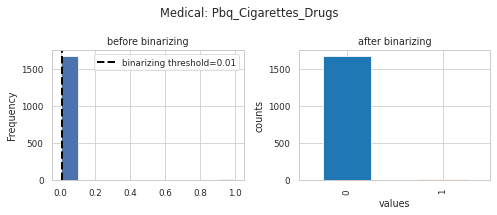

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_drugs.h5
attaching conf PBQ_cigarettes_drugs
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_drugs has fewer than 15% instances (n=2)
This is very small for counter balancing to work properly..
-------------------  (133) AUDIT_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 3.74, 3.00, 29.00)


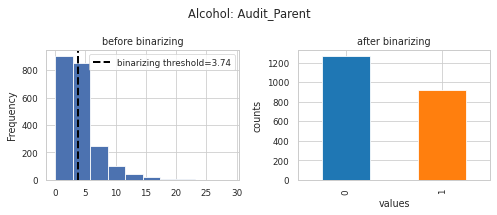

writing to .. posthoc-cc2-h5causal1-AUDIT_parent.h5
[ERROR] Failed to create h5: [ERROR] file already exists.. skipping h5file creation. Remove it manually first


In [240]:
for i,row in pd.read_excel("Confounds_list_Milena_v3.xlsx").iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
        continue
        
    if 'FU' in h5_name.upper() and ('FU' not in row['time_point'].upper()) and row['subject']!='parent':
        print(f"Skipping this conf since it is not applicable for FUx timepoint analysis")
        continue
        
    df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')

    if ('Session' in df_conf):
        conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
        if print_all: print(f"Using Q collected at session-{row['time_point']}")
    elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
        conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
        if print_all: print(f"Using Q collected at session-FU3")
    else:
        conf = df_conf[row['colname']]
        if print_all: print(f"Using Q collected at session-???")

    # set the name provided 
    conf.name = row['conf_name']
    if row['time_point'] != 'BL': 
        conf.name += row['time_point']

    # impute missing values with given value
    if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
        conf = conf.fillna(row['impute_missing_with'])
    elif conf.isna().sum():
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
        # use KNN
        conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

    # plot conf distribution before binarizing
    if plot_dist:
        f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
        plt.suptitle(f"{row['category']}: {conf.name.title()}")

        kwargs = dict(ax=axes[0],
            title="before binarizing", 
            xlabel='values', ylabel='counts')

        nunique = conf.nunique()

        conf.plot(
            kind='hist', bins=10 if nunique<100 else nunique//10,
            **kwargs)

        if print_all: print(
            f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")

    # binarize # TODO change to mean
    binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
    conf = conf.apply(lambda x: int(x>binarizing_threshold))

    # plot conf distribution after binarizing
    if plot_dist:
        # draw the threshold in the prev plot
        axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
        hdls, lbls = axes[0].get_legend_handles_labels()
        axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

        colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
        conf.value_counts(dropna=False).sort_index().plot(
            ax=axes[1], kind='bar',
            title="after binarizing", 
            xlabel='values', ylabel='counts', color=colors)
        plt.tight_layout()
        plt.show()

    # attach conf to the h5 file
    try:
        attach_conf_fromseries(H5_DIR, h5_src, conf, prepend=h5_name, print_all=print_all)
    except AssertionError as e:
        print("[ERROR] Failed to create h5:",e)
            # @Milena look at the log below for the 120+ confounds

### Check h5files

______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-UrbanicityFU3.h5 
 h5.columns = ['Binge', 'UrbanicityFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 556 	 label = Binge 	 X.shape = (556, 719)  	 confs = ['sex', 'site', 'UrbanicityFU3']
label and conf with distributions:


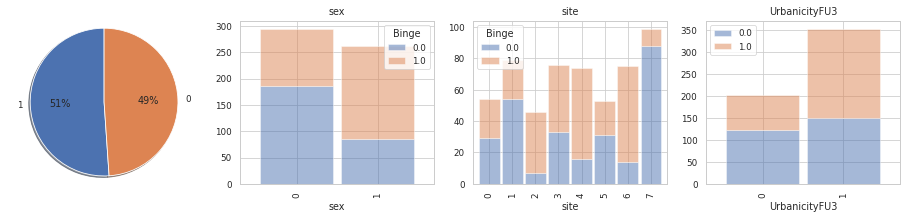


subject: 28490711 	 (min=0.00, mean=16983.48, max=1651995.00)
conf UrbanicityFU3 == label Binge ? 	 True for n=326/556
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc-last12mntFU3.h5 
 h5.columns = ['Alc-last12mntFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Alc-last12mntFU3']
label and conf with distributions:


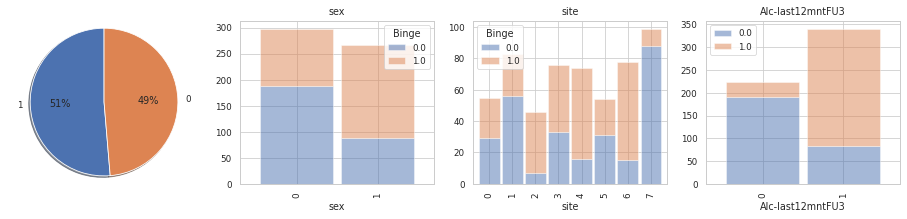


subject: 60334165 	 (min=0.00, mean=19780.45, max=1811483.00)
conf Alc-last12mntFU3 == label Binge ? 	 True for n=448/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Social_difficulties.h5 
 h5.columns = ['Binge', 'Social_difficulties', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Social_difficulties']
label and conf with distributions:


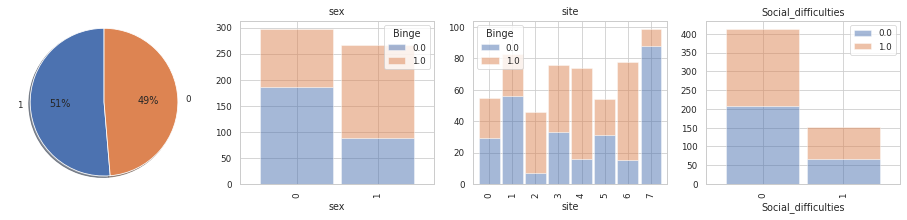


subject: 4908925 	 (min=0.00, mean=18602.34, max=1741721.00)
conf Social_difficulties == label Binge ? 	 True for n=294/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc-lastmnt.h5 
 h5.columns = ['Alc-lastmnt', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Alc-lastmnt']
label and conf with distributions:


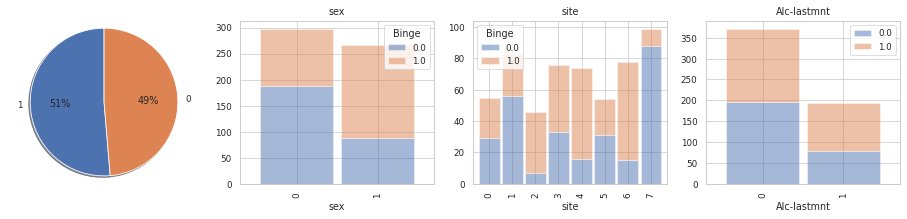


subject: 98600208 	 (min=0.00, mean=16939.33, max=1586430.00)
conf Alc-lastmnt == label Binge ? 	 True for n=310/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-ConscientiousnessFU3.h5 
 h5.columns = ['Binge', 'ConscientiousnessFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 563 	 label = Binge 	 X.shape = (563, 719)  	 confs = ['sex', 'site', 'ConscientiousnessFU3']
label and conf with distributions:


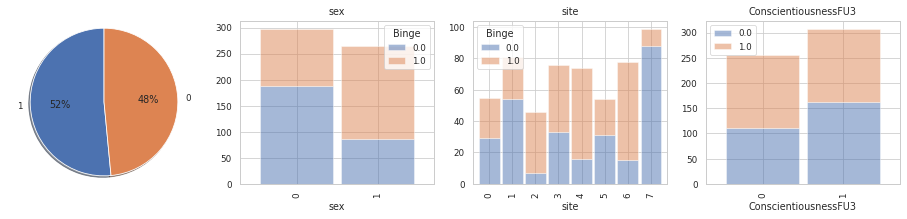


subject: 82930853 	 (min=0.00, mean=19389.19, max=1713925.00)
conf ConscientiousnessFU3 == label Binge ? 	 True for n=257/563
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Well_beingFU3.h5 
 h5.columns = ['Binge', 'Well_beingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Well_beingFU3']
label and conf with distributions:


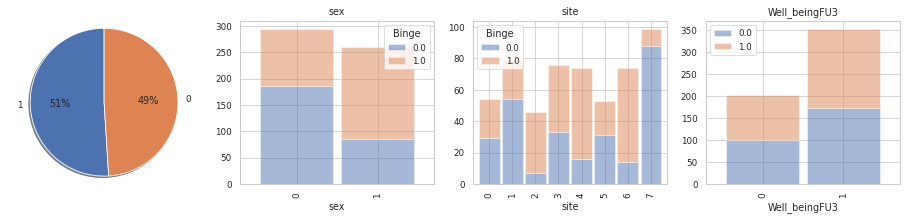


subject: 33889562 	 (min=0.00, mean=20925.87, max=1824601.00)
conf Well_beingFU3 == label Binge ? 	 True for n=281/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-RuminationFU3.h5 
 h5.columns = ['Binge', 'RuminationFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 508 	 label = Binge 	 X.shape = (508, 719)  	 confs = ['sex', 'site', 'RuminationFU3']
label and conf with distributions:


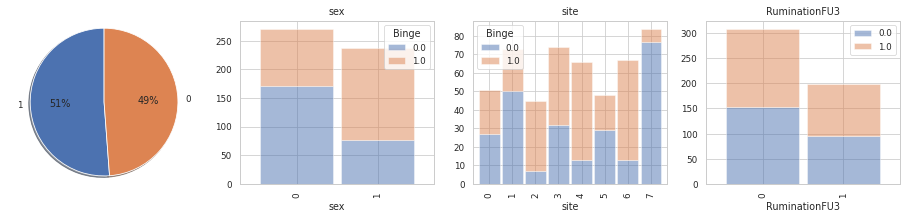


subject: 63400084 	 (min=0.00, mean=16094.81, max=1460434.00)
conf RuminationFU3 == label Binge ? 	 True for n=257/508
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Hopelessness.h5 
 h5.columns = ['Binge', 'Hopelessness', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 564 	 label = Binge 	 X.shape = (564, 719)  	 confs = ['sex', 'site', 'Hopelessness']
label and conf with distributions:


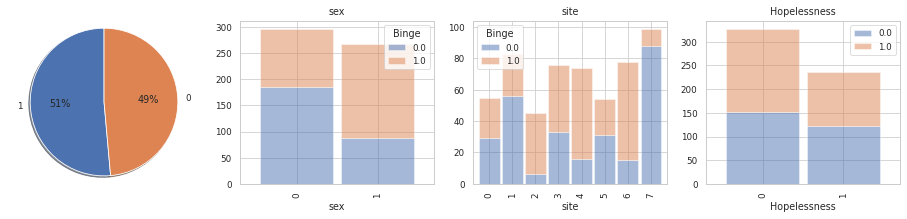


subject: 73231355 	 (min=0.00, mean=19695.13, max=1752816.00)
conf Hopelessness == label Binge ? 	 True for n=266/564
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Coping_drinking_motiveFU3.h5 
 h5.columns = ['Binge', 'Coping_drinking_motiveFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Coping_drinking_motiveFU3']
label and conf with distributions:


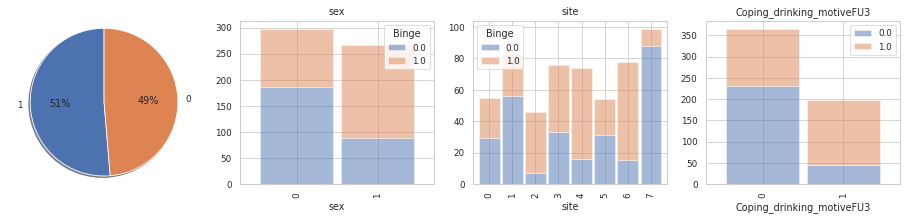


subject: 98600208 	 (min=0.00, mean=16939.33, max=1586430.00)
conf Coping_drinking_motiveFU3 == label Binge ? 	 True for n=386/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Somatization_BSIFU3.h5 
 h5.columns = ['Binge', 'Somatization_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Somatization_BSIFU3']
label and conf with distributions:


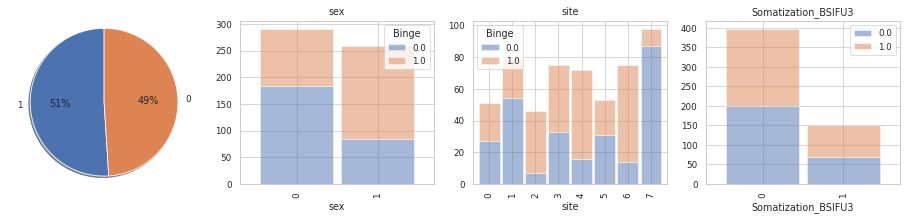


subject: 47472787 	 (min=0.00, mean=16869.14, max=1585762.00)
conf Somatization_BSIFU3 == label Binge ? 	 True for n=280/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-AUDIT_parent.h5 
 h5.columns = ['AUDIT_parent', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 563 	 label = Binge 	 X.shape = (563, 719)  	 confs = ['sex', 'site', 'AUDIT_parent']
label and conf with distributions:


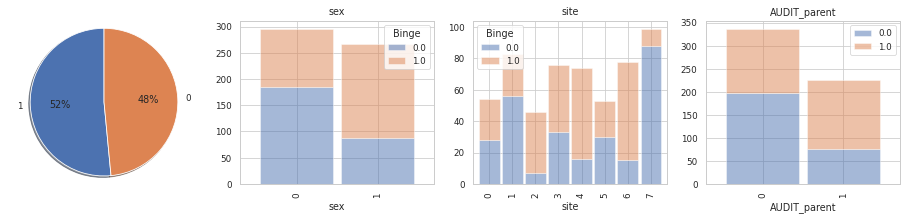


subject: 78555266 	 (min=0.00, mean=17031.94, max=1651707.00)
conf AUDIT_parent == label Binge ? 	 True for n=349/563
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Comp_sub_abuse_lftFU3.h5 
 h5.columns = ['Binge', 'Comp_sub_abuse_lftFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Comp_sub_abuse_lftFU3']
label and conf with distributions:


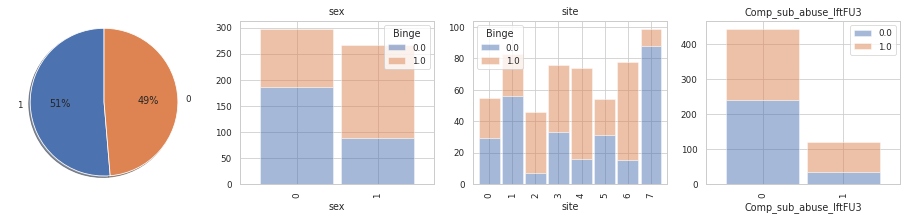


subject: 47157916 	 (min=0.00, mean=19980.07, max=1742839.00)
conf Comp_sub_abuse_lftFU3 == label Binge ? 	 True for n=326/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Anxiety_BSIFU3.h5 
 h5.columns = ['Anxiety_BSIFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Anxiety_BSIFU3']
label and conf with distributions:


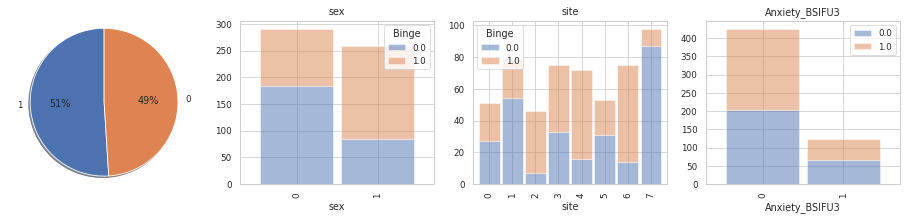


subject: 99930021 	 (min=0.00, mean=15582.85, max=1465807.00)
conf Anxiety_BSIFU3 == label Binge ? 	 True for n=262/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc_lastmnt_TLFB.h5 
 h5.columns = ['Alc_lastmnt_TLFB', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Alc_lastmnt_TLFB']
label and conf with distributions:


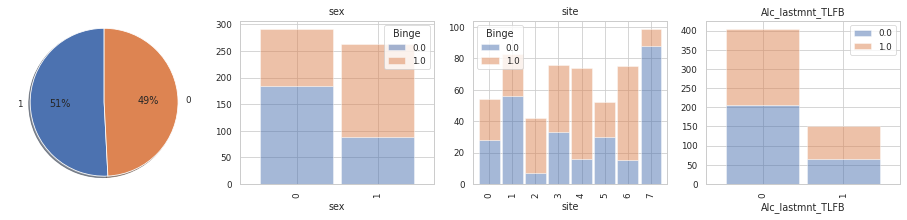


subject: 26400185 	 (min=0.00, mean=18226.77, max=1805293.00)
conf Alc_lastmnt_TLFB == label Binge ? 	 True for n=291/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-StressFU3.h5 
 h5.columns = ['Binge', 'StressFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'StressFU3']
label and conf with distributions:


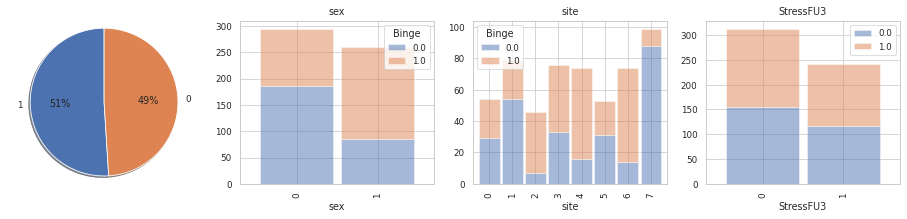


subject: 15734458 	 (min=0.00, mean=16765.63, max=1519246.00)
conf StressFU3 == label Binge ? 	 True for n=280/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Conscientiousness.h5 
 h5.columns = ['Binge', 'Conscientiousness', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Conscientiousness']
label and conf with distributions:


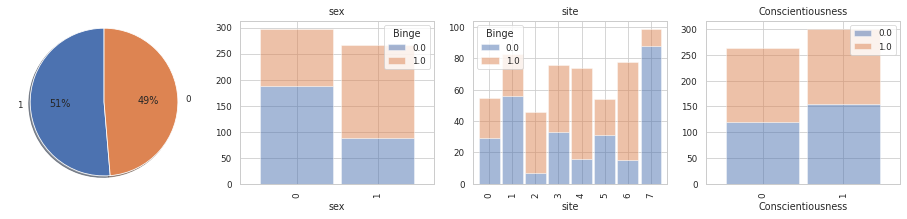


subject: 57968987 	 (min=0.00, mean=17499.37, max=1575483.00)
conf Conscientiousness == label Binge ? 	 True for n=266/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Total_freq.h5 
 h5.columns = ['Binge', 'Total_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Total_freq']
label and conf with distributions:


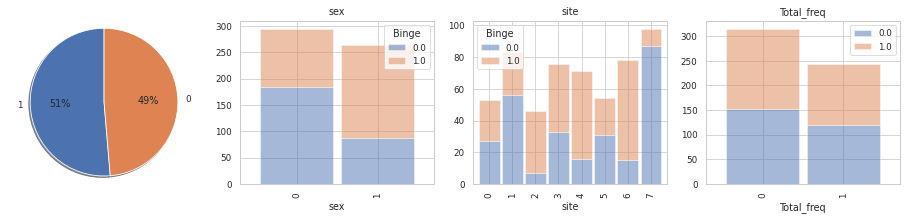


subject: 41213271 	 (min=0.00, mean=18063.37, max=1718869.00)
conf Total_freq == label Binge ? 	 True for n=278/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Family_freq.h5 
 h5.columns = ['Binge', 'Family_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Family_freq']
label and conf with distributions:


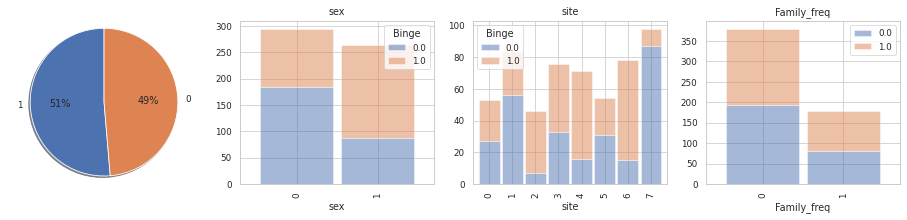


subject: 7420435 	 (min=0.00, mean=18180.80, max=1678543.00)
conf Family_freq == label Binge ? 	 True for n=291/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-QOL_self-rated_healthFU3.h5 
 h5.columns = ['Binge', 'QOL_self-rated_healthFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'QOL_self-rated_healthFU3']
label and conf with distributions:


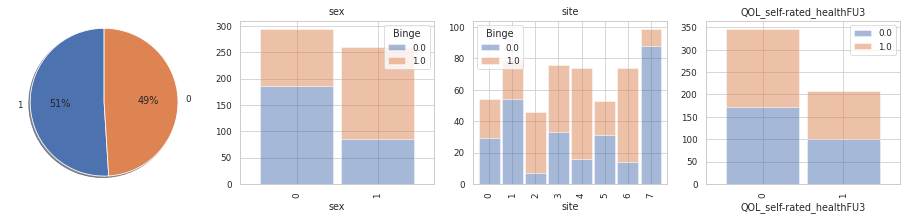


subject: 75315363 	 (min=0.00, mean=16237.59, max=1498894.00)
conf QOL_self-rated_healthFU3 == label Binge ? 	 True for n=280/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-PBQ_cigarettes_unpres_meds.h5 
 h5.columns = ['Binge', 'PBQ_cigarettes_unpres_meds', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 458 	 label = Binge 	 X.shape = (458, 719)  	 confs = ['sex', 'site', 'PBQ_cigarettes_unpres_meds']
label and conf with distributions:


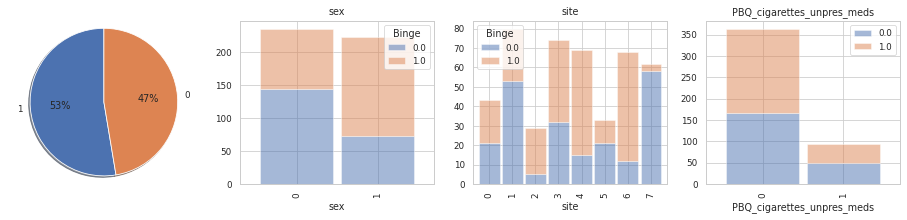


subject: 14803670 	 (min=0.00, mean=16393.46, max=1527703.00)
conf PBQ_cigarettes_unpres_meds == label Binge ? 	 True for n=211/458
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Impulsivity_SURPSFU3.h5 
 h5.columns = ['Binge', 'Impulsivity_SURPSFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 561 	 label = Binge 	 X.shape = (561, 719)  	 confs = ['sex', 'site', 'Impulsivity_SURPSFU3']
label and conf with distributions:


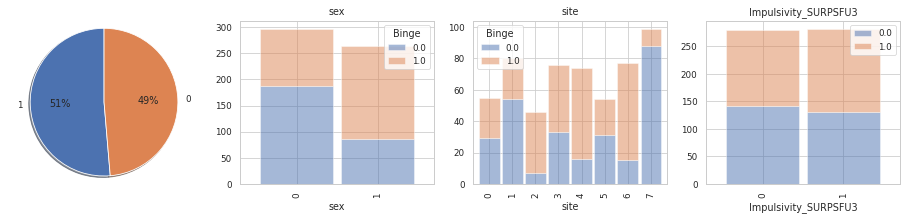


subject: 5683533 	 (min=0.00, mean=17231.73, max=1595663.00)
conf Impulsivity_SURPSFU3 == label Binge ? 	 True for n=293/561
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Family_val.h5 
 h5.columns = ['Binge', 'Family_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Family_val']
label and conf with distributions:


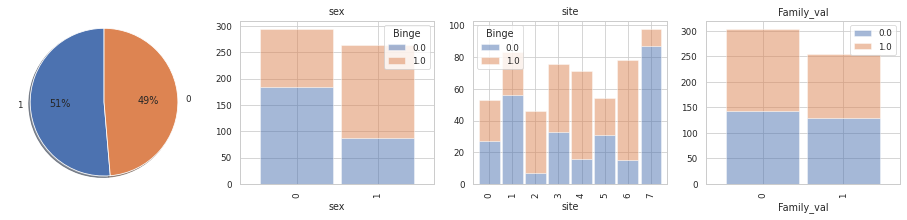


subject: 83656920 	 (min=0.00, mean=16672.53, max=1562120.00)
conf Family_val == label Binge ? 	 True for n=269/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-BullyingFU3.h5 
 h5.columns = ['Binge', 'BullyingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'BullyingFU3']
label and conf with distributions:


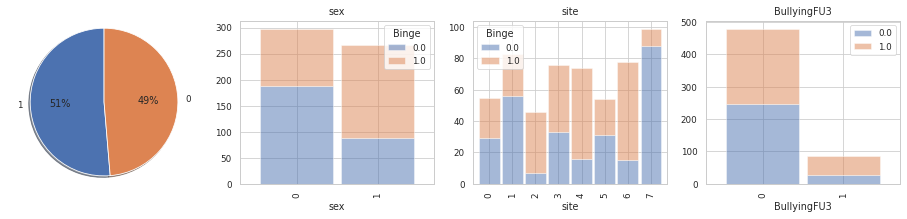


subject: 60942682 	 (min=0.00, mean=17076.90, max=1577213.00)
conf BullyingFU3 == label Binge ? 	 True for n=305/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_negotiation.h5 
 h5.columns = ['Binge', 'Conflict_tactics_parent_mean_negotiation', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 553 	 label = Binge 	 X.shape = (553, 719)  	 confs = ['sex', 'site', 'Conflict_tactics_parent_mean_negotiation']
label and conf with distributions:


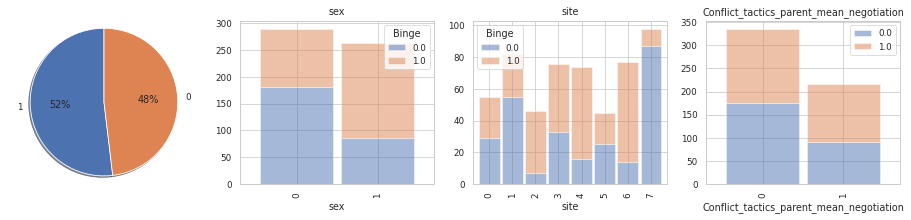


subject: 13148228 	 (min=0.00, mean=17798.66, max=1591918.00)
conf Conflict_tactics_parent_mean_negotiation == label Binge ? 	 True for n=303/553
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Obsession_compulsion_BSIFU3.h5 
 h5.columns = ['Binge', 'Obsession_compulsion_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Obsession_compulsion_BSIFU3']
label and conf with distributions:


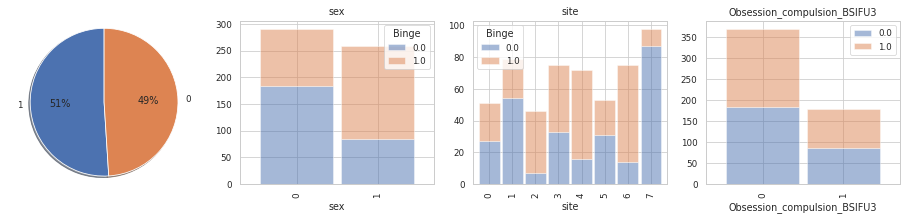


subject: 57968987 	 (min=0.00, mean=17499.37, max=1575483.00)
conf Obsession_compulsion_BSIFU3 == label Binge ? 	 True for n=275/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Distress_val.h5 
 h5.columns = ['Binge', 'Distress_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Distress_val']
label and conf with distributions:


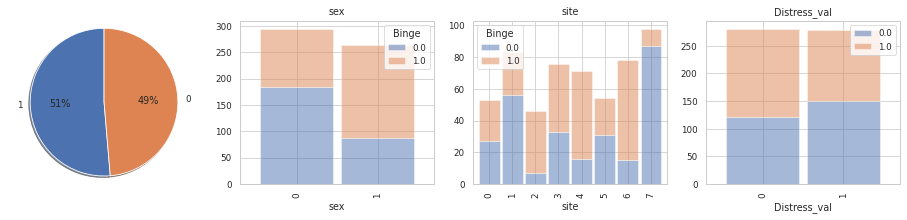


subject: 6021063 	 (min=0.00, mean=14085.02, max=1442792.00)
conf Distress_val == label Binge ? 	 True for n=248/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-NeuroticismFU3.h5 
 h5.columns = ['Binge', 'NeuroticismFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 563 	 label = Binge 	 X.shape = (563, 719)  	 confs = ['sex', 'site', 'NeuroticismFU3']
label and conf with distributions:


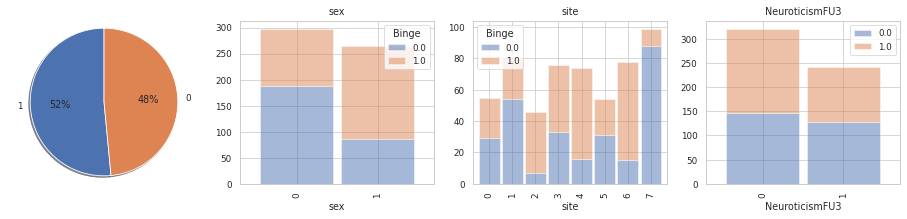


subject: 22295030 	 (min=0.00, mean=15438.83, max=1390682.00)
conf NeuroticismFU3 == label Binge ? 	 True for n=261/563
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Autonomy_freqFU3.h5 
 h5.columns = ['Autonomy_freqFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Autonomy_freqFU3']
label and conf with distributions:


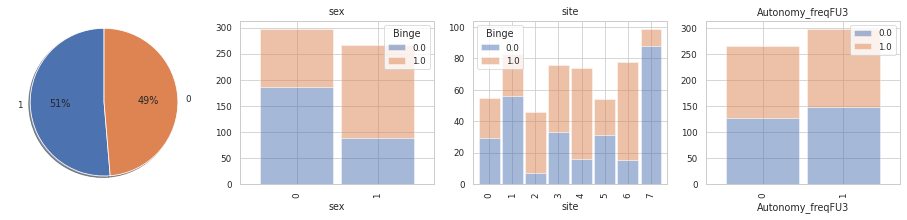


subject: 34196193 	 (min=0.00, mean=16487.42, max=1486394.00)
conf Autonomy_freqFU3 == label Binge ? 	 True for n=278/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Relocation_valFU3.h5 
 h5.columns = ['Binge', 'Relocation_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Relocation_valFU3']
label and conf with distributions:


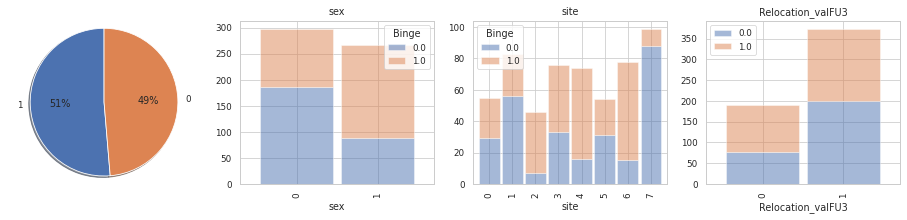


subject: 32110235 	 (min=0.00, mean=17396.21, max=1580296.00)
conf Relocation_valFU3 == label Binge ? 	 True for n=251/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Social_difficulties_impactFU3.h5 
 h5.columns = ['Binge', 'Social_difficulties_impactFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 545 	 label = Binge 	 X.shape = (545, 719)  	 confs = ['sex', 'site', 'Social_difficulties_impactFU3']
label and conf with distributions:


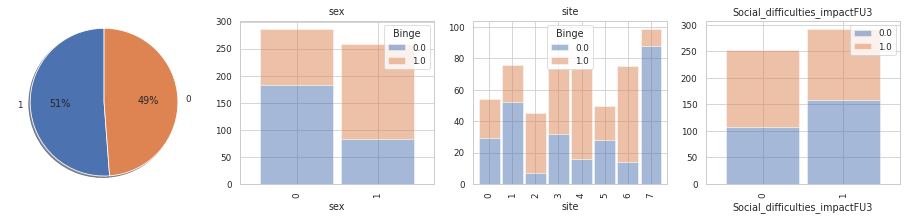


subject: 35931532 	 (min=0.00, mean=16971.72, max=1528139.00)
conf Social_difficulties_impactFU3 == label Binge ? 	 True for n=243/545
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-QOL_activity_limitation_daysFU3.h5 
 h5.columns = ['Binge', 'QOL_activity_limitation_daysFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'QOL_activity_limitation_daysFU3']
label and conf with distributions:


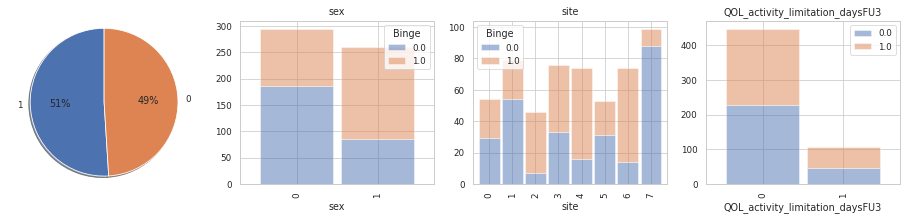


subject: 38221741 	 (min=0.00, mean=18233.37, max=1606138.00)
conf QOL_activity_limitation_daysFU3 == label Binge ? 	 True for n=289/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alcoholism_screening_parent.h5 
 h5.columns = ['Alcoholism_screening_parent', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 562 	 label = Binge 	 X.shape = (562, 719)  	 confs = ['sex', 'site', 'Alcoholism_screening_parent']
label and conf with distributions:


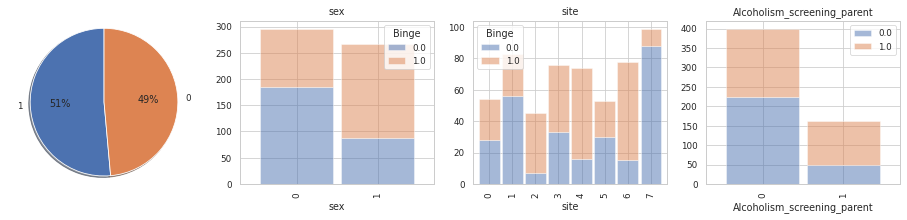


subject: 80491858 	 (min=0.00, mean=16905.26, max=1527593.00)
conf Alcoholism_screening_parent == label Binge ? 	 True for n=337/562
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_behavior_emotional_eatingFU3.h5 
 h5.columns = ['Binge', 'Eating_behavior_emotional_eatingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_behavior_emotional_eatingFU3']
label and conf with distributions:


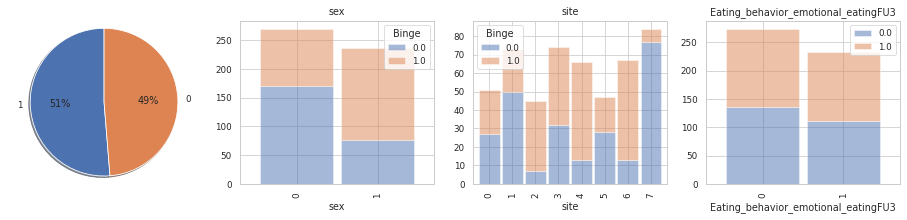


subject: 67260838 	 (min=0.00, mean=18945.77, max=1686505.00)
conf Eating_behavior_emotional_eatingFU3 == label Binge ? 	 True for n=258/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Bullying_victimFU3.h5 
 h5.columns = ['Binge', 'Bullying_victimFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Bullying_victimFU3']
label and conf with distributions:


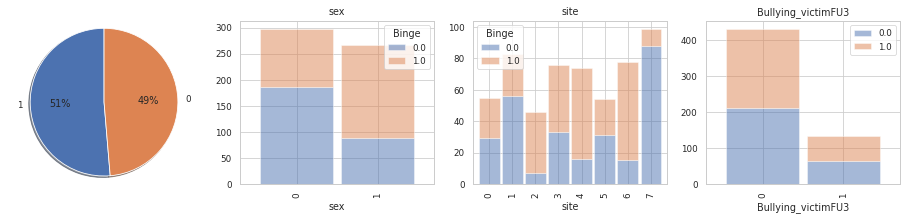


subject: 67052967 	 (min=0.00, mean=16236.37, max=1510998.00)
conf Bullying_victimFU3 == label Binge ? 	 True for n=281/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Interpers_sensitivity_BSIFU3.h5 
 h5.columns = ['Binge', 'Interpers_sensitivity_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Interpers_sensitivity_BSIFU3']
label and conf with distributions:


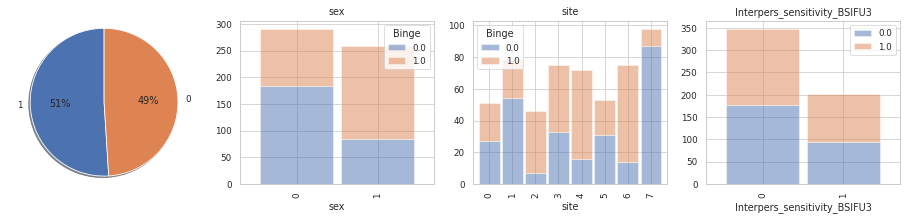


subject: 1298929 	 (min=0.00, mean=18785.94, max=1672154.00)
conf Interpers_sensitivity_BSIFU3 == label Binge ? 	 True for n=284/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Accident_freq.h5 
 h5.columns = ['Accident_freq', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Accident_freq']
label and conf with distributions:


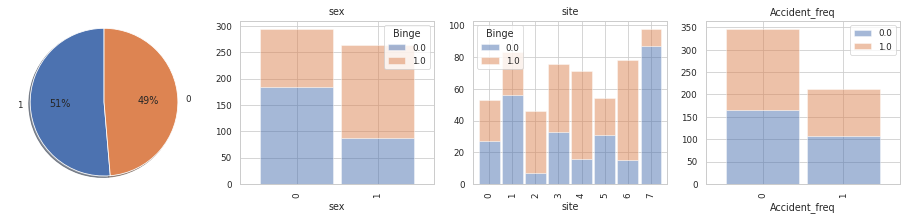


subject: 47507426 	 (min=0.00, mean=16767.08, max=1656329.00)
conf Accident_freq == label Binge ? 	 True for n=270/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Social_drinking_motiveFU3.h5 
 h5.columns = ['Binge', 'Social_drinking_motiveFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Social_drinking_motiveFU3']
label and conf with distributions:


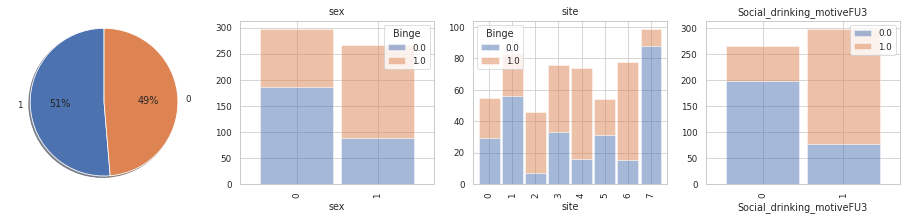


subject: 22295030 	 (min=0.00, mean=15438.83, max=1390682.00)
conf Social_drinking_motiveFU3 == label Binge ? 	 True for n=422/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Distress_valFU3.h5 
 h5.columns = ['Binge', 'Distress_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Distress_valFU3']
label and conf with distributions:


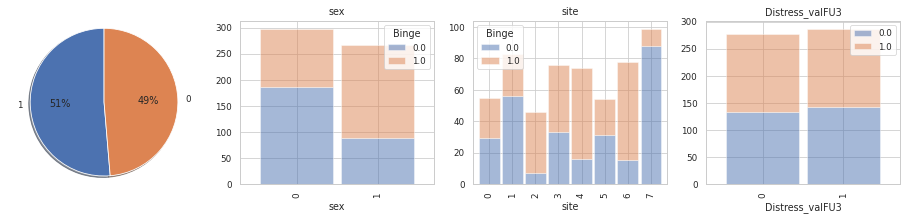


subject: 49148426 	 (min=0.00, mean=17895.90, max=1662206.00)
conf Distress_valFU3 == label Binge ? 	 True for n=278/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Prosocial_behaviorFU3.h5 
 h5.columns = ['Binge', 'Prosocial_behaviorFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 545 	 label = Binge 	 X.shape = (545, 719)  	 confs = ['sex', 'site', 'Prosocial_behaviorFU3']
label and conf with distributions:


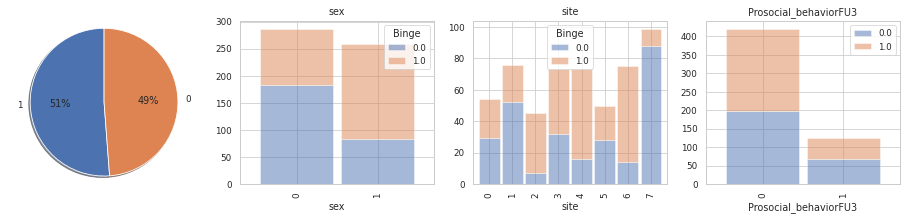


subject: 91362411 	 (min=0.00, mean=19060.22, max=1752412.00)
conf Prosocial_behaviorFU3 == label Binge ? 	 True for n=254/545
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Smoking_lifetimeFU3.h5 
 h5.columns = ['Binge', 'Smoking_lifetimeFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Smoking_lifetimeFU3']
label and conf with distributions:


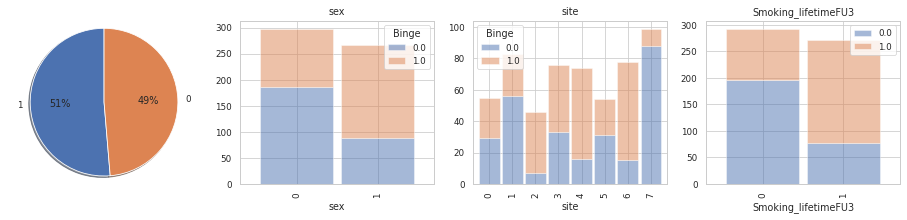


subject: 62936394 	 (min=0.00, mean=18853.49, max=1669935.00)
conf Smoking_lifetimeFU3 == label Binge ? 	 True for n=391/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Hostility_BSIFU3.h5 
 h5.columns = ['Binge', 'Hostility_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Hostility_BSIFU3']
label and conf with distributions:


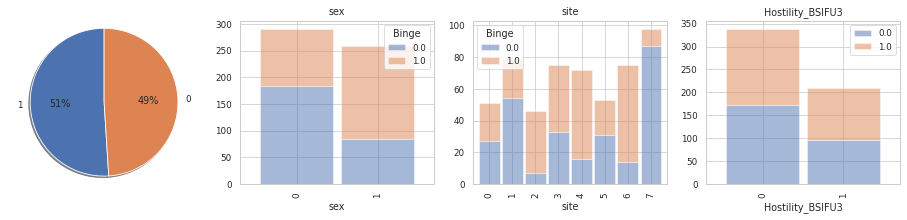


subject: 47381951 	 (min=0.00, mean=19441.77, max=1717685.00)
conf Hostility_BSIFU3 == label Binge ? 	 True for n=285/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Deviance_val.h5 
 h5.columns = ['Binge', 'Deviance_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Deviance_val']
label and conf with distributions:


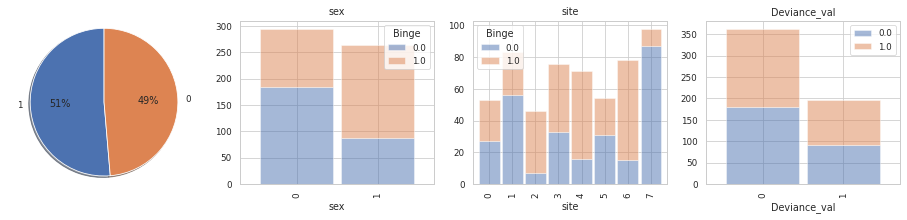


subject: 34532105 	 (min=0.00, mean=24846.89, max=2242251.16)
conf Deviance_val == label Binge ? 	 True for n=284/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sexuality_val.h5 
 h5.columns = ['Binge', 'Sexuality_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Sexuality_val']
label and conf with distributions:


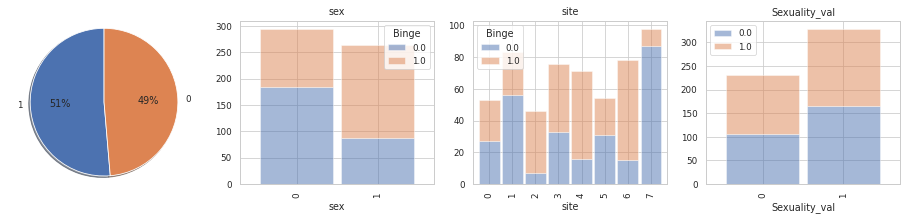


subject: 48908846 	 (min=0.00, mean=19952.80, max=1777433.00)
conf Sexuality_val == label Binge ? 	 True for n=269/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Drug_abuse_screening_parent.h5 
 h5.columns = ['Binge', 'Drug_abuse_screening_parent', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 563 	 label = Binge 	 X.shape = (563, 719)  	 confs = ['sex', 'site', 'Drug_abuse_screening_parent']
label and conf with distributions:


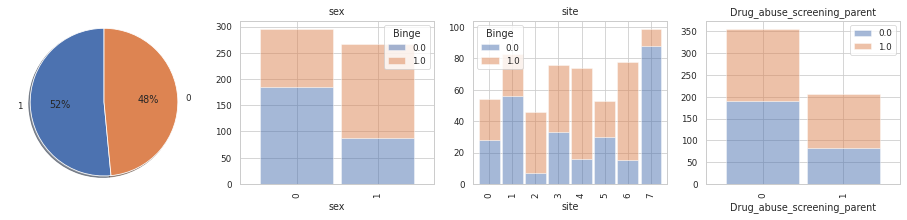


subject: 5683533 	 (min=0.00, mean=17231.73, max=1595663.00)
conf Drug_abuse_screening_parent == label Binge ? 	 True for n=316/563
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Depression_BSIFU3.h5 
 h5.columns = ['Binge', 'Depression_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Depression_BSIFU3']
label and conf with distributions:


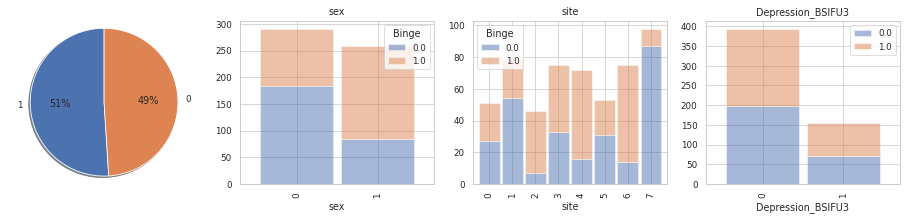


subject: 21415101 	 (min=0.00, mean=17990.23, max=1593773.00)
conf Depression_BSIFU3 == label Binge ? 	 True for n=280/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Depression_K6+FU3.h5 
 h5.columns = ['Binge', 'Depression_K6+FU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Depression_K6+FU3']
label and conf with distributions:


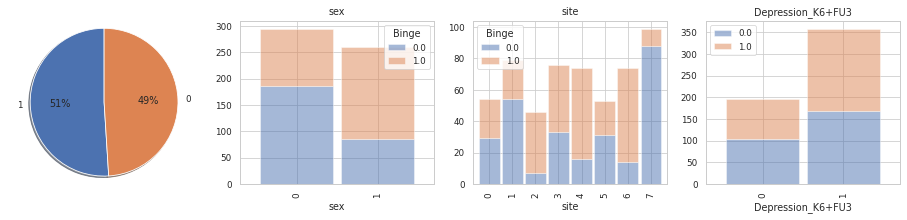


subject: 69795852 	 (min=0.00, mean=21055.86, max=1838741.00)
conf Depression_K6+FU3 == label Binge ? 	 True for n=292/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Age_first_drunkFU3.h5 
 h5.columns = ['Age_first_drunkFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 506 	 label = Binge 	 X.shape = (506, 719)  	 confs = ['sex', 'site', 'Age_first_drunkFU3']
label and conf with distributions:


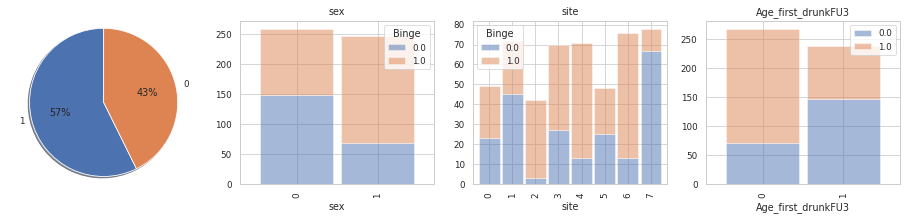


subject: 66086086 	 (min=0.00, mean=16139.09, max=1501037.00)
conf Age_first_drunkFU3 == label Binge ? 	 True for n=162/506
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Novelty_seeking.h5 
 h5.columns = ['Binge', 'Novelty_seeking', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 562 	 label = Binge 	 X.shape = (562, 719)  	 confs = ['sex', 'site', 'Novelty_seeking']
label and conf with distributions:


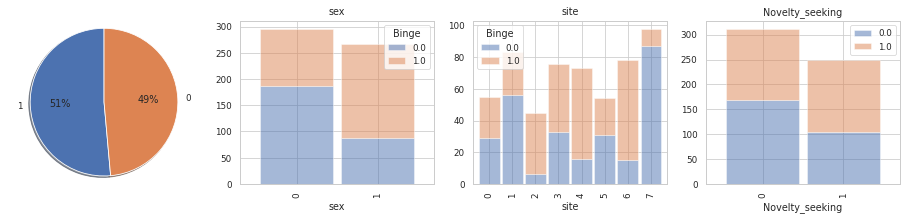


subject: 51829237 	 (min=0.00, mean=15174.22, max=1397620.00)
conf Novelty_seeking == label Binge ? 	 True for n=315/562
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Physical_health_conditionsFU3.h5 
 h5.columns = ['Binge', 'Physical_health_conditionsFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Physical_health_conditionsFU3']
label and conf with distributions:


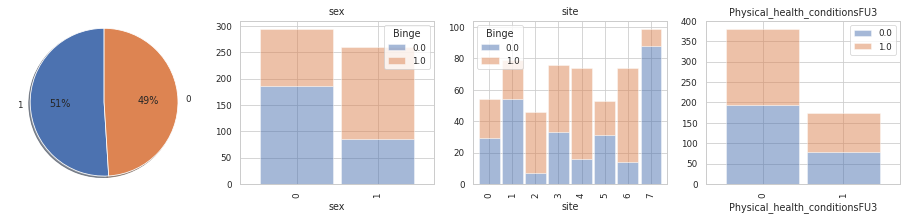


subject: 13148228 	 (min=0.00, mean=17798.66, max=1591918.00)
conf Physical_health_conditionsFU3 == label Binge ? 	 True for n=290/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Drugs_lastmnt_TLFBFU3.h5 
 h5.columns = ['Binge', 'Drugs_lastmnt_TLFBFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 463 	 label = Binge 	 X.shape = (463, 719)  	 confs = ['sex', 'site', 'Drugs_lastmnt_TLFBFU3']
label and conf with distributions:


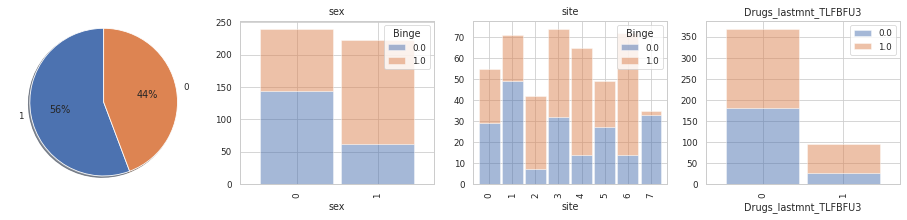


subject: 7836916 	 (min=0.00, mean=18745.17, max=1675608.00)
conf Drugs_lastmnt_TLFBFU3 == label Binge ? 	 True for n=249/463
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Relocation_freq.h5 
 h5.columns = ['Binge', 'Relocation_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Relocation_freq']
label and conf with distributions:


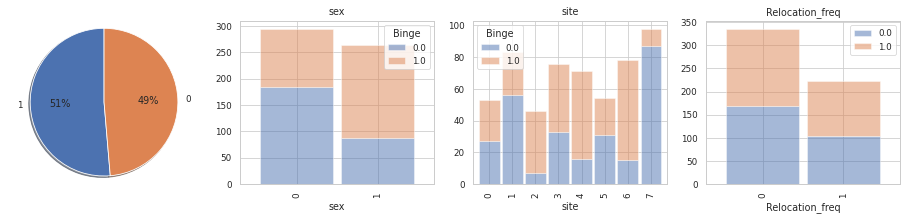


subject: 93455698 	 (min=0.00, mean=16701.91, max=1489985.00)
conf Relocation_freq == label Binge ? 	 True for n=287/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Deviance_valFU3.h5 
 h5.columns = ['Binge', 'Deviance_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Deviance_valFU3']
label and conf with distributions:


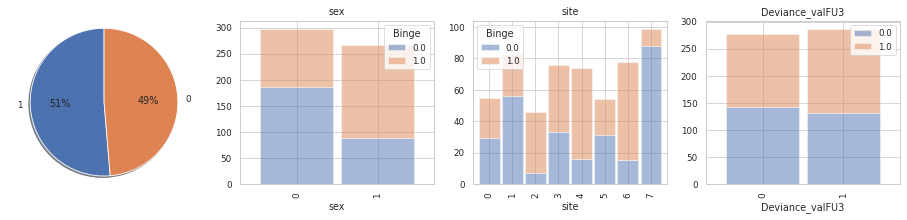


subject: 37058553 	 (min=0.00, mean=15894.80, max=1438800.00)
conf Deviance_valFU3 == label Binge ? 	 True for n=298/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Distress_freq.h5 
 h5.columns = ['Binge', 'Distress_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Distress_freq']
label and conf with distributions:


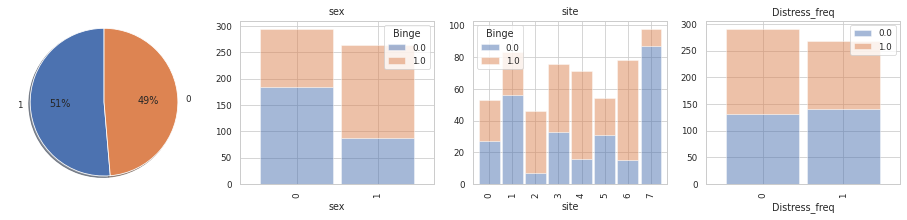


subject: 55104004 	 (min=0.00, mean=19970.15, max=1901073.00)
conf Distress_freq == label Binge ? 	 True for n=258/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Anxiety_sensitivityFU3.h5 
 h5.columns = ['Anxiety_sensitivityFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 561 	 label = Binge 	 X.shape = (561, 719)  	 confs = ['sex', 'site', 'Anxiety_sensitivityFU3']
label and conf with distributions:


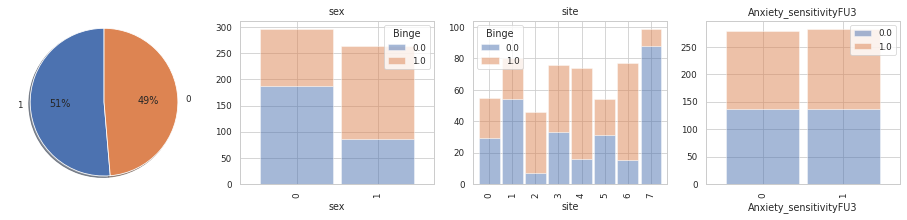


subject: 38793721 	 (min=0.00, mean=20296.21, max=1797001.00)
conf Anxiety_sensitivityFU3 == label Binge ? 	 True for n=282/561
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Drug_abuse_lft.h5 
 h5.columns = ['Binge', 'Drug_abuse_lft', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Drug_abuse_lft']
label and conf with distributions:


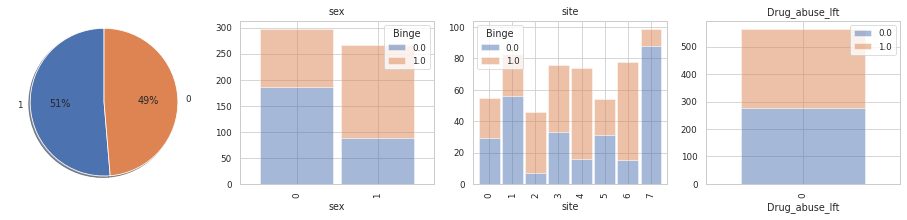


subject: 55982442 	 (min=0.00, mean=18257.00, max=1618354.00)
conf Drug_abuse_lft == label Binge ? 	 True for n=275/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Total_valFU3.h5 
 h5.columns = ['Binge', 'Total_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Total_valFU3']
label and conf with distributions:


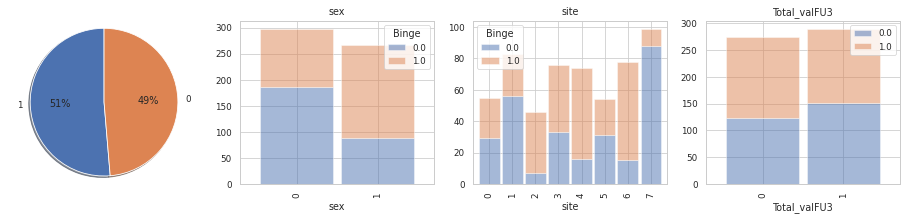


subject: 24686194 	 (min=0.00, mean=17299.60, max=1588528.00)
conf Total_valFU3 == label Binge ? 	 True for n=263/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Phobic_anxiety_BSIFU3.h5 
 h5.columns = ['Binge', 'Phobic_anxiety_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Phobic_anxiety_BSIFU3']
label and conf with distributions:


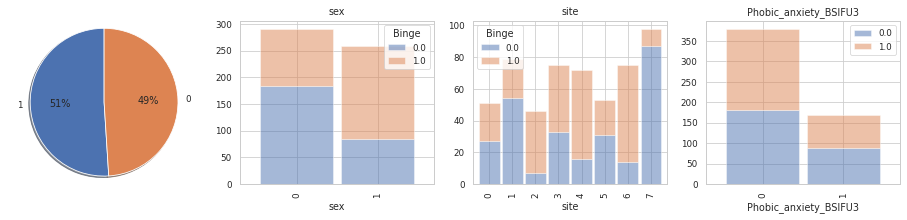


subject: 68223643 	 (min=0.00, mean=16757.57, max=1568461.00)
conf Phobic_anxiety_BSIFU3 == label Binge ? 	 True for n=262/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-SomatizationFU3.h5 
 h5.columns = ['Binge', 'SomatizationFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 508 	 label = Binge 	 X.shape = (508, 719)  	 confs = ['sex', 'site', 'SomatizationFU3']
label and conf with distributions:


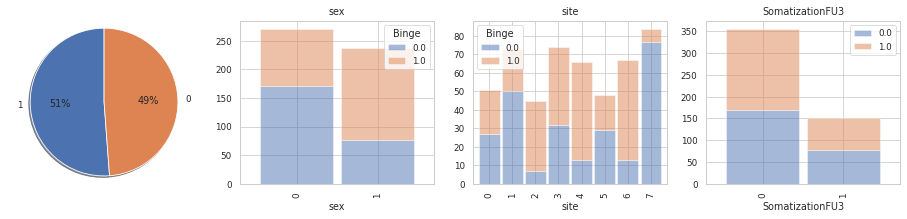


subject: 75751859 	 (min=0.00, mean=18734.54, max=1685710.00)
conf SomatizationFU3 == label Binge ? 	 True for n=244/508
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Tobacco_lastmnt_TLFBFU3.h5 
 h5.columns = ['Binge', 'Tobacco_lastmnt_TLFBFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 463 	 label = Binge 	 X.shape = (463, 719)  	 confs = ['sex', 'site', 'Tobacco_lastmnt_TLFBFU3']
label and conf with distributions:


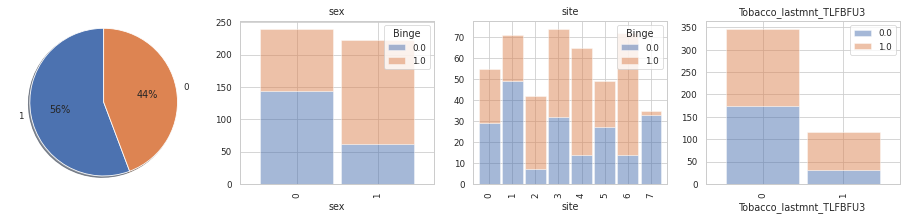


subject: 52638709 	 (min=0.00, mean=14585.05, max=1473261.00)
conf Tobacco_lastmnt_TLFBFU3 == label Binge ? 	 True for n=259/463
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Enhancement_drinking_motiveFU3.h5 
 h5.columns = ['Binge', 'Enhancement_drinking_motiveFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Enhancement_drinking_motiveFU3']
label and conf with distributions:


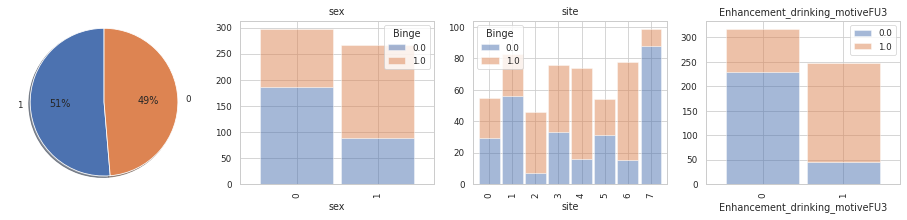


subject: 54552397 	 (min=0.00, mean=12698.21, max=1480079.00)
conf Enhancement_drinking_motiveFU3 == label Binge ? 	 True for n=432/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc-last12mnt.h5 
 h5.columns = ['Alc-last12mnt', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Alc-last12mnt']
label and conf with distributions:


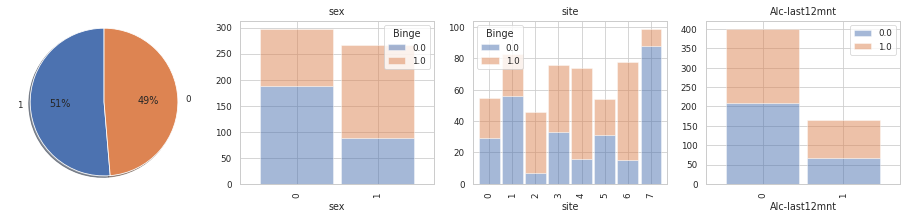


subject: 92126350 	 (min=0.00, mean=19282.27, max=1737813.00)
conf Alc-last12mnt == label Binge ? 	 True for n=305/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sexuality_freq.h5 
 h5.columns = ['Binge', 'Sexuality_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Sexuality_freq']
label and conf with distributions:


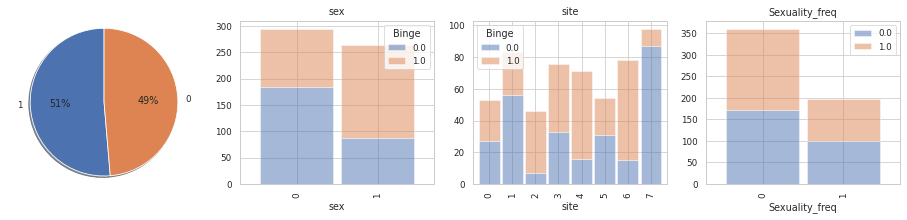


subject: 52172018 	 (min=0.00, mean=18386.79, max=1606785.23)
conf Sexuality_freq == label Binge ? 	 True for n=268/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-QOL_mentally_unhealthy_daysFU3.h5 
 h5.columns = ['Binge', 'QOL_mentally_unhealthy_daysFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'QOL_mentally_unhealthy_daysFU3']
label and conf with distributions:


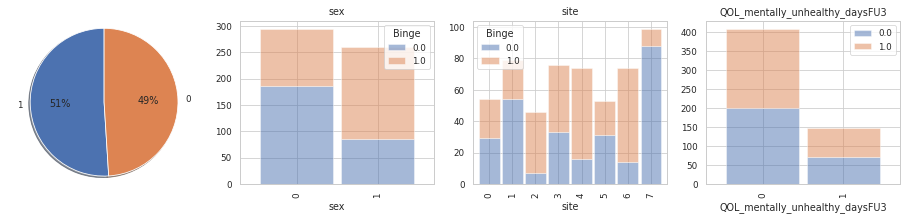


subject: 64043761 	 (min=0.00, mean=18058.81, max=1646380.00)
conf QOL_mentally_unhealthy_daysFU3 == label Binge ? 	 True for n=275/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_disorder_shape_concernFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_shape_concernFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_disorder_shape_concernFU3']
label and conf with distributions:


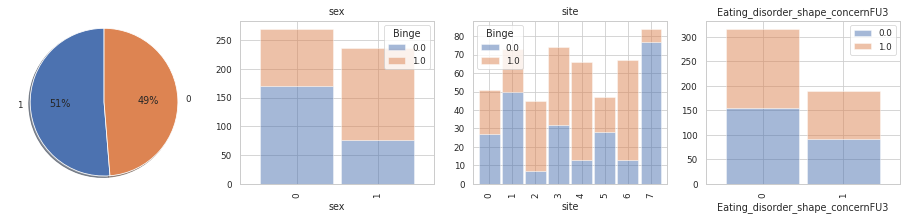


subject: 4631192 	 (min=0.00, mean=18491.60, max=1667881.00)
conf Eating_disorder_shape_concernFU3 == label Binge ? 	 True for n=253/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Impulsivity_BISFU3.h5 
 h5.columns = ['Binge', 'Impulsivity_BISFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 556 	 label = Binge 	 X.shape = (556, 719)  	 confs = ['sex', 'site', 'Impulsivity_BISFU3']
label and conf with distributions:


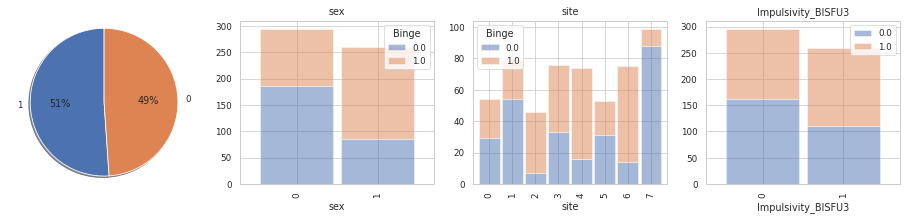


subject: 33030797 	 (min=0.00, mean=17594.53, max=1835167.00)
conf Impulsivity_BISFU3 == label Binge ? 	 True for n=310/556
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Neuroticism.h5 
 h5.columns = ['Binge', 'Neuroticism', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Neuroticism']
label and conf with distributions:


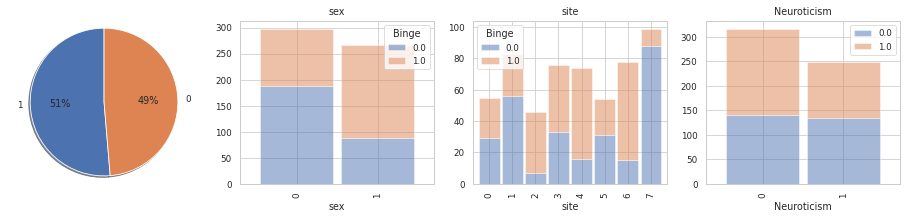


subject: 73811405 	 (min=0.00, mean=17474.38, max=1646082.00)
conf Neuroticism == label Binge ? 	 True for n=253/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Autonomy_valFU3.h5 
 h5.columns = ['Autonomy_valFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Autonomy_valFU3']
label and conf with distributions:


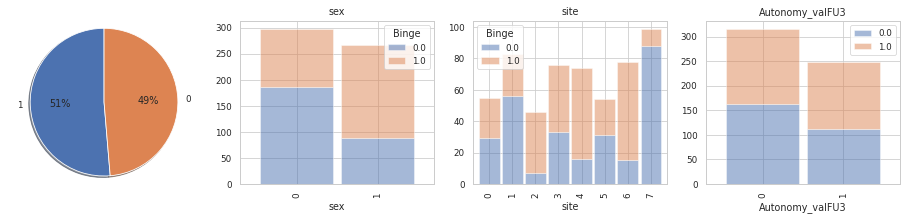


subject: 76847922 	 (min=0.00, mean=17530.46, max=1650129.00)
conf Autonomy_valFU3 == label Binge ? 	 True for n=300/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Psychiatric_symptoms_PHQFU3.h5 
 h5.columns = ['Binge', 'Psychiatric_symptoms_PHQFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 456 	 label = Binge 	 X.shape = (456, 719)  	 confs = ['sex', 'site', 'Psychiatric_symptoms_PHQFU3']
label and conf with distributions:


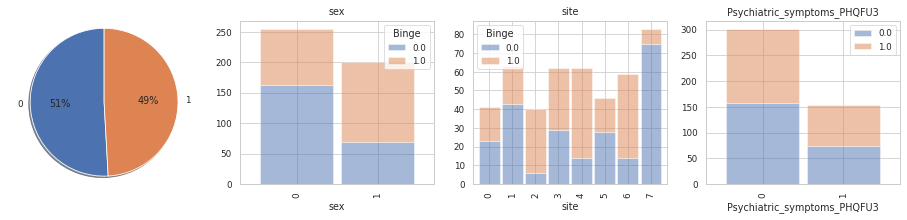


subject: 57172435 	 (min=0.00, mean=17923.40, max=1631212.00)
conf Psychiatric_symptoms_PHQFU3 == label Binge ? 	 True for n=238/456
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Deviance_freq.h5 
 h5.columns = ['Binge', 'Deviance_freq', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Deviance_freq']
label and conf with distributions:


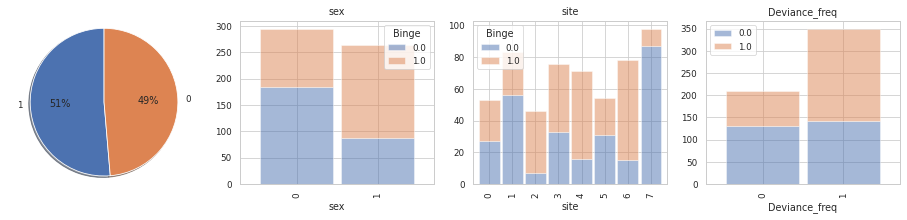


subject: 77596543 	 (min=0.00, mean=20445.40, max=1814957.00)
conf Deviance_freq == label Binge ? 	 True for n=340/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Interpers_perspective_takingFU3.h5 
 h5.columns = ['Binge', 'Interpers_perspective_takingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 508 	 label = Binge 	 X.shape = (508, 719)  	 confs = ['sex', 'site', 'Interpers_perspective_takingFU3']
label and conf with distributions:


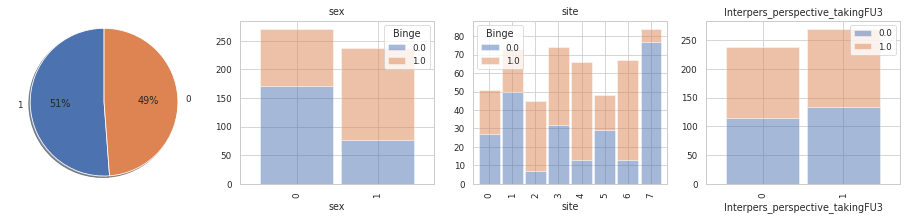


subject: 51076110 	 (min=0.00, mean=14867.70, max=1437889.00)
conf Interpers_perspective_takingFU3 == label Binge ? 	 True for n=250/508
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sexuality_freqFU3.h5 
 h5.columns = ['Binge', 'Sexuality_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Sexuality_freqFU3']
label and conf with distributions:


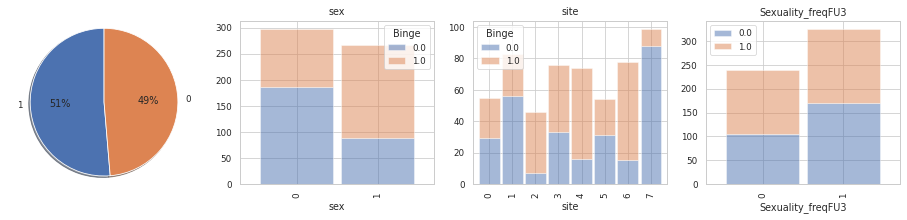


subject: 71766352 	 (min=0.00, mean=17289.40, max=1586404.00)
conf Sexuality_freqFU3 == label Binge ? 	 True for n=259/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Family_valFU3.h5 
 h5.columns = ['Binge', 'Family_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Family_valFU3']
label and conf with distributions:


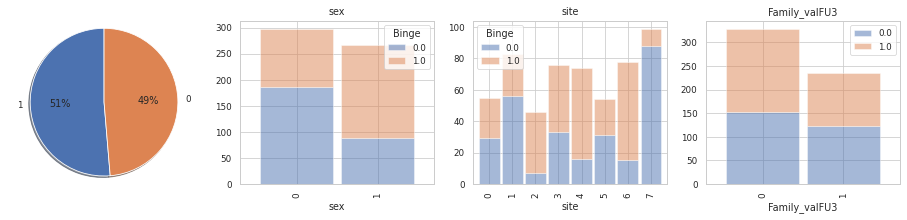


subject: 14759699 	 (min=0.00, mean=17484.29, max=1648275.00)
conf Family_valFU3 == label Binge ? 	 True for n=267/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Accident_valFU3.h5 
 h5.columns = ['Accident_valFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Accident_valFU3']
label and conf with distributions:


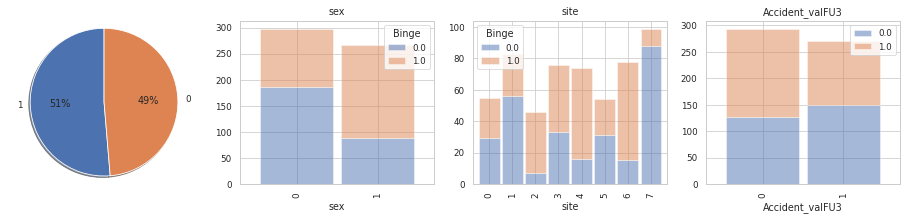


subject: 19947904 	 (min=0.00, mean=18264.82, max=1618692.00)
conf Accident_valFU3 == label Binge ? 	 True for n=248/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Bullying.h5 
 h5.columns = ['Binge', 'Bullying', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Bullying']
label and conf with distributions:


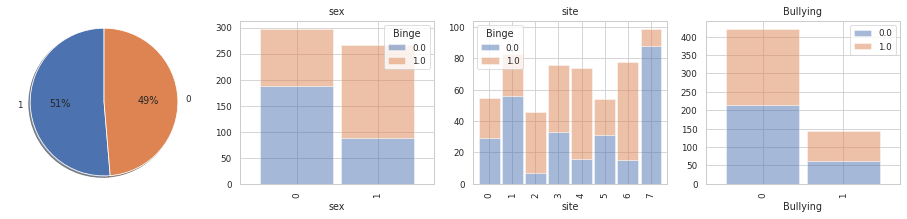


subject: 71039594 	 (min=0.00, mean=17038.16, max=1496806.00)
conf Bullying == label Binge ? 	 True for n=294/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Social_difficulties_impact.h5 
 h5.columns = ['Binge', 'Social_difficulties_impact', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Social_difficulties_impact']
label and conf with distributions:


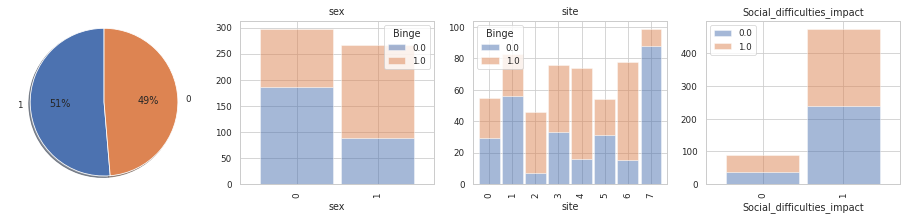


subject: 55757334 	 (min=0.00, mean=19122.52, max=1720518.00)
conf Social_difficulties_impact == label Binge ? 	 True for n=275/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Deviance_freqFU3.h5 
 h5.columns = ['Binge', 'Deviance_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Deviance_freqFU3']
label and conf with distributions:


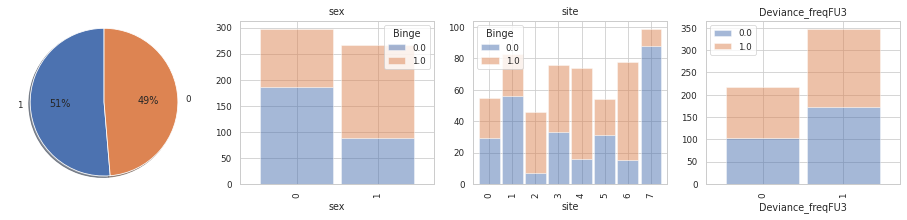


subject: 94878465 	 (min=0.00, mean=17675.99, max=1587505.00)
conf Deviance_freqFU3 == label Binge ? 	 True for n=277/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Fam_hist_psych_disorders_parent.h5 
 h5.columns = ['Binge', 'Fam_hist_psych_disorders_parent', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Fam_hist_psych_disorders_parent']
label and conf with distributions:


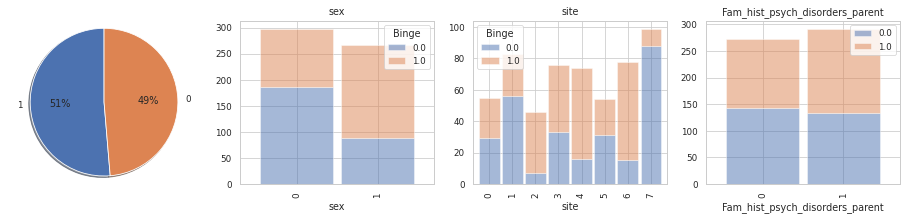


subject: 67192845 	 (min=0.00, mean=21315.85, max=1902994.00)
conf Fam_hist_psych_disorders_parent == label Binge ? 	 True for n=301/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Positive_affectFU3.h5 
 h5.columns = ['Binge', 'Positive_affectFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Positive_affectFU3']
label and conf with distributions:


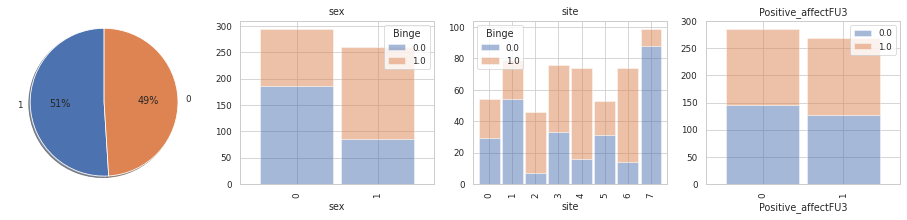


subject: 8043474 	 (min=0.00, mean=14849.30, max=1420194.00)
conf Positive_affectFU3 == label Binge ? 	 True for n=287/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Conformity_drinking_motiveFU3.h5 
 h5.columns = ['Binge', 'Conformity_drinking_motiveFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Conformity_drinking_motiveFU3']
label and conf with distributions:


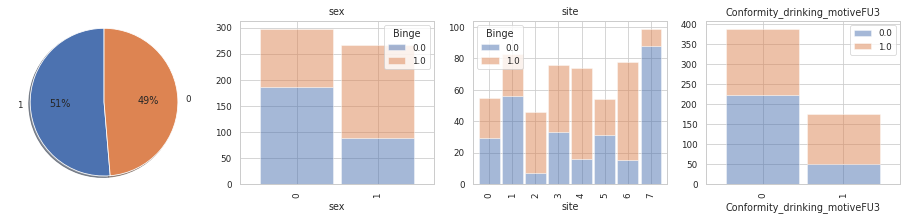


subject: 98989002 	 (min=0.00, mean=17617.01, max=1639702.00)
conf Conformity_drinking_motiveFU3 == label Binge ? 	 True for n=349/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Impulsivity_SURPS.h5 
 h5.columns = ['Binge', 'Impulsivity_SURPS', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 564 	 label = Binge 	 X.shape = (564, 719)  	 confs = ['sex', 'site', 'Impulsivity_SURPS']
label and conf with distributions:


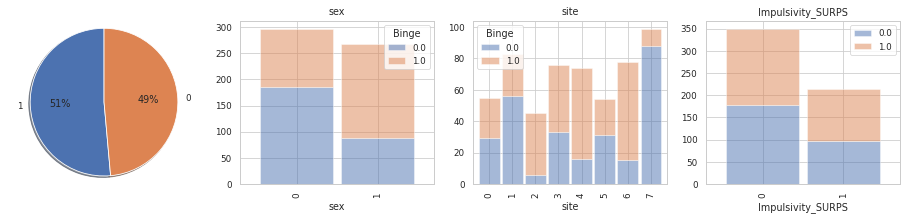


subject: 31548817 	 (min=0.00, mean=18536.33, max=1705928.00)
conf Impulsivity_SURPS == label Binge ? 	 True for n=296/564
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_behavior_uncontrolled_eatingFU3.h5 
 h5.columns = ['Binge', 'Eating_behavior_uncontrolled_eatingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_behavior_uncontrolled_eatingFU3']
label and conf with distributions:


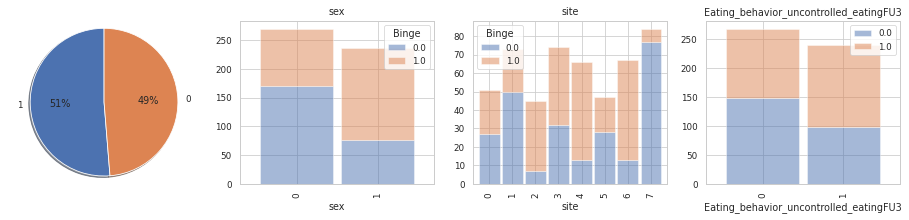


subject: 7843654 	 (min=0.00, mean=20350.93, max=1809940.00)
conf Eating_behavior_uncontrolled_eatingFU3 == label Binge ? 	 True for n=290/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Bullying_victim.h5 
 h5.columns = ['Binge', 'Bullying_victim', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Bullying_victim']
label and conf with distributions:


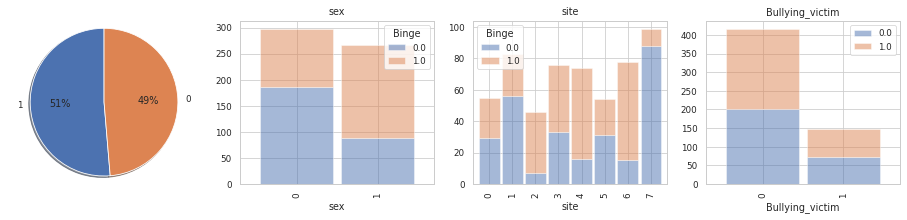


subject: 61561596 	 (min=0.00, mean=19717.50, max=1771365.00)
conf Bullying_victim == label Binge ? 	 True for n=277/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-GSI_BSIFU3.h5 
 h5.columns = ['Binge', 'GSI_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'GSI_BSIFU3']
label and conf with distributions:


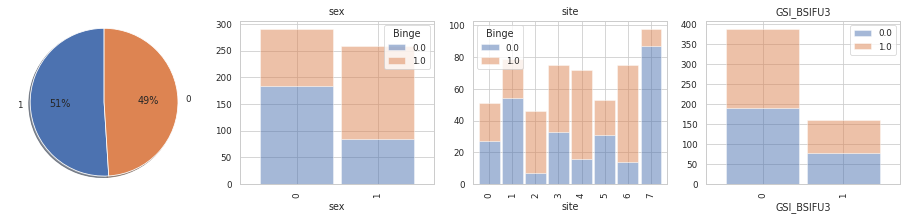


subject: 41765496 	 (min=0.00, mean=16538.76, max=1470667.00)
conf GSI_BSIFU3 == label Binge ? 	 True for n=273/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Negative_affectFU3.h5 
 h5.columns = ['Binge', 'Negative_affectFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'Negative_affectFU3']
label and conf with distributions:


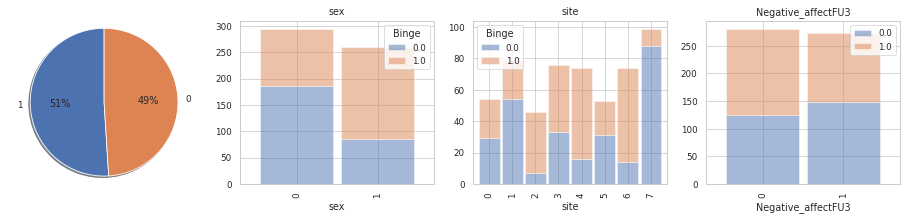


subject: 47507426 	 (min=0.00, mean=16767.08, max=1656329.00)
conf Negative_affectFU3 == label Binge ? 	 True for n=250/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Physical_developmet.h5 
 h5.columns = ['Binge', 'Physical_developmet', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 564 	 label = Binge 	 X.shape = (564, 719)  	 confs = ['sex', 'site', 'Physical_developmet']
label and conf with distributions:


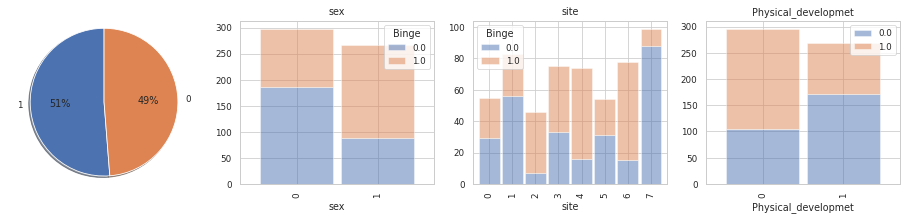


subject: 3562821 	 (min=0.00, mean=16642.55, max=1494232.00)
conf Physical_developmet == label Binge ? 	 True for n=201/564
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_disorder_eat_concernFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_eat_concernFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_disorder_eat_concernFU3']
label and conf with distributions:


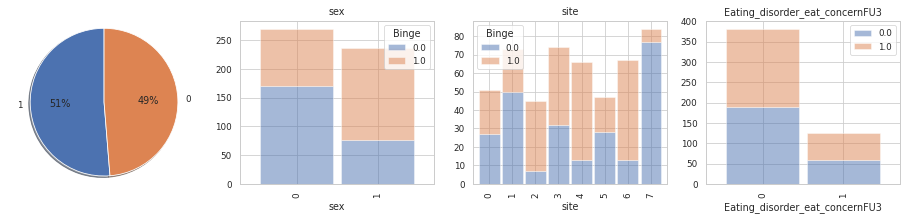


subject: 60334165 	 (min=0.00, mean=19780.45, max=1811483.00)
conf Eating_disorder_eat_concernFU3 == label Binge ? 	 True for n=256/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc-lastmntFU3.h5 
 h5.columns = ['Alc-lastmntFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Alc-lastmntFU3']
label and conf with distributions:


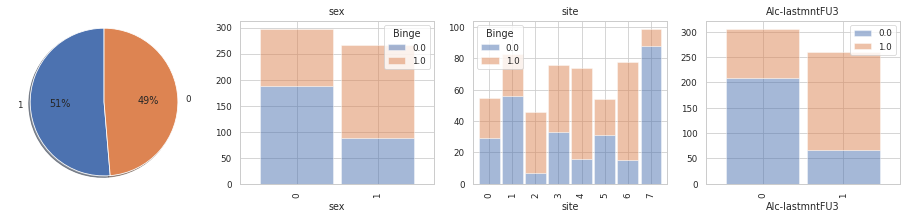


subject: 55104004 	 (min=0.00, mean=19970.15, max=1901073.00)
conf Alc-lastmntFU3 == label Binge ? 	 True for n=400/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_disorder_weight_concernFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_weight_concernFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_disorder_weight_concernFU3']
label and conf with distributions:


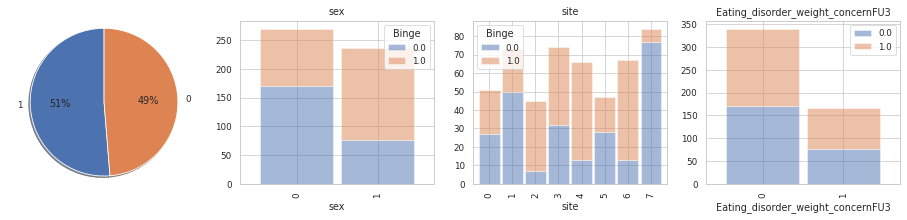


subject: 6006399 	 (min=0.00, mean=19596.50, max=1857407.00)
conf Eating_disorder_weight_concernFU3 == label Binge ? 	 True for n=260/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Psychotic_experienceFU3.h5 
 h5.columns = ['Binge', 'Psychotic_experienceFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 557 	 label = Binge 	 X.shape = (557, 719)  	 confs = ['sex', 'site', 'Psychotic_experienceFU3']
label and conf with distributions:


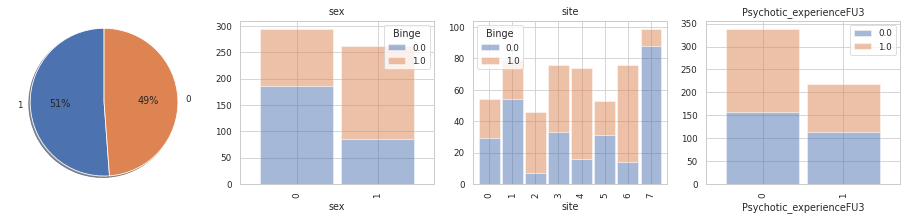


subject: 64043761 	 (min=0.00, mean=18058.81, max=1646380.00)
conf Psychotic_experienceFU3 == label Binge ? 	 True for n=262/557
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sensation_seekingFU3.h5 
 h5.columns = ['Binge', 'Sensation_seekingFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 561 	 label = Binge 	 X.shape = (561, 719)  	 confs = ['sex', 'site', 'Sensation_seekingFU3']
label and conf with distributions:


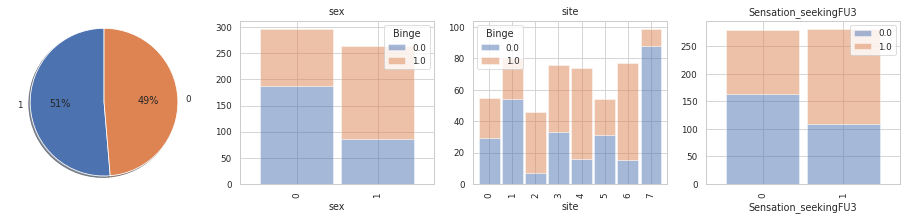


subject: 55499880 	 (min=0.00, mean=18718.92, max=1653957.00)
conf Sensation_seekingFU3 == label Binge ? 	 True for n=337/561
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-AnxietyFU3.h5 
 h5.columns = ['AnxietyFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 556 	 label = Binge 	 X.shape = (556, 719)  	 confs = ['sex', 'site', 'AnxietyFU3']
label and conf with distributions:


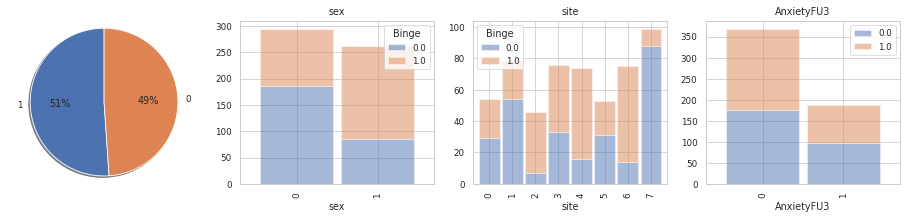


subject: 91110028 	 (min=0.00, mean=17451.62, max=1542659.00)
conf AnxietyFU3 == label Binge ? 	 True for n=267/556
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Family_freqFU3.h5 
 h5.columns = ['Binge', 'Family_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Family_freqFU3']
label and conf with distributions:


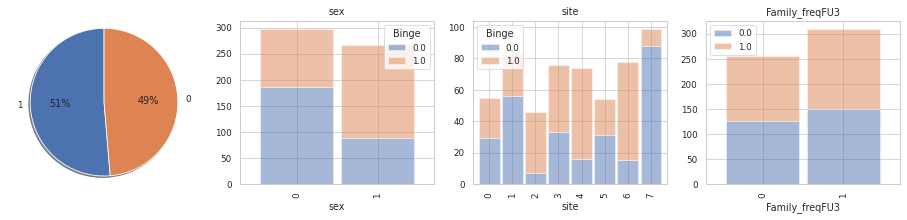


subject: 83037309 	 (min=0.00, mean=20167.10, max=1827640.00)
conf Family_freqFU3 == label Binge ? 	 True for n=287/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-QOL_phys_unhealthy_daysFU3.h5 
 h5.columns = ['Binge', 'QOL_phys_unhealthy_daysFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 555 	 label = Binge 	 X.shape = (555, 719)  	 confs = ['sex', 'site', 'QOL_phys_unhealthy_daysFU3']
label and conf with distributions:


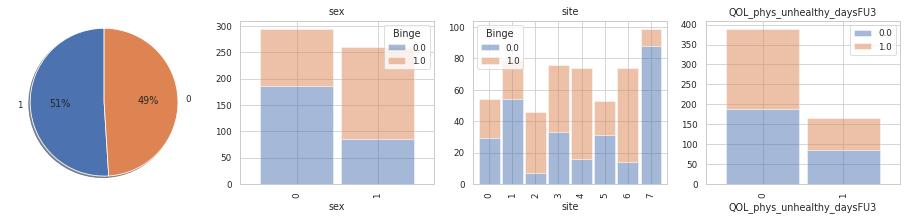


subject: 61869818 	 (min=0.00, mean=17536.59, max=1555706.00)
conf QOL_phys_unhealthy_daysFU3 == label Binge ? 	 True for n=267/555
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3.h5 
 h5.columns = ['Binge', 'Paranoid_ideation_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Paranoid_ideation_BSIFU3']
label and conf with distributions:


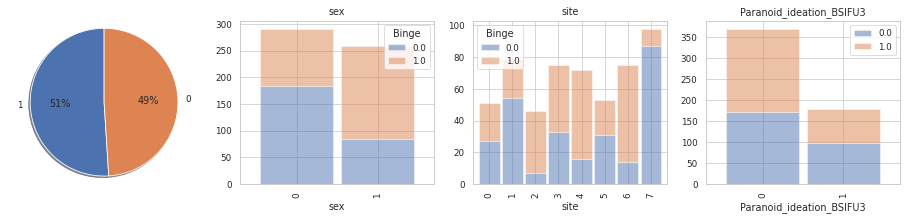


subject: 26545049 	 (min=0.00, mean=18979.87, max=1683433.00)
conf Paranoid_ideation_BSIFU3 == label Binge ? 	 True for n=253/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Social_difficultiesFU3.h5 
 h5.columns = ['Binge', 'Social_difficultiesFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 545 	 label = Binge 	 X.shape = (545, 719)  	 confs = ['sex', 'site', 'Social_difficultiesFU3']
label and conf with distributions:


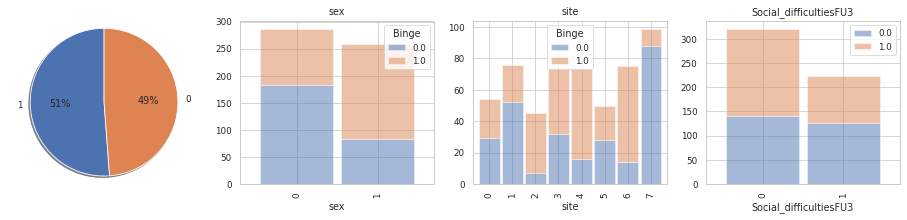


subject: 51671690 	 (min=0.00, mean=19003.51, max=1734842.00)
conf Social_difficultiesFU3 == label Binge ? 	 True for n=240/545
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Psychoticism_BSIFU3.h5 
 h5.columns = ['Binge', 'Psychoticism_BSIFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 549 	 label = Binge 	 X.shape = (549, 719)  	 confs = ['sex', 'site', 'Psychoticism_BSIFU3']
label and conf with distributions:


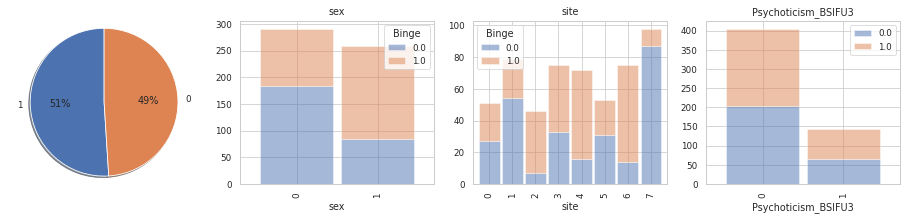


subject: 25492584 	 (min=0.00, mean=18778.96, max=1731514.00)
conf Psychoticism_BSIFU3 == label Binge ? 	 True for n=281/549
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_behavior_cog_retrstraintFU3.h5 
 h5.columns = ['Binge', 'Eating_behavior_cog_retrstraintFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_behavior_cog_retrstraintFU3']
label and conf with distributions:


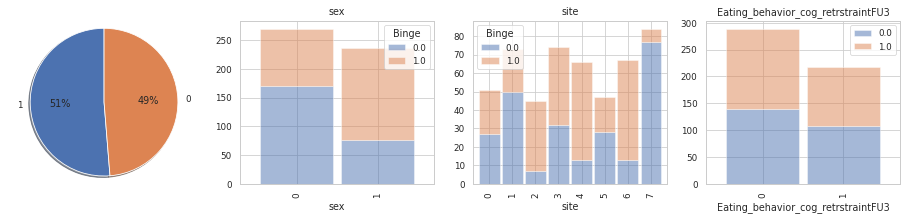


subject: 37821661 	 (min=0.00, mean=15433.05, max=1407514.00)
conf Eating_behavior_cog_retrstraintFU3 == label Binge ? 	 True for n=249/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alc_lastmnt_TLFBFU3.h5 
 h5.columns = ['Alc_lastmnt_TLFBFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 463 	 label = Binge 	 X.shape = (463, 719)  	 confs = ['sex', 'site', 'Alc_lastmnt_TLFBFU3']
label and conf with distributions:


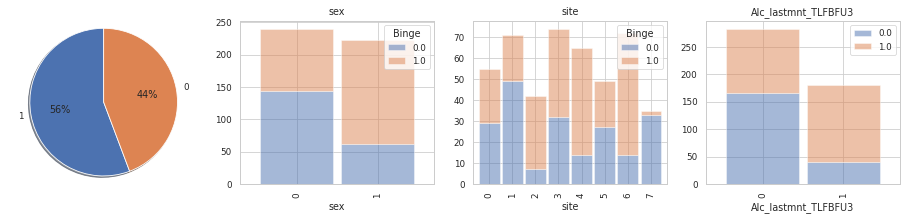


subject: 91474448 	 (min=0.00, mean=17649.43, max=1566485.00)
conf Alc_lastmnt_TLFBFU3 == label Binge ? 	 True for n=305/463
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Depression_CESDFU3.h5 
 h5.columns = ['Binge', 'Depression_CESDFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 560 	 label = Binge 	 X.shape = (560, 719)  	 confs = ['sex', 'site', 'Depression_CESDFU3']
label and conf with distributions:


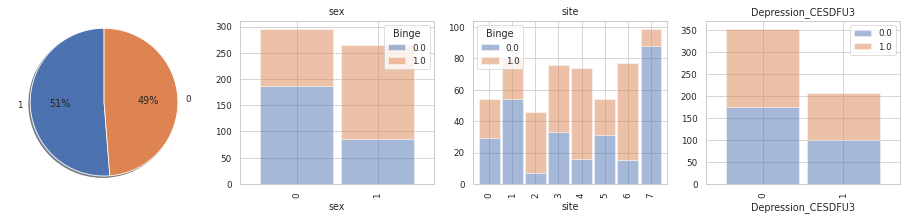


subject: 97555742 	 (min=0.00, mean=18479.87, max=1671083.00)
conf Depression_CESDFU3 == label Binge ? 	 True for n=282/560
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Total_freqFU3.h5 
 h5.columns = ['Binge', 'Total_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Total_freqFU3']
label and conf with distributions:


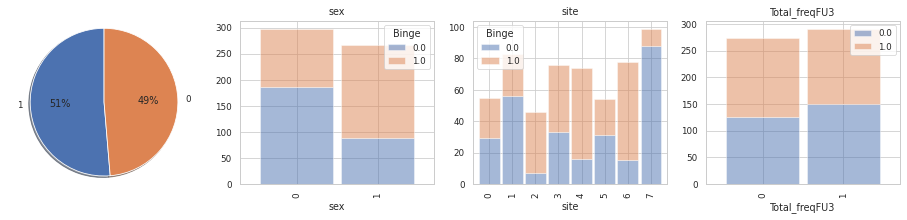


subject: 66086086 	 (min=0.00, mean=16139.09, max=1501037.00)
conf Total_freqFU3 == label Binge ? 	 True for n=268/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Autonomy_freq.h5 
 h5.columns = ['Autonomy_freq', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Autonomy_freq']
label and conf with distributions:


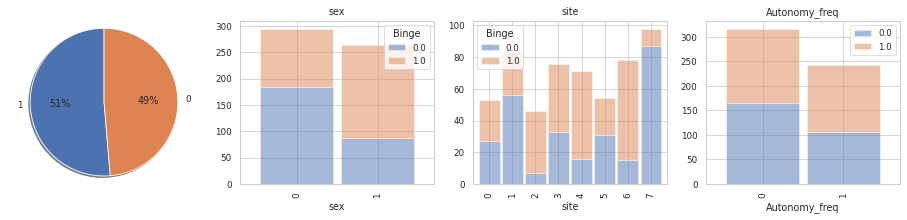


subject: 35004186 	 (min=0.00, mean=16272.81, max=1651931.00)
conf Autonomy_freq == label Binge ? 	 True for n=302/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Accident_val.h5 
 h5.columns = ['Accident_val', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Accident_val']
label and conf with distributions:


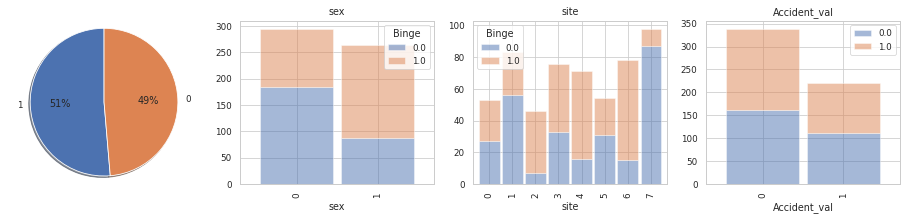


subject: 64851530 	 (min=0.00, mean=16606.51, max=1513211.00)
conf Accident_val == label Binge ? 	 True for n=270/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Extroversion.h5 
 h5.columns = ['Binge', 'Extroversion', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Extroversion']
label and conf with distributions:


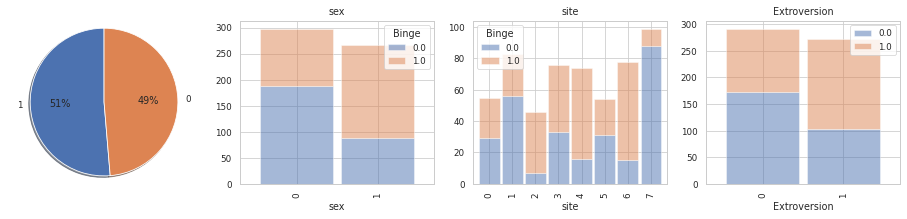


subject: 76544039 	 (min=0.00, mean=20183.88, max=1756095.00)
conf Extroversion == label Binge ? 	 True for n=342/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sensation_seeking.h5 
 h5.columns = ['Binge', 'Sensation_seeking', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 564 	 label = Binge 	 X.shape = (564, 719)  	 confs = ['sex', 'site', 'Sensation_seeking']
label and conf with distributions:


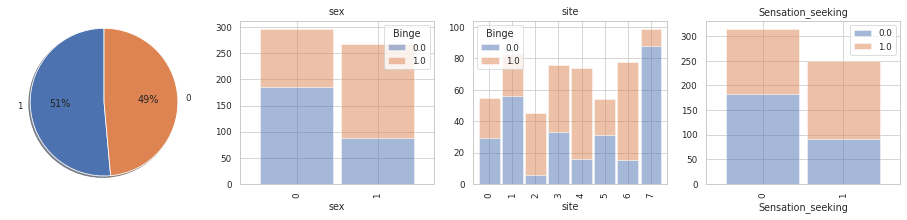


subject: 52638709 	 (min=0.00, mean=14585.05, max=1473261.00)
conf Sensation_seeking == label Binge ? 	 True for n=339/564
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_psych_aggr.h5 
 h5.columns = ['Binge', 'Conflict_tactics_parent_mean_psych_aggr', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 553 	 label = Binge 	 X.shape = (553, 719)  	 confs = ['sex', 'site', 'Conflict_tactics_parent_mean_psych_aggr']
label and conf with distributions:


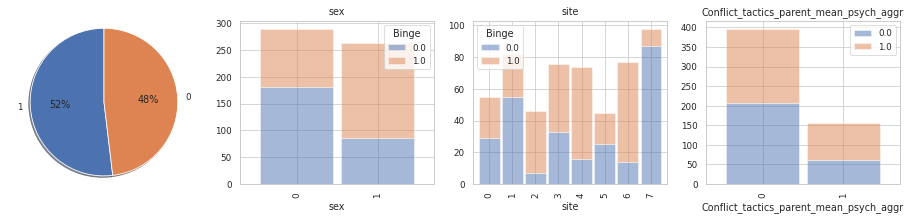


subject: 92260456 	 (min=0.00, mean=17644.09, max=1571195.00)
conf Conflict_tactics_parent_mean_psych_aggr == label Binge ? 	 True for n=302/553
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-ExtroversionFU3.h5 
 h5.columns = ['Binge', 'ExtroversionFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 563 	 label = Binge 	 X.shape = (563, 719)  	 confs = ['sex', 'site', 'ExtroversionFU3']
label and conf with distributions:


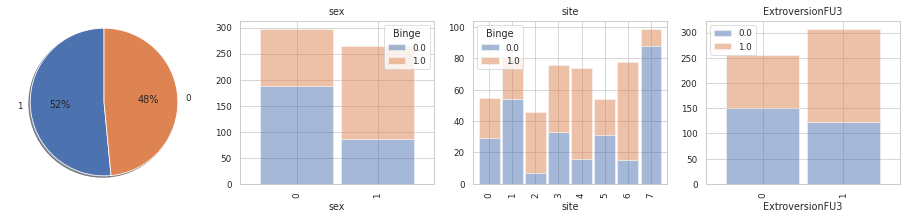


subject: 99873252 	 (min=0.00, mean=15702.62, max=1411715.00)
conf ExtroversionFU3 == label Binge ? 	 True for n=335/563
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-HopelessnessFU3.h5 
 h5.columns = ['Binge', 'HopelessnessFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 561 	 label = Binge 	 X.shape = (561, 719)  	 confs = ['sex', 'site', 'HopelessnessFU3']
label and conf with distributions:


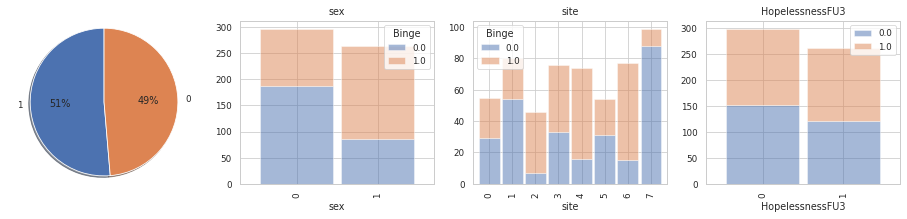


subject: 66086086 	 (min=0.00, mean=16139.09, max=1501037.00)
conf HopelessnessFU3 == label Binge ? 	 True for n=293/561
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Smoking_lifetime.h5 
 h5.columns = ['Binge', 'Smoking_lifetime', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Smoking_lifetime']
label and conf with distributions:


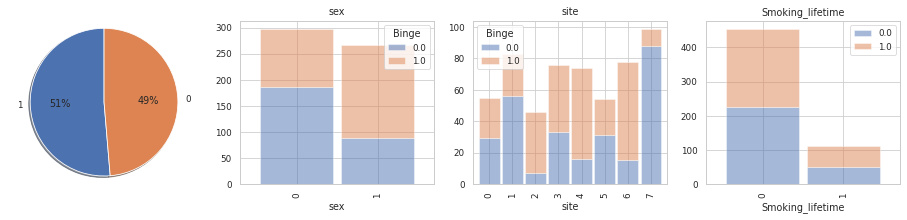


subject: 69795852 	 (min=0.00, mean=21055.86, max=1838741.00)
conf Smoking_lifetime == label Binge ? 	 True for n=285/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Eating_disorder_restraintFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_restraintFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 507 	 label = Binge 	 X.shape = (507, 719)  	 confs = ['sex', 'site', 'Eating_disorder_restraintFU3']
label and conf with distributions:


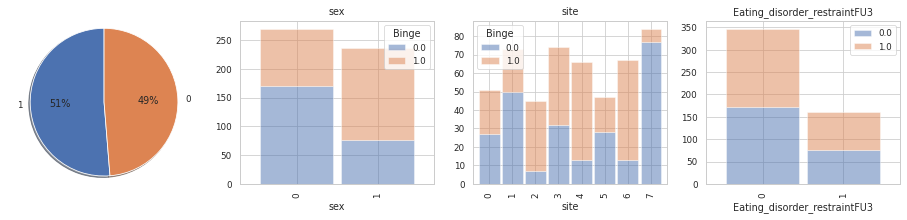


subject: 28852607 	 (min=0.00, mean=15646.91, max=1412690.00)
conf Eating_disorder_restraintFU3 == label Binge ? 	 True for n=255/507
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Relocation_freqFU3.h5 
 h5.columns = ['Binge', 'Relocation_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Relocation_freqFU3']
label and conf with distributions:


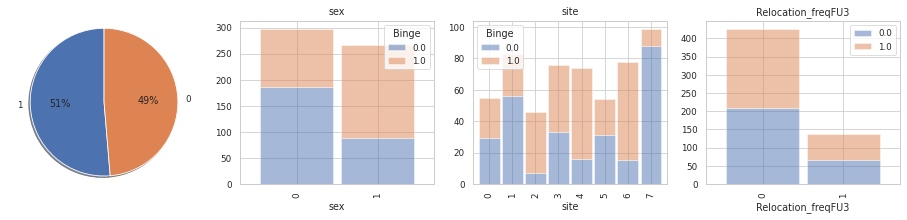


subject: 36043675 	 (min=0.00, mean=19479.69, max=1757311.00)
conf Relocation_freqFU3 == label Binge ? 	 True for n=279/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Distress_freqFU3.h5 
 h5.columns = ['Binge', 'Distress_freqFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Distress_freqFU3']
label and conf with distributions:


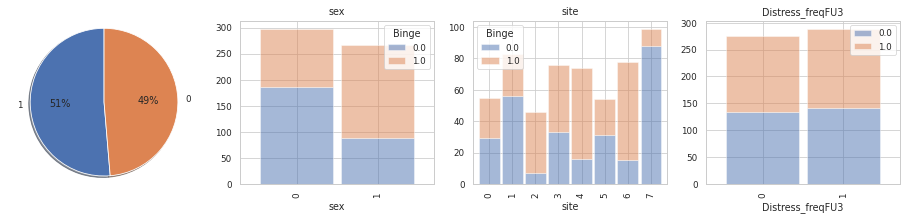


subject: 6177246 	 (min=0.00, mean=18598.07, max=1683490.00)
conf Distress_freqFU3 == label Binge ? 	 True for n=280/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Video_gaming_addictionFU3.h5 
 h5.columns = ['Binge', 'Video_gaming_addictionFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 506 	 label = Binge 	 X.shape = (506, 719)  	 confs = ['sex', 'site', 'Video_gaming_addictionFU3']
label and conf with distributions:


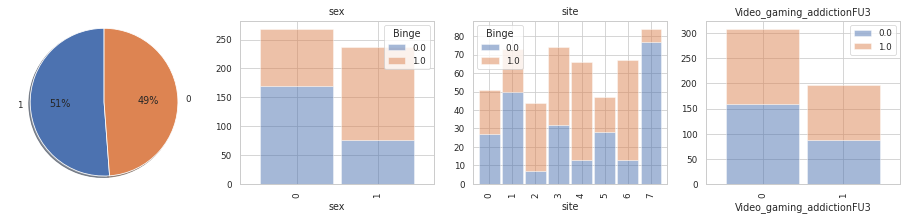


subject: 47472787 	 (min=0.00, mean=16869.14, max=1585762.00)
conf Video_gaming_addictionFU3 == label Binge ? 	 True for n=270/506
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Alcohol_problem_indexFU3.h5 
 h5.columns = ['Alcohol_problem_indexFU3', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Alcohol_problem_indexFU3']
label and conf with distributions:


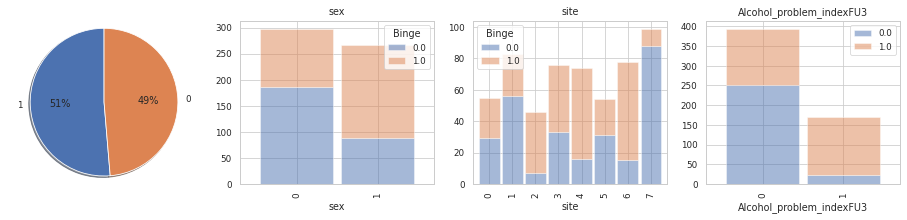


subject: 83049855 	 (min=0.00, mean=19295.87, max=1741754.00)
conf Alcohol_problem_indexFU3 == label Binge ? 	 True for n=400/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Sexuality_valFU3.h5 
 h5.columns = ['Binge', 'Sexuality_valFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 565 	 label = Binge 	 X.shape = (565, 719)  	 confs = ['sex', 'site', 'Sexuality_valFU3']
label and conf with distributions:


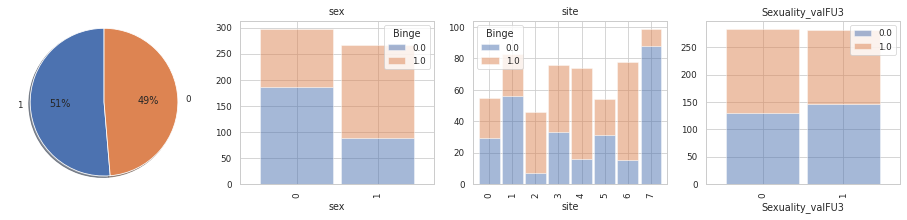


subject: 42749560 	 (min=0.00, mean=16122.51, max=1492102.00)
conf Sexuality_valFU3 == label Binge ? 	 True for n=264/565
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Total_val.h5 
 h5.columns = ['Binge', 'Total_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Total_val']
label and conf with distributions:


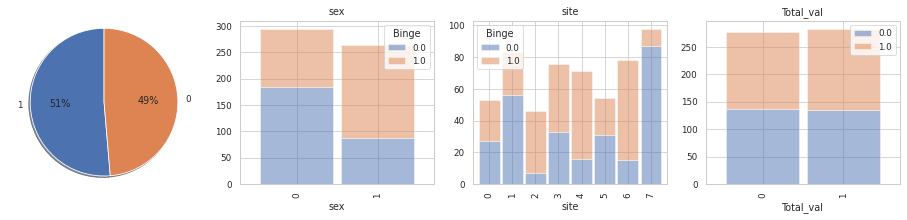


subject: 69795852 	 (min=0.00, mean=21055.86, max=1838741.00)
conf Total_val == label Binge ? 	 True for n=285/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Relocation_val.h5 
 h5.columns = ['Binge', 'Relocation_val', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Relocation_val']
label and conf with distributions:


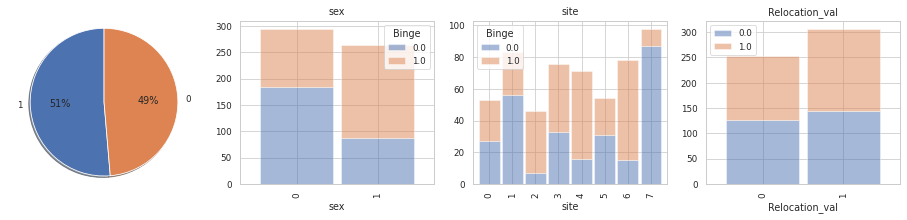


subject: 12715429 	 (min=0.00, mean=14859.10, max=1392773.00)
conf Relocation_val == label Binge ? 	 True for n=289/559
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Anxiety_sensitivity.h5 
 h5.columns = ['Anxiety_sensitivity', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 564 	 label = Binge 	 X.shape = (564, 719)  	 confs = ['sex', 'site', 'Anxiety_sensitivity']
label and conf with distributions:


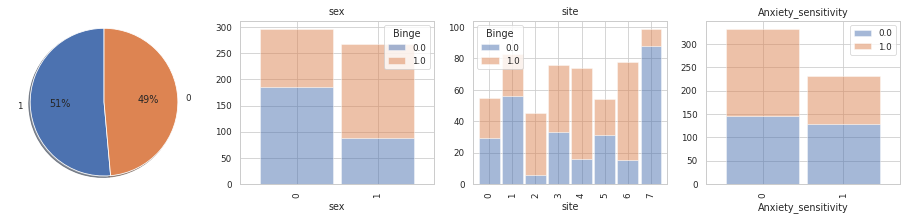


subject: 48934345 	 (min=0.00, mean=17058.52, max=1541705.00)
conf Anxiety_sensitivity == label Binge ? 	 True for n=249/564
______________________________________________________________________________________
filename: posthoc-cc2-h5causal1-Autonomy_val.h5 
 h5.columns = ['Autonomy_val', 'Binge', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 559 	 label = Binge 	 X.shape = (559, 719)  	 confs = ['sex', 'site', 'Autonomy_val']
label and conf with distributions:


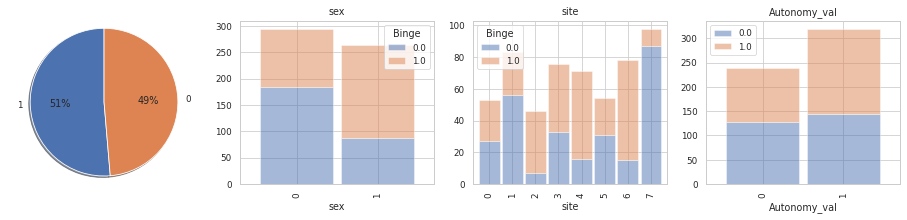


subject: 36043675 	 (min=0.00, mean=19479.69, max=1757311.00)
conf Autonomy_val == label Binge ? 	 True for n=302/559


In [241]:
check_h5_contents(glob(H5_DIR+f"posthoc-cc2-{h5_name}*.h5"))

In [242]:
print("Created {} h5 files".format(len(glob(H5_DIR+f"posthoc-cc2-{h5_name}*.h5"))))

Created 118 h5 files


In [232]:
print_h5_for_MLpipeline(filter_func=lambda x: f"posthoc-cc2" in x) #{h5_name}

  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-AUDIT_parent.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Accident_freq.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Accident_val.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Accident_valFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Age_first_drunkFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc-last12mnt.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc-last12mntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc-lastmnt.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc-lastmntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc_lastmnt_TLFB.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alc_lastmnt_TLFBFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alcohol_problem_indexFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Alcoholism_screening_parent.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-AnxietyFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal1-Anxiety_BSIFU3.h5',
  DATA_DIR + 'h5

### Run MLpipeline
 Add the above h5files in runMLpipelines.py, configure the appropriate settings and run it as
 `$nohup python3 runMLpipeline.py &`

### Plot results

In [107]:
df = create_accuracy_csv(h5name)
df.Confound.nunique()

NameError: name 'h5name' is not defined

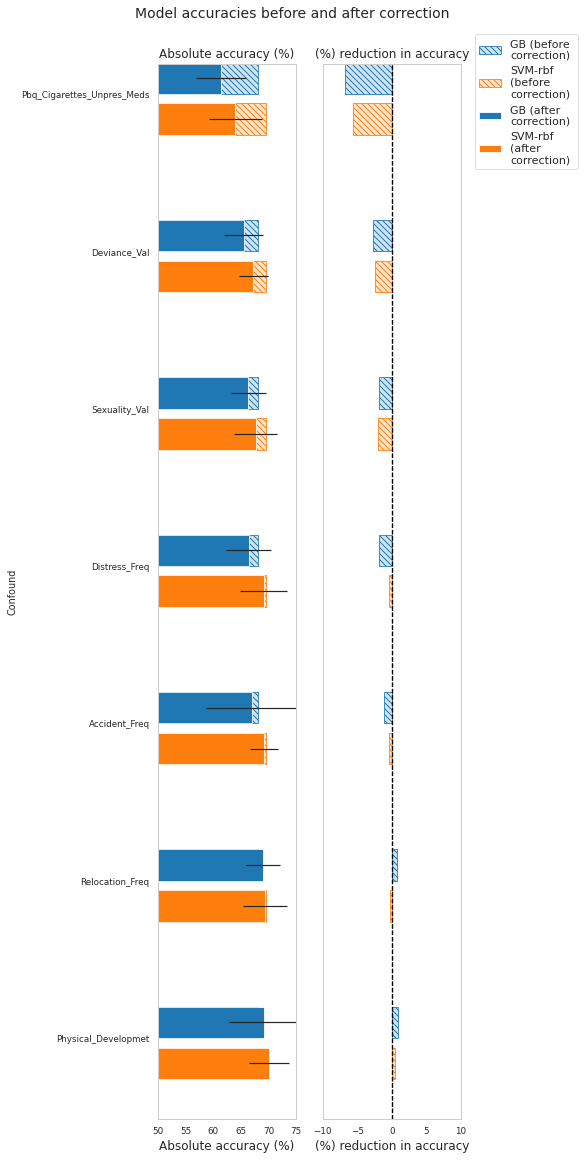

In [105]:
plot_accuracy_csv(df)
# plt.savefig(f"results/results-{h5_name}.jpg")

In [68]:
# for result in sorted(glob(f"../MLpipelines/results/posthoc-cc2-*{conf.name}*/*/run.csv")):
#     df = pd.read_csv(result)
#     plot_result(df, x="test_score", no_confs=False)
#     plt.show()

### Next steps: 
2. Do the results generalize to test data? - repeat on holdout data
3. Are the results robust to different subsets? - repeat on FU3 and BL (full)
4. Multiple comparisons correction